In [1]:
# --- Standard library imports ---
import os                     # Operating system utilities (paths, mkdir, environment)
import sys                    # System-specific parameters and functions
import re                     # Regular expressions (parsing native_id, filenames)
import glob                   # Unix-style pathname pattern expansion (file discovery)
import warnings               # Emit and control warning messages
from collections import defaultdict  # Dict subclass with default factory
from io import BytesIO        # In-memory binary streams (images, downloads)

# --- Scientific computing and data handling ---
import numpy as np            # Numerical arrays and operations
import xarray as xr           # Labeled multi-dimensional arrays (netCDF, etc.)
import pandas as pd           # Tabular data handling (CSV/Excel)

# --- Parallel / distributed computing ---
from dask.distributed import Client  # Dask client for parallel processing
import logging               # Logging for tracking events and errors

# --- Plotting and visualization ---
import matplotlib.pyplot as plt          # Main plotting library
import matplotlib.colors as mcolors      # Color utilities and colormap helpers
import matplotlib.dates as mdates        # Date formatting for plots
from matplotlib.colors import LogNorm, LinearSegmentedColormap, ListedColormap # Color normalization and custom colormaps
import matplotlib.gridspec as gridspec # Grid specification for complex subplot layouts
import imageio                           # Read/write animated images (GIFs)
from IPython.display import Image as gifImage # Display GIFs in Jupyter notebooks

# --- Image processing ---
from PIL import Image, ImageEnhance   # Pillow for image enhancement used in RGB rendering

# --- Oceanographic / color maps ---
import cmocean                         # Oceanographic colormaps (thermal, haline, balance, etc.)
import colormaps as cmaps              # Additional colormap utilities

# --- Geospatial plotting ---
import cartopy.crs as ccrs             # Cartopy coordinate reference system
import cartopy.feature as cfeature     # Cartopy features (coastlines, land, etc.)

# --- Web and cloud access ---
import earthaccess                     # NASA Earthdata cloud and data access client

# --- MLD access additions ---
from pathlib import Path
import requests


In [2]:
def grid_match(path, dst_crs, dst_shape, dst_transform, variable):
    """
    Reproject a Level-2 granule variable into a common (L3M-like) geographic grid.

    This helper function opens a single granule stored as an xarray datatree, extracts the
    requested geophysical variable and reprojects it to the target grid specified
    by dst_crs / dst_shape / dst_transform. The function also renames the output
    spatial dimensions to 'longitude' and 'latitude' for consistency with the
    rest of the notebook.

    Parameters
    ----------
    path : str or Path
        Filesystem path (or cloud URL) to the granule to open.
    dst_crs : str
        Destination CRS (e.g. "epsg:4326") used by rioxarray.reproject.
    dst_shape : tuple
        Output array shape (ny, nx) for the reprojected grid.
    dst_transform : affine.Affine or similar
        Geospatial transform for the target grid.
    variable : str
        Name of the variable in the granule to extract (e.g. "chlor_a").

    Returns
    -------
    xarray.DataArray
        Reprojected data array with coords "longitude" and "latitude".
    """
    dt = xr.open_datatree(path, decode_timedelta=True)
    da = dt["geophysical_data"][variable]

    # Ensure rioxarray can interpret the L2 pixel axes
    da = da.rio.set_spatial_dims("pixels_per_line", "number_of_lines")
    da = da.rio.write_crs("epsg:4326")

    # Reproject to the provided destination grid using the navigation arrays from the datatree
    da = da.rio.reproject(
        dst_crs,
        shape=dst_shape,
        transform=dst_transform,
        src_geoloc_array=(
            dt["navigation_data"]["longitude"],
            dt["navigation_data"]["latitude"],
        ),
    )

    # Standardize coordinate names used across the notebook
    da = da.rename({"x": "longitude", "y": "latitude"})
    return da


def grid_match_SREF(path, dst_crs, dst_shape, dst_transform, variable):
    """
    Same as grid_match but developed for surface reflectance (SREF) files that
    include a wavelength dimension that must be transposed first.

    The surface reflectance granules used here have a 'wavelength_3d' axis; this
    function reorders dimensions so rioxarray can reproject correctly.

    Parameters
    ----------
    path, dst_crs, dst_shape, dst_transform, variable
        See grid_match docstring.

    Returns
    -------
    xarray.DataArray
        Reprojected SREF data array with coords "longitude" and "latitude".
    """
    dt = xr.open_datatree(path, decode_timedelta=True)
    da = dt["geophysical_data"][variable]

    # Reorder to (wavelength, lines, pixels) for rioxarray compatibility
    da = da.transpose("wavelength_3d", "number_of_lines", "pixels_per_line")
    da = da.rio.set_spatial_dims("pixels_per_line", "number_of_lines")
    da = da.rio.write_crs("epsg:4326")

    da = da.rio.reproject(
        dst_crs,
        shape=dst_shape,
        transform=dst_transform,
        src_geoloc_array=(
            dt["navigation_data"]["longitude"],
            dt["navigation_data"]["latitude"],
        ),
    )

    da = da.rename({"x": "longitude", "y": "latitude"})
    return da


def time_from_attr(ds):
    """
    Create a 'time' coordinate from the dataset attribute 'time_coverage_start'.

    Many Level-2 granules include the acquisition time as an attribute. This
    routine parses that attribute, converts it to a numpy datetime64, and sets
    it as a coordinate so xarray concatenation by time is straightforward.

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset loaded from a Level-2 granule that contains the attribute
        'time_coverage_start'.

    Returns
    -------
    xarray.Dataset
        Input dataset with an added 'time' coordinate.
    """
    datetime = ds.attrs["time_coverage_start"].replace("Z", "")
    ds["time"] = ((), np.datetime64(datetime, "ns"))
    ds = ds.set_coords("time")
    return ds


def time_from_attr_L4MOANNA(ds):
    """
    Extract a daily time coordinate from L4 MOANA dataset 'id' attribute.

    The L4 MOANA files used in this notebook embed the date in the dataset
    attribute 'id' in the form '.YYYYMMDD.'. This routine extracts that date,
    builds an ISO timestamp at midnight (UTC) and assigns it as the 'time'
    coordinate.

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset with an 'id' attribute containing a YYYYMMDD token.

    Raises
    ------
    ValueError
        If the 'id' attribute does not contain a date in the expected format.

    Returns
    -------
    xarray.Dataset
        Dataset with the 'time' coordinate set to the extracted date.
    """
    id_str = ds.attrs["id"]
    match = re.search(r"\.(\d{8})\.", id_str)
    if match:
        date_str = match.group(1)
        # Convert to YYYY-MM-DDT00:00:00 for daily L4 products
        date_fmt = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}"
        datetime = f"{date_fmt}T00:00:00"
        ds["time"] = ((), np.datetime64(datetime))
        ds = ds.set_coords("time")
    else:
        raise ValueError("Date not found in 'id' attribute.")
    return ds


def time_from_attr_sst(ds):
    """
    Ensure SST dataset exposes 'time' as a coordinate.

    Some SST datasets already include a time coordinate; this function simply
    marks it as a coordinate to ensure consistent behaviour downstream.

    Parameters
    ----------
    ds : xarray.Dataset

    Returns
    -------
    xarray.Dataset
    """
    ds = ds.set_coords("time")
    return ds


def load_first(path, var):
    """
    Open the first granule from a search result and derive mapping parameters.

    Purpose:
    - Load a representative granule
    - Reproject it to an L3M-like grid
    - Pad/clip to the analysis bounding box (global bbox variable expected)
    - Return the CRS, raster shape and transform to be reused when opening
      many granules with dask/rioxarray.

    Parameters
    ----------
    path : str
        Path to a representative granule.
    var : str
        Variable name to use for deriving the grid (e.g. 'chlor_a').

    Returns
    -------
    crs, shape, transform
        Values suitable for passing to rioxarray.reproject when opening other files.
    """
    datatree = xr.open_datatree(path, decode_timedelta=True)
    dataset = xr.merge(datatree.to_dict().values())
    dataset = dataset.set_coords(("longitude", "latitude"))

    var_data = dataset[var]  # single-granule variable to use for grid derivation
    var_data = var_data.rio.set_spatial_dims("pixels_per_line", "number_of_lines")
    var_data = var_data.rio.write_crs("epsg:4326")

    # Reproject once to the canonical geographic grid
    var_L3M = var_data.rio.reproject(
        dst_crs="epsg:4326",
        src_geoloc_array=(
            var_data.coords["longitude"],
            var_data.coords["latitude"],
        ),
    )
    var_L3M = var_L3M.rename({"x": "longitude", "y": "latitude"})

    # Pad to the global bbox defined in the notebook so subsequent opens share the same grid
    var_L3M_aoi = var_L3M.rio.pad_box(
        minx=bbox[0],
        miny=bbox[1],
        maxx=bbox[2],
        maxy=bbox[3],
        constant_values=np.nan,
    )

    crs = var_L3M_aoi.rio.crs  # CRS for future reprojections
    shape = var_L3M_aoi.rio.shape
    transform = var_L3M_aoi.rio.transform()

    return crs, shape, transform


def load_first_SREF(path, var):
    """
    Same as load_first but developed for surface reflectance (SREF) files that
    include a wavelength dimension that must be transposed first.

    Parameters
    ----------
    path : str
        Path to a representative granule.
    var : str
        Variable name to use for deriving the grid (e.g. 'chlor_a').

    Returns
    -------
    crs, shape, transform, wl
        wl is the 'wavelength_3d' coordinate retained for band selection.
    """
    datatree = xr.open_datatree(path, decode_timedelta=True)
    dataset = xr.merge(datatree.to_dict().values())

    # Remove the first few pixel columns that are known to be invalid in SREF products
    dataset = dataset.isel(pixels_per_line=slice(13, None))
    dataset = dataset.set_coords(("longitude", "latitude"))

    var_data = dataset[var]
    var_data = var_data.transpose("wavelength_3d", "number_of_lines", "pixels_per_line")
    var_data = var_data.rio.set_spatial_dims("pixels_per_line", "number_of_lines")

    var_data = var_data.rio.write_crs("epsg:4326")
    var_L3M = var_data.rio.reproject(
        dst_crs="epsg:4326",
        src_geoloc_array=(
            var_data.coords["longitude"],
            var_data.coords["latitude"],
        ),
    )
    var_L3M = var_L3M.rename({"x": "longitude", "y": "latitude"})

    var_L3M_aoi = var_L3M.rio.pad_box(
        minx=bbox[0],
        miny=bbox[1],
        maxx=bbox[2],
        maxy=bbox[3],
        constant_values=np.nan,
    )

    crs = var_L3M_aoi.rio.crs
    shape = var_L3M_aoi.rio.shape
    wl = var_L3M_aoi["wavelength_3d"]
    transform = var_L3M_aoi.rio.transform()

    return crs, shape, transform, wl


def coregister_granules(paths, crs, shape, transform, var_name):
    """
    Reproject and combine multiple Level-2 granules into a single xarray dataset.

    Workflow:
    - Launch a Dask Client
    - Map grid_match across the list of paths to produce futures (reprojected DataArrays)
    - Use xr.open_mfdataset with a lightweight preprocess to collect time attributes
    - Combine the gathered futures into a single xarray dataset concatenated along 'time'
    - Attach the time coordinate extracted from attrs

    Parameters
    ----------
    paths : list[str]
        List of file paths (granules) to process.
    crs, shape, transform : as returned by load_first
    var_name : str
        Variable name inside the granules to extract.

    Returns
    -------
    xarray.Dataset or DataArray
        Combined dataset with a 'time' dimension.
    """
    client = Client()
    client.run(_silence_worker)

    # Create reproject tasks in parallel
    futures = client.map(
        grid_match, paths, dst_crs=crs, dst_shape=shape, dst_transform=transform, variable=var_name
    )

    kwargs = {"combine": "nested", "concat_dim": "time"}
    # open a light dataset solely to collect time coordinates
    attrs = xr.open_mfdataset(paths, preprocess=time_from_attr, **kwargs)

    # gather the reprojected results and combine into a single dataset
    data = xr.combine_nested(client.gather(futures), concat_dim="time")
    data["time"] = attrs["time"]
    client.close()

    return data


def coregister_granules_SREF(paths, crs, shape, transform, var_name):
    """
    Same as coregister_granules but uses the SREF-specific grid_match_SREF worker.

    Parameters and returns same as coregister_granules.
    """
    client = Client()
    client.run(_silence_worker)

    futures = client.map(
        grid_match_SREF, paths, dst_crs=crs, dst_shape=shape, dst_transform=transform, variable=var_name
    )
    kwargs = {"combine": "nested", "concat_dim": "time"}
    attrs = xr.open_mfdataset(paths, preprocess=time_from_attr, **kwargs)
    data = xr.combine_nested(client.gather(futures), concat_dim="time")
    data["time"] = attrs["time"]
    client.close()

    return data


def enhance(rgb, scale=0.01, vmin=0.01, vmax=1.04, gamma=0.95, contrast=1.2, brightness=1.1, sharpness=2, saturation=1.1):
    """
    Apply SeaDAS-like tone-mapping and enhancement to an RGB stack.

    Steps:
    - Remove non-positive values
    - Apply a scaled log transform to stretch low values
    - Clip to vmin/vmax, normalize to 0-1, apply gamma
    - Convert to 8-bit image and run Pillow enhancement filters

    Parameters
    ----------
    rgb : xarray.DataArray
        DataArray with dimensions (..., latitude, longitude) and a wavelength/band axis.
    scale, vmin, vmax, gamma, contrast, brightness, sharpness, saturation : float
        Tunable parameters controlling the enhancement pipeline.

    Returns
    -------
    xarray.DataArray
        Enhanced RGB array normalized to [0, 1].
    """
    rgb = rgb.where(rgb > 0)
    rgb = np.log(rgb / scale) / np.log(1 / scale)
    rgb = rgb.where(rgb >= vmin, vmin)
    rgb = rgb.where(rgb <= vmax, vmax)
    rgb_min = rgb.min(("latitude", "longitude"))
    rgb_max = rgb.max(("latitude", "longitude"))
    rgb = (rgb - rgb_min) / (rgb_max - rgb_min)
    rgb = rgb * gamma

    # Convert to uint8 image for Pillow operations
    img = rgb * 255
    img = img.where(img.notnull(), 0).astype("uint8")
    img = Image.fromarray(img.data)

    # Apply a sequence of simple image enhancements
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(contrast)
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(brightness)
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(sharpness)
    enhancer = ImageEnhance.Color(img)
    img = enhancer.enhance(saturation)

    # Write enhanced pixel values back to the DataArray (normalized to 0..1)
    rgb[:] = np.array(img) / 255
    return rgb


def wavelength_to_rgb(wavelength):
    """
    Convert a wavelength in the range 380-750 nm to an RGB color.

    Implementation source: http://www.had2know.com/technology/rgb-color-wavelength-conversion.html

    Parameters
    ----------
    wavelength : float
        Wavelength in nanometers (nm).

    Returns
    -------
    tuple(float, float, float)
        RGB triple with values in the range 0..1.
    """
    gamma = 0.8
    intensity_max = 255

    if (wavelength >= 380) and (wavelength < 440):
        R = -(wavelength - 440) / (440 - 380)
        G = 0.0
        B = 1.0
    elif (wavelength >= 440) and (wavelength < 490):
        R = 0.0
        G = (wavelength - 440) / (490 - 440)
        B = 1.0
    elif (wavelength >= 490) and (wavelength < 510):
        R = 0.0
        G = 1.0
        B = -(wavelength - 510) / (510 - 490)
    elif (wavelength >= 510) and (wavelength < 580):
        R = (wavelength - 510) / (580 - 510)
        G = 1.0
        B = 0.0
    elif (wavelength >= 580) and (wavelength < 645):
        R = 1.0
        G = -(wavelength - 645) / (645 - 580)
        B = 0.0
    elif (wavelength >= 645) and (wavelength <= 750):
        R = 1.0
        G = 0.0
        B = 0.0
    else:
        R = G = B = 0.0

    # Adjust intensity and apply gamma correction
    R = round(intensity_max * (R**gamma)) / 255
    G = round(intensity_max * (G**gamma)) / 255
    B = round(intensity_max * (B**gamma)) / 255

    return (R, G, B)


def generate_colormap(min_wavelength=380, max_wavelength=750, num_colors=256):
    """
    Create a LinearSegmentedColormap that maps visible wavelengths to RGB colors.

    Parameters
    ----------
    min_wavelength, max_wavelength : int
        Range of wavelengths to map (bounds will be clipped to 380..750 nm).
    num_colors : int
        Number of discrete colors in the output colormap.

    Returns
    -------
    matplotlib.colors.LinearSegmentedColormap
    """
    min_wavelength = max(min_wavelength, 380)
    max_wavelength = min(max_wavelength, 750)

    wavelengths = np.linspace(min_wavelength, max_wavelength, num_colors)
    colors = [wavelength_to_rgb(w) for w in wavelengths]
    cmap = LinearSegmentedColormap.from_list("wavelength_cmap", colors, num_colors)
    return cmap


def get_hurricane_path(storm_id):
    """
    Fetch observed hurricane track table from the CSU RAMMB realtime page.

    Parameters
    ----------
    storm_id : str
        Identifier expected by the RAMMB page (e.g. 'al052025').

    Returns
    -------
    pandas.DataFrame
        Table with parsed datetime, Latitude, Longitude, and Intensity fields.
    """
    tables = pd.read_html("https://rammb-data.cira.colostate.edu/tc_realtime/storm.asp?storm_identifier=" + storm_id)
    track = tables[1]

    # Some pages include the header row as the first row of the table; fix that
    track.columns = track.iloc[0]
    track = track.drop(track.index[0])
    track.reset_index(drop=True, inplace=True)

    # Convert types for downstream plotting/analysis
    track["Synoptic Time"] = pd.to_datetime(track["Synoptic Time"])
    track = track.rename(columns={"Synoptic Time": "datetime"})
    track = track.sort_values("datetime")
    track["Latitude"] = pd.to_numeric(track["Latitude"])
    track["Longitude"] = pd.to_numeric(track["Longitude"])
    track["Intensity"] = pd.to_numeric(track["Intensity"])

    return track


def _silence_worker():
    """
    Set environment and logger levels on Dask workers to reduce noisy output.

    Returns
    -------
    bool
        Always returns True (used with client.run).
    """
    import os, warnings, logging

    os.environ.setdefault("PYTHONWARNINGS", "ignore")
    warnings.filterwarnings("ignore")
    logging.getLogger("distributed").setLevel(logging.ERROR)
    logging.getLogger("distributed.worker").setLevel(logging.ERROR)
    logging.getLogger("distributed.worker.memory").setLevel(logging.ERROR)
    logging.getLogger("tornado").setLevel(logging.ERROR)
    logging.getLogger("urllib3").setLevel(logging.ERROR)
    return True

def download_MLT_hycom_files(start, end, savepath):
    # function to download hycom MLT (MLD) data from https://oceandata.sci.gsfc.nasa.gov/
    # 2 day data upload delay, available since 8/11/24
    # inputs: start date, end date, path to save files to
    # start date and end date must be in yyyymmdd format

    Path(savepath).mkdir(parents=True, exist_ok=True)# make folder to save files
    dates = pd.date_range(start=start, end=end, freq='D')
    date_list = [date.strftime('%Y%m%d') for date in dates]# list of all dates to download in yyyymmdd string format
    hycom_flist = []
    for date in date_list:
        #print(date)
        filename = "hycom_ESPC-D-V02.mlt."+date+".nc"
        filepath = os.path.join(savepath, filename)
        
        # Check if file already exists
        if os.path.exists(filepath):
            print(f"File already exists, skipping: {filename}")
            hycom_flist.append(filepath)
            continue  # Skip to next iteration
        
        url = "https://oceandata.sci.gsfc.nasa.gov/getfile/"+filename
        
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status()  # Raises an HTTPError for bad responses
            
            with open(filepath, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            
            print(f"Downloaded: {filename}")
            hycom_flist.append(filepath)
            #print(hycom_flist)
        except requests.exceptions.RequestException as e:
            print(f"Error downloading file: {e}")
            #return None
    return hycom_flist

def extract_day(result):
    """
    Parse calendar-day from the earthaccess/CMR granule structure.
    - Prefer: result['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime']
    - Fallback: use EndingDateTime if BeginningDateTime missing
    Returns a pandas.Timestamp normalized to midnight, or None if not present/parseable.
    """
    try:
        umm = result.get("umm") or {}
        if isinstance(umm, dict):
            te = umm.get("TemporalExtent") or {}
            if isinstance(te, dict):
                rng = te.get("RangeDateTime") or {}
                if isinstance(rng, dict):
                    # prefer beginning
                    bd = rng.get("BeginningDateTime") or rng.get("Beginning") or None
                    if bd:
                        return pd.to_datetime(bd).normalize()
                    ed = rng.get("EndingDateTime") or rng.get("Ending") or None
                    if ed:
                        return pd.to_datetime(ed).normalize()
    except Exception:
        pass

    # also allow some providers returning nested keyed differently
    try:
        tc = result.get("Temporal coverage") or result.get("TemporalCoverage")
        if isinstance(tc, dict):
            rng = tc.get("RangeDateTime") or {}
            if isinstance(rng, dict):
                bd = rng.get("BeginningDateTime") or rng.get("Beginning")
                if bd:
                    return pd.to_datetime(bd).normalize()
                ed = rng.get("EndingDateTime") or rng.get("Ending")
                if ed:
                    return pd.to_datetime(ed).normalize()
    except Exception:
        pass

    return None

In [3]:
# now, need to design nested dictonary to hold data for all 4 storms, then populate it with each storm 
# allow l2 regridding to have worker error as well
#start with Erin
# use "event_name" field to differentiate storms, then store all else below it
storm_data = {
    "Hurricane_Erin": {},
    "Hurricane_Ernesto": {},
    "Hurricane_Humberto": {},
    "Hurricane_Melissa": {}
}

### Erin

In [4]:
# Event Timeframes
# Complete event timespan
tspan = ("2025-08-09", "2025-08-30")
# Define pre-event and post-event timespans
pre_tspan =  ("2025-08-09", "2025-08-19") 
post_tspan = ("2025-08-24", "2025-08-30") 

# Geographic information for event analysis
# Define latitudes and longitudes for area of interest
# min_lon = -82
# min_lat = 25
# max_lon = -63
# max_lat = 33 #Old Erin ROI

min_lon = -82
min_lat = 23
max_lon = -63
max_lat = 36
# Target point of interest (e.g., storm center along track with high data coverage. Look at data coverage maps to decide))
target_point = [27, -72.5]
# Define hurricane event timespan at target point
tp_tspan = ("2025-08-18", "2025-08-20")
day_before = '2025-08-17' # for moana normalization

# Name of event for labeling outputs
event_name = "Hurricane_Erin"
hurricane_id = 'al052025' # Hurricane ID for getting storm track data from CSU website: https://rammb-data.cira.colostate.edu/tc_realtime/

# Set method for storing data. If working in the cloud and you would like to stream data, set boolean to True. Otherwise, set to False to download and work with data locally.
in_the_cloud = False


In [5]:
# now, attribute all these vars to "Hurricane_Erin" in the main dictionary

storm_data[event_name]["tspan"] = tspan
storm_data[event_name]["pre_tspan"] = pre_tspan
storm_data[event_name]["post_tspan"] = post_tspan
storm_data[event_name]["min_lon"] = min_lon
storm_data[event_name]["min_lat"] = min_lat
storm_data[event_name]["max_lon"] = max_lon
storm_data[event_name]["max_lat"] = max_lat
storm_data[event_name]["target_point"] = target_point
storm_data[event_name]["tp_tspan"] = tp_tspan
storm_data[event_name]["day_before"] = day_before
storm_data[event_name]["hurricane_id"] = hurricane_id


In [6]:
# Setup .ipynb filing using the users inputs

# Add HH:MM:SS (set to noon UTC) to temporal span for SST earthaccess query
tspan_with_time = (f"{tspan[0]} 12:00:00", f"{tspan[1]} 12:00:00")

# Construct bounding box
bbox = (min_lon, min_lat, max_lon, max_lat)
storm_data[event_name]["bbox"] = bbox

# Set path to store data locally if not working in the cloud
data_path = os.path.join(os.getcwd(), "local", event_name, "data")
if in_the_cloud == False:
    os.makedirs(data_path, exist_ok=True)
# Set path to store output images and figures
output_path = os.path.join(os.getcwd(), "local", event_name, "figures")
os.makedirs(output_path, exist_ok=True)

In [7]:
# First, download all data necessary for analysis

# Collect results for all data products of interest

# Surface Reflectance Data (SREF)
results_sref = earthaccess.search_data(
    short_name="PACE_OCI_L2_SFREFL",
    temporal=tspan,
    bounding_box=bbox,
    version="3.1"
)
if len(results_sref) == 0:
    print("No results found for reprocessed surface reflectance data product, searching for near real time product instead.")
    results_sref = earthaccess.search_data(
        short_name="PACE_OCI_L2_SFREFL_NRT",
        temporal=tspan,
        bounding_box=bbox,
        version="3.1"
    )

# Biogeochemical Data (BGC L2)
results_bgc_L2 = earthaccess.search_data(
    short_name="PACE_OCI_L2_BGC",
    temporal=tspan,
    bounding_box=bbox,
    version="3.1"
)
if len(results_bgc_L2) == 0:
    print("No results found for reprocessed biogeochemical data product, searching for near real time product instead.")
    results_bgc_L2 = earthaccess.search_data(
        short_name="PACE_OCI_L2_BGC_NRT",
        temporal=tspan,
        bounding_box=bbox,
        version="3.1"
    )

# Apparent Optical Property Data (AOP L2)
results_aop = earthaccess.search_data(
    short_name="PACE_OCI_L2_AOP",
    temporal=tspan,
    bounding_box=bbox,
    version="3.1"
)
if len(results_aop) == 0:
    print("No results found for reprocessed apparent optical property data product, searching for near real time product instead.")
    results_aop = earthaccess.search_data(
        short_name="PACE_OCI_L2_AOP_NRT",
        temporal=tspan,
        bounding_box=bbox,
        version="3.1"
    )

# MOANA L4 Data
results_MOANA = earthaccess.search_data(
    short_name="PACE_OCI_L4M_MOANA",
    temporal=tspan,
    bounding_box=bbox,
    granule_name="*.DAY.*4km*",
    version="3.1"
)
if len(results_MOANA) == 0:
    print("No results found for reprocessed MOANA L4 data product, searching for near real time product instead.")
    results_MOANA = earthaccess.search_data(
        short_name="PACE_OCI_L4M_MOANA_NRT",
        temporal=tspan,
        bounding_box=bbox,
        granule_name="*.DAY.*4km*",
        version="3.1"
    )

# BGC L3M Chlorophyll Data
results_bgc_L3 = earthaccess.search_data(
    short_name="PACE_OCI_L3M_CHL",
    temporal=tspan,
    bounding_box=bbox,
    granule_name="*.DAY.*4km*",
    version="3.1"
)
if len(results_bgc_L3) == 0:
    print("No results found for reprocessed L3M Chlorophyll data product, searching for near real time product instead.")
    results_bgc_L3 = earthaccess.search_data(
        short_name="PACE_OCI_L3M_CHL_NRT",
        temporal=tspan,
        bounding_box=bbox,
        granule_name="*.DAY.*4km*",
        version="3.1"
    )
    
# Search and download SST data
sst_results = earthaccess.search_data(
    short_name="MUR25-JPL-L4-GLOB-v04.2",
    temporal=tspan_with_time,
)

# Download/stream data from collect search results
if in_the_cloud == True:
    paths_sref = earthaccess.open(results_sref)
    paths_bgc_L2 = earthaccess.open(results_bgc_L2)
    paths_aop = earthaccess.open(results_aop)
    paths_MOANA = earthaccess.open(results_MOANA)
    paths_bgc_L3 = earthaccess.open(results_bgc_L3)
    paths_sst = earthaccess.open(sst_results)
else:
    paths_sref = earthaccess.download(results_sref, local_path=data_path)
    paths_bgc_L2 = earthaccess.download(results_bgc_L2, local_path=data_path)
    paths_aop = earthaccess.download(results_aop, local_path=data_path)
    paths_MOANA = earthaccess.download(results_MOANA, local_path=data_path)
    paths_bgc_L3 = earthaccess.download(results_bgc_L3, local_path=data_path)
    paths_sst = earthaccess.download(sst_results, local_path=data_path)

print("Number of surface reflectance granules: "+str(len(results_sref)))
print("Number of biogeochemical granules: "+str(len(results_bgc_L2)))
print("Number of apparent optical property granules: "+str(len(results_aop)))
print("Number of MOANA L4 granules: "+str(len(results_MOANA)))
print("Number of L3M Chlorophyll granules: "+str(len(results_bgc_L3)))
print("Number of sea surface temperature granules: "+str(len(results_bgc_L3)))

QUEUEING TASKS | :   0%|          | 0/71 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/71 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/71 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/71 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/71 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/71 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/71 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/71 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/71 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/21 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/21 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/21 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/22 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/22 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/22 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/22 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/22 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/22 [00:00<?, ?it/s]

Number of surface reflectance granules: 71
Number of biogeochemical granules: 71
Number of apparent optical property granules: 71
Number of MOANA L4 granules: 21
Number of L3M Chlorophyll granules: 22
Number of sea surface temperature granules: 22


In [8]:
# Close all existing clients
for client in Client._instances:
    client.close()

In [9]:
# Extract the geospatial characteristics from the first file in paths to create merged L2 data products
crs_sref, shape_sref, transform_sref, wl = load_first_SREF(paths_sref[0], "rhos")
crs_bgc, shape_bgc, transform_bgc = load_first(paths_bgc_L2[0], "chlor_a")

In [10]:
# Coregister all granules to common grid
data_chla = coregister_granules(paths_bgc_L2, crs_bgc, shape_bgc, transform_bgc, "chlor_a")

In [11]:
data_avw = coregister_granules(paths_aop, crs_bgc, shape_bgc, transform_bgc, "avw")

In [12]:
# add these l2's to erin dictionary
storm_data[event_name]["data_chla"] = data_chla
storm_data[event_name]["data_avw"] = data_avw
track = get_hurricane_path(hurricane_id)
storm_data[event_name]["track"] = track

In [13]:

#MIXED LAYER DEPTH - from OEL-hosted HYCOM product

hycom_flist = download_MLT_hycom_files(tspan[0], tspan[1], data_path)
hycom_data = xr.open_mfdataset(hycom_flist, concat_dim='time', combine='nested', engine='h5netcdf')# if error here, check that all downloaded files have correct size
hycom_data.coords['lon'] = (hycom_data.coords['lon'] + 180) % 360 - 180
hycom_data = hycom_data.sortby('lon')
hycom_data = hycom_data.sel(
    lat=slice(bbox[1],bbox[3]),
    lon=slice(bbox[0],bbox[2])
)

storm_data[event_name]["hycom_data"] = hycom_data

File already exists, skipping: hycom_ESPC-D-V02.mlt.20250809.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250810.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250811.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250812.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250813.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250814.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250815.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250816.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250817.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250818.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250819.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250820.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250821.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250822.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250823.nc
File already exists, skipping: hycom_ESP

In [14]:
# compare the pre and post event data. first, mask both to only pixels where data is available before and after the hurricane
# then, mask each where it's values are greater or less than

# Calculate mean over pre and post event periods
pre_mean = storm_data[event_name]["data_chla"].sel(time=slice(storm_data[event_name]["pre_tspan"][0], storm_data[event_name]["pre_tspan"][1])).mean("time")
post_mean = storm_data[event_name]["data_chla"].sel(time=slice(storm_data[event_name]["post_tspan"][0], storm_data[event_name]["post_tspan"][1])).mean("time") 

# # Create a mask where both datasets have valid values
masklong = ~np.isnan(post_mean) & ~np.isnan(pre_mean)

# Apply masks to datasets
# Calculate percent change over pre and post event periods during the post-event window
pre_mean_mask = pre_mean.where(masklong)
post_mean_mask = post_mean.where(masklong)
post_pct_change = (post_mean_mask-pre_mean_mask)/pre_mean_mask * 100

storm_data[event_name]["chl_pct_chng"] = post_pct_change


Text(0.5, 1.0, '(08/09 - 08/19) vs. (08/24 - 08/30) Change in Chlorphyll-a')

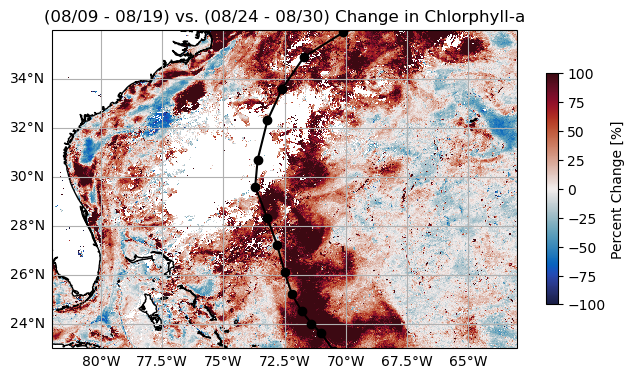

In [15]:
# Plot percent change during long post-event window
fig,ax = plt.subplots(1, 1, figsize=(7.5, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})

plot = storm_data[event_name]["chl_pct_chng"].plot(x="longitude", y="latitude" , cbar_kwargs={'label': 'Percent Change [%]', 'shrink':0.5}, cmap=cmocean.cm.balance, extend = "neither", ax=ax, robust=True, vmin=-100, vmax=100)
ax.plot(storm_data[event_name]["track"]['Longitude'], storm_data[event_name]["track"]['Latitude'], color='black', marker='o', transform=ccrs.PlateCarree(), label='Observed Track')

ax.set_xlim(storm_data[event_name]["bbox"][0],storm_data[event_name]["bbox"][2])
ax.set_ylim(storm_data[event_name]["bbox"][1],storm_data[event_name]["bbox"][3])
ax.coastlines()
# Convert pre and post event times to readable format for title
pre_start_str = pd.to_datetime(storm_data[event_name]["pre_tspan"][0]).strftime('%m/%d')
pre_end_str = pd.to_datetime(storm_data[event_name]["pre_tspan"][1]).strftime('%m/%d')
post_start_str = pd.to_datetime(storm_data[event_name]["post_tspan"][0]).strftime('%m/%d')
post_end_str = pd.to_datetime(storm_data[event_name]["post_tspan"][1]).strftime('%m/%d')
ax.set_title(f'({pre_start_str} - {pre_end_str}) vs. ({post_start_str} - {post_end_str}) Change in Chlorphyll-a')

# Save figure
#plt.savefig(f'{output_path}/ErinChlaChange.png', dpi=300, bbox_inches='tight')

In [16]:
# compare the pre and post event data. first, mask both to only pixels where data is available before and after the hurricane
# then, mask each where it's values are greater or less than

# Calculate mean over pre and post event periods
pre_mean = storm_data[event_name]["data_avw"].sel(time=slice(storm_data[event_name]["pre_tspan"][0], storm_data[event_name]["pre_tspan"][1])).mean("time")
post_mean = storm_data[event_name]["data_avw"].sel(time=slice(storm_data[event_name]["post_tspan"][0], storm_data[event_name]["post_tspan"][1])).mean("time") 

# Create a mask where both datasets have valid values
masklong = ~np.isnan(post_mean) & ~np.isnan(pre_mean)

# Apply masks to datasets
# Calculate percent change over pre and post event periods during the post-event window
pre_mean_mask = pre_mean.where(masklong)
post_mean_mask = post_mean.where(masklong)
post_pct_change = post_mean_mask-pre_mean_mask
storm_data[event_name]["avw_diff"] = post_pct_change


Text(0.5, 1.0, '(08/09 - 08/19) vs. (08/24 - 08/30) Change in AVW')

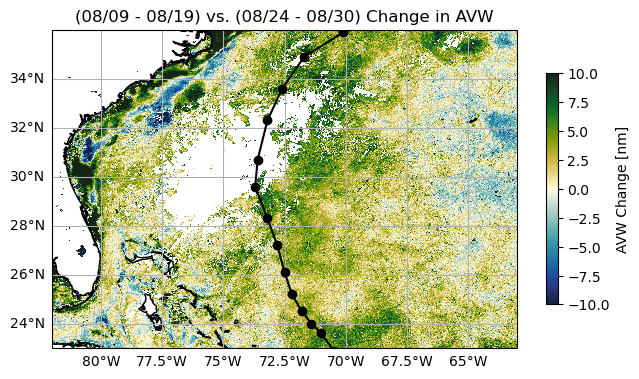

In [17]:
# Plot percent change during long post-event window
fig,ax = plt.subplots(1, 1, figsize=(7.5, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = storm_data[event_name]["avw_diff"].plot(x="longitude", y="latitude" , cbar_kwargs={'label': 'AVW Change [nm]', 'shrink':0.5}, cmap=cmocean.cm.delta, extend = "neither", ax=ax, robust=True, vmin=-10, vmax=10)
ax.plot(storm_data[event_name]["track"]['Longitude'], storm_data[event_name]["track"]['Latitude'], color='black', marker='o', transform=ccrs.PlateCarree(), label='Observed Track')
ax.set_xlim(storm_data[event_name]["bbox"][0],storm_data[event_name]["bbox"][2])
ax.set_ylim(storm_data[event_name]["bbox"][1],storm_data[event_name]["bbox"][3])
ax.coastlines()
# Convert pre and post event times to readable format for title
pre_start_str = pd.to_datetime(storm_data[event_name]["pre_tspan"][0]).strftime('%m/%d')
pre_end_str = pd.to_datetime(storm_data[event_name]["pre_tspan"][1]).strftime('%m/%d')
post_start_str = pd.to_datetime(storm_data[event_name]["post_tspan"][0]).strftime('%m/%d')
post_end_str = pd.to_datetime(storm_data[event_name]["post_tspan"][1]).strftime('%m/%d')
ax.set_title(f'({pre_start_str} - {pre_end_str}) vs. ({post_start_str} - {post_end_str}) Change in AVW')

# Save figure
#plt.savefig(f'{output_path}/ErinAVWChange.png', dpi=300, bbox_inches='tight')

In [18]:
storm_data[event_name]["dataset_MOANA"] = xr.open_mfdataset(paths_MOANA, preprocess=time_from_attr_L4MOANNA, combine='nested', concat_dim='time')
storm_data[event_name]["dataset_BGC"] = xr.open_mfdataset(paths_bgc_L3, preprocess=time_from_attr_L4MOANNA, combine='nested', concat_dim='time')
storm_data[event_name]["dataset_sst"] = xr.open_mfdataset(paths_sst, preprocess=time_from_attr_sst, combine='nested', concat_dim='time')

#Add 2025-08-23 to dataset with NaNs since missing due to safehold
gap_ds = storm_data[event_name]["dataset_MOANA"].isel(time=-1).copy()
# Set all data variables to NaN arrays (float dtype)
for var in gap_ds.data_vars:
    shape = gap_ds[var].shape
    gap_ds[var] = (gap_ds[var].dims, np.full(shape, np.nan, dtype=float))
gap_ds = gap_ds.assign_coords(time=[np.datetime64('2025-08-23')])
storm_data[event_name]["dataset_MOANA"] = xr.concat([storm_data[event_name]["dataset_MOANA"], gap_ds], dim='time')
storm_data[event_name]["dataset_MOANA"] = storm_data[event_name]["dataset_MOANA"].sortby('time')

# Set SST time variables to midnight for consistency
storm_data[event_name]["dataset_sst"] = storm_data[event_name]["dataset_sst"].assign_coords(time=storm_data[event_name]["dataset_sst"]['time'].dt.floor('D'))

# Get min/max values of L4 dataset within bounding box coordinates for later plotting
date_str = [str(date) for date in storm_data[event_name]["dataset_MOANA"]["time"].dt.date.values]

# Calculate 2-day coarsened mean of L3 & L4M data products
storm_data[event_name]["MOANA_mean_2"] = storm_data[event_name]["dataset_MOANA"].coarsen(time=2, boundary='trim').mean()
storm_data[event_name]["BGC_mean_2"] = storm_data[event_name]["dataset_BGC"].coarsen(time=2, boundary='trim').mean()

# Print time values to verify they are consistent between datasets
print(storm_data[event_name]["dataset_MOANA"].time.values)
print(storm_data[event_name]["dataset_BGC"].time.values)
print(storm_data[event_name]["dataset_sst"].time.values)

['2025-08-09T00:00:00' '2025-08-10T00:00:00' '2025-08-11T00:00:00'
 '2025-08-12T00:00:00' '2025-08-13T00:00:00' '2025-08-14T00:00:00'
 '2025-08-15T00:00:00' '2025-08-16T00:00:00' '2025-08-17T00:00:00'
 '2025-08-18T00:00:00' '2025-08-19T00:00:00' '2025-08-20T00:00:00'
 '2025-08-21T00:00:00' '2025-08-22T00:00:00' '2025-08-23T00:00:00'
 '2025-08-24T00:00:00' '2025-08-25T00:00:00' '2025-08-26T00:00:00'
 '2025-08-27T00:00:00' '2025-08-28T00:00:00' '2025-08-29T00:00:00'
 '2025-08-30T00:00:00']
['2025-08-09T00:00:00' '2025-08-10T00:00:00' '2025-08-11T00:00:00'
 '2025-08-12T00:00:00' '2025-08-13T00:00:00' '2025-08-14T00:00:00'
 '2025-08-15T00:00:00' '2025-08-16T00:00:00' '2025-08-17T00:00:00'
 '2025-08-18T00:00:00' '2025-08-19T00:00:00' '2025-08-20T00:00:00'
 '2025-08-21T00:00:00' '2025-08-22T00:00:00' '2025-08-23T00:00:00'
 '2025-08-24T00:00:00' '2025-08-25T00:00:00' '2025-08-26T00:00:00'
 '2025-08-27T00:00:00' '2025-08-28T00:00:00' '2025-08-29T00:00:00'
 '2025-08-30T00:00:00']
['2025-08-09T0

/Users/mkehrli/miniforge3/envs/hackweek/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/mkehrli/miniforge3/envs/hackweek/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/mkehrli/miniforge3/envs/hackweek/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/mkehrli/miniforge3/envs/hackweek/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/mkehrli/miniforge3/envs/hackweek/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/mkehrli/miniforge3/envs/hackweek/lib/python3.12/site-packages/dask/array/numpy_compat.py

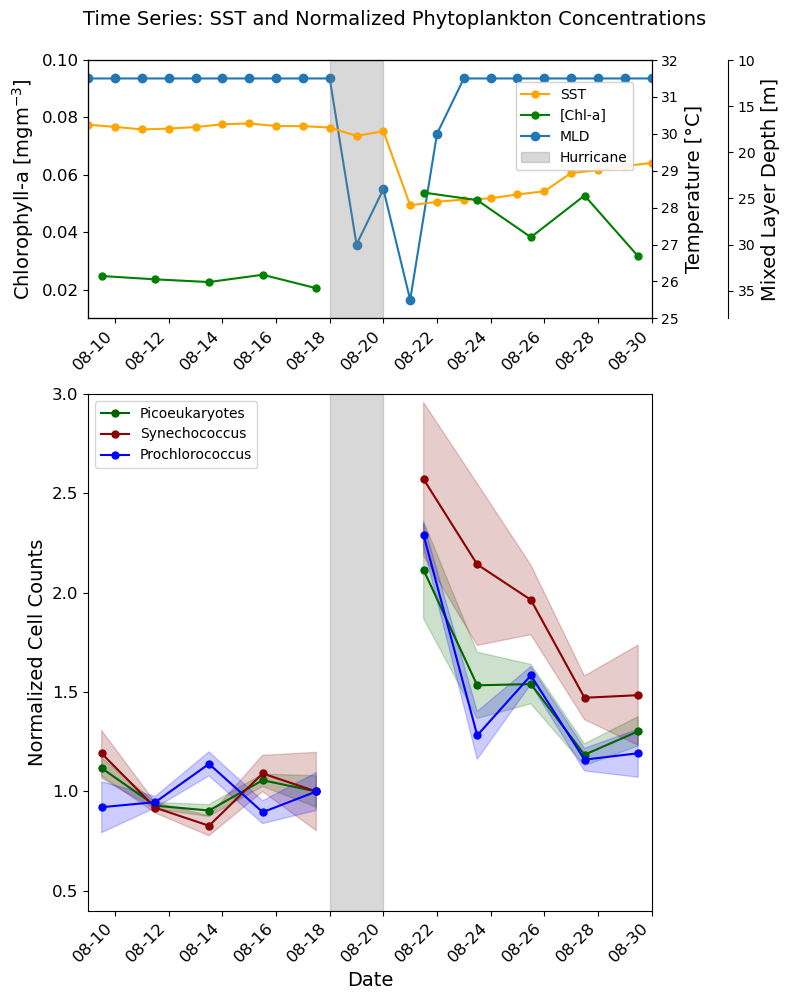

/Users/mkehrli/miniforge3/envs/hackweek/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/mkehrli/miniforge3/envs/hackweek/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/mkehrli/miniforge3/envs/hackweek/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/mkehrli/miniforge3/envs/hackweek/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/mkehrli/miniforge3/envs/hackweek/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/mkehrli/miniforge3/envs/hackweek/lib/python3.12/site-packages/dask/array/numpy_compat.py

In [19]:
# Normalize phytoplankton functional type plots to day before event

# Find the nearest point to the target lat/lon coordinates
datanear =  storm_data[event_name]["MOANA_mean_2"].sel(lat=storm_data[event_name]["target_point"][0], lon=storm_data[event_name]["target_point"][1], method='nearest')

# Determine the index of lat/lon to the target coordinate
storm_data[event_name]["MOANA_tar_idx"] = [storm_data[event_name]["MOANA_mean_2"].lat.values.tolist().index(datanear.lat.values), \
                  storm_data[event_name]["MOANA_mean_2"].lon.values.tolist().index(datanear.lon.values)]
# Select adjacent data
storm_data[event_name]["MOANA_data"] = storm_data[event_name]["MOANA_mean_2"].isel(lat=slice(storm_data[event_name]["MOANA_tar_idx"][0]-2, storm_data[event_name]["MOANA_tar_idx"][0]+3), \
                                  lon=slice(storm_data[event_name]["MOANA_tar_idx"][1]-2, storm_data[event_name]["MOANA_tar_idx"][1]+3))
storm_data[event_name]["MOANA_std"] = storm_data[event_name]["dataset_MOANA"].isel(lat=slice(storm_data[event_name]["MOANA_tar_idx"][0]-2, storm_data[event_name]["MOANA_tar_idx"][0]+3), \
                                  lon=slice(storm_data[event_name]["MOANA_tar_idx"][1]-2, storm_data[event_name]["MOANA_tar_idx"][1]+3))

# Calculate the mean of the selected adjacent data
storm_data[event_name]["MOANA_data"] = storm_data[event_name]["MOANA_data"].mean(dim=['lat','lon']) #
storm_data[event_name]["MOANA_std"] = storm_data[event_name]["MOANA_std"].std(dim=['lat','lon'])
storm_data[event_name]["MOANA_std"] = storm_data[event_name]["MOANA_std"].coarsen(time=2, boundary='trim').mean()

###########################BGC Data Extraction########################
# Find the nearest point to the target lat/lon coordinates
datanear =  storm_data[event_name]["BGC_mean_2"].sel(lat=storm_data[event_name]["target_point"][0], lon=storm_data[event_name]["target_point"][1], method='nearest')

# Determine the index of lat/lon to the target coordinate
storm_data[event_name]["BGC_tar_idx"] = [storm_data[event_name]["BGC_mean_2"].lat.values.tolist().index(datanear.lat.values), \
                  storm_data[event_name]["BGC_mean_2"].lon.values.tolist().index(datanear.lon.values)]
# Select adjacent data
storm_data[event_name]["BGC_data"] = storm_data[event_name]["BGC_mean_2"].isel(lat=slice(storm_data[event_name]["BGC_tar_idx"][0]-2, storm_data[event_name]["BGC_tar_idx"][0]+3), \
                                  lon=slice(storm_data[event_name]["BGC_tar_idx"][1]-2, storm_data[event_name]["BGC_tar_idx"][1]+3))
storm_data[event_name]["BGC_std"] = storm_data[event_name]["dataset_BGC"].isel(lat=slice(storm_data[event_name]["BGC_tar_idx"][0]-2, storm_data[event_name]["BGC_tar_idx"][0]+3), \
                                  lon=slice(storm_data[event_name]["BGC_tar_idx"][1]-2, storm_data[event_name]["BGC_tar_idx"][1]+3))

# Calculate the mean of the selected adjacent data
storm_data[event_name]["BGC_data"] = storm_data[event_name]["BGC_data"].mean(dim=['lat','lon']) #
storm_data[event_name]["BGC_std"] = storm_data[event_name]["BGC_std"].std(dim=['lat','lon'])
storm_data[event_name]["BGC_std"] = storm_data[event_name]["BGC_std"].coarsen(time=2, boundary='trim').mean()

#############################SST Data Extraction############################
# Find the nearest point to the target lat/lon coordinates
sst_datanear = storm_data[event_name]["dataset_sst"].sel(lat=target_point[0], lon=target_point[1], method='nearest')

# Determine the index of lat/lon to the target coordinate
sst_tarcoords_idx = [storm_data[event_name]["dataset_sst"].lat.values.tolist().index(sst_datanear.lat.values), \
                     storm_data[event_name]["dataset_sst"].lon.values.tolist().index(sst_datanear.lon.values)]

# Select adjacent data (1x1 pixel grid)
tar1_data_sst = storm_data[event_name]["dataset_sst"].isel(lat=slice(sst_tarcoords_idx[0], sst_tarcoords_idx[0]+1), \
                                 lon=slice(sst_tarcoords_idx[1], sst_tarcoords_idx[1]+1))

# Calculate the mean of the selected adjacent data
storm_data[event_name]["SST_data"] = tar1_data_sst.mean(dim=['lat','lon']) - 273.15  # Convert from Kelvin to Celsius

# Normalize phytoplankton data to the day before the event
storm_data[event_name]["pico_norm"] = storm_data[event_name]["MOANA_data"]['picoeuk_moana'] / storm_data[event_name]["MOANA_data"]['picoeuk_moana'].sel(time=storm_data[event_name]["day_before"],method='nearest')
storm_data[event_name]["sync_norm"] = storm_data[event_name]["MOANA_data"]['syncoccus_moana'] / storm_data[event_name]["MOANA_data"]['syncoccus_moana'].sel(time=storm_data[event_name]["day_before"],method='nearest')
storm_data[event_name]["proc_norm"] = storm_data[event_name]["MOANA_data"]['prococcus_moana'] / storm_data[event_name]["MOANA_data"]['prococcus_moana'].sel(time=storm_data[event_name]["day_before"],method='nearest')

# Normalize standard deviations proportionally
storm_data[event_name]["pico_std_norm"] = storm_data[event_name]["MOANA_std"]['picoeuk_moana'] / storm_data[event_name]["MOANA_data"]['picoeuk_moana'].sel(time=storm_data[event_name]["day_before"],method='nearest')#MOANA_data['picoeuk_moana'].max()
storm_data[event_name]["sync_std_norm"] = storm_data[event_name]["MOANA_std"]['syncoccus_moana'] / storm_data[event_name]["MOANA_data"]['syncoccus_moana'].sel(time=storm_data[event_name]["day_before"],method='nearest')#MOANA_data['syncoccus_moana'].max()
storm_data[event_name]["proc_std_norm"] = storm_data[event_name]["MOANA_std"]['prococcus_moana'] / storm_data[event_name]["MOANA_data"]['prococcus_moana'].sel(time=storm_data[event_name]["day_before"],method='nearest')#MOANA_data['prococcus_moana'].max()

# Create 2x1 subplot layout with different heights
fig, (ax_chl, ax_bottom) = plt.subplots(2, 1, figsize=(8, 10), 
                                         gridspec_kw={'height_ratios': [1, 2]})

# Extract time values
sst_time_values = storm_data[event_name]["SST_data"]['time'].values
moana_time_values = storm_data[event_name]["MOANA_data"]['time'].values
bgc_time_values = storm_data[event_name]["BGC_data"]['time'].values

# Create left y-axis for chlorophyll-a
ax_chl.set_zorder(2)
ax_chl.plot(bgc_time_values, storm_data[event_name]["BGC_data"]['chlor_a'].values, 'o-',
            color=mcolors.CSS4_COLORS['green'], label="[Chl-a]", markersize=5)
# ax_chl.fill_between(bgc_time_values,
#                     (chl_norm - chl_std_norm).values,
#                     (chl_norm + chl_std_norm).values,
#                     color=mcolors.CSS4_COLORS['black'], alpha=0.2)
ax_chl.set_ylabel('Chlorophyll-a [mgm$^{-3}$]', fontsize=14, color=mcolors.CSS4_COLORS['black'])
ax_chl.tick_params(axis='y', labelcolor=mcolors.CSS4_COLORS['black'])
ax_chl.set_ylim(0.01, 0.1)


# Plot 1: SST (top panel)
ax_sst = ax_chl.twinx()
ax_sst.set_zorder(1)
ax_sst.plot(sst_time_values,
            storm_data[event_name]["SST_data"]['analysed_sst'].values,
            'o-',
            color=mcolors.CSS4_COLORS['orange'],
            label="SST",
            markersize=5)
ax_sst.axvspan(np.datetime64(storm_data[event_name]["tp_tspan"][0]), np.datetime64(tp_tspan[1]), 
               color='gray', alpha=0.3, label='Hurricane')
ax_sst.set_ylabel('Temperature [°C]', fontsize=14)
ax_sst.set_ylim(25, 32)
#ax_top.set_ylim(np.floor(SST_data['analysed_sst'].values.min()), np.ceil(SST_data['analysed_sst'].values.max()))



# create 3rd y axis for MLD
mld_data = storm_data[event_name]["hycom_data"].sel(lat=target_point[0], lon=target_point[1], method='nearest').mixed_layer_thickness.values
mld_time = storm_data[event_name]["hycom_data"].sel(lat=target_point[0], lon=target_point[1], method='nearest').time.values

ax_mld = ax_chl.twinx()
ax_mld.set_zorder(0)
ax_mld.invert_yaxis()
#subset.sel(lat=target_point[0], lon = target_point[1], method='nearest').mixed_layer_thickness.plot(ax=ax_mld,)
ax_mld.plot(mld_time, mld_data, 'o-', label='MLD')
ax_mld.spines['right'].set_position(('outward', 55))  # Move right spine outward by 60 points
ax_mld.set_ylabel('Mixed Layer Depth [m]', fontsize=14)
ax_mld.set_ylim(38, 10)

# IMPORTANT: Set patch visibility to control what shows through
# This prevents lower axes from blocking higher ones
ax_chl.patch.set_visible(False)   # Keep background visible for bottom layer
ax_sst.patch.set_visible(False)  # Make background transparent for middle layer
ax_mld.patch.set_visible(True)  # Make background transparent for top layer

# Combine legends from both axes
handles_sst, labels_sst = ax_sst.get_legend_handles_labels()
handles_chl, labels_chl = ax_chl.get_legend_handles_labels()
handles_mld, labels_mld = ax_mld.get_legend_handles_labels()


ax_chl.legend(handles_sst[0:1] + handles_chl + handles_mld + handles_sst[1:2],
              labels_sst[0:1] + labels_chl + labels_mld + labels_sst[1:2],
              bbox_to_anchor=(0.98, 0.94), frameon=True, framealpha=0.9)


# Bottom panel: All normalized phytoplankton on left, chlorophyll on right
# Plot all three phytoplankton on left axis
ax_bottom.plot(moana_time_values, storm_data[event_name]["pico_norm"].values, 'o-',
               color=mcolors.CSS4_COLORS['darkgreen'], label="Picoeukaryotes", markersize=5)
ax_bottom.fill_between(moana_time_values,
                       (storm_data[event_name]["pico_norm"] - storm_data[event_name]["pico_std_norm"]).values,
                       (storm_data[event_name]["pico_norm"] + storm_data[event_name]["pico_std_norm"]).values,
                       color=mcolors.CSS4_COLORS['darkgreen'], alpha=0.2)

ax_bottom.plot(moana_time_values, storm_data[event_name]["sync_norm"].values, 'o-',
               color=mcolors.CSS4_COLORS['darkred'], label="Synechococcus", markersize=5)
ax_bottom.fill_between(moana_time_values,
                       (storm_data[event_name]["sync_norm"] - storm_data[event_name]["sync_std_norm"]).values,
                       (storm_data[event_name]["sync_norm"] + storm_data[event_name]["sync_std_norm"]).values,
                       color=mcolors.CSS4_COLORS['darkred'], alpha=0.2)

ax_bottom.plot(moana_time_values, storm_data[event_name]["proc_norm"].values, 'o-',
               color=mcolors.CSS4_COLORS['blue'], label="Prochlorococcus", markersize=5)
ax_bottom.fill_between(moana_time_values,
                       (storm_data[event_name]["proc_norm"] - storm_data[event_name]["proc_std_norm"]).values,
                       (storm_data[event_name]["proc_norm"] + storm_data[event_name]["proc_std_norm"]).values,
                       color=mcolors.CSS4_COLORS['blue'], alpha=0.2)

ax_bottom.set_ylabel('Normalized Cell Counts', fontsize=14)
ax_bottom.set_ylim(0.4, 3)


# Add event shading
ax_bottom.axvspan(np.datetime64(tp_tspan[0]), np.datetime64(tp_tspan[1]), 
                  color='gray', alpha=0.3)

# Labels and formatting
ax_bottom.set_xlabel('Date', fontsize=14)

# Combine legends from both axes
handles_phyto, labels_phyto = ax_bottom.get_legend_handles_labels()
handles_chl, labels_chl = ax_chl.get_legend_handles_labels()

ax_bottom.legend(handles_phyto,
                 labels_phyto,
                 loc='upper left', frameon=True, framealpha=0.8)

# Format x-axis for both subplots
for axis in [ax_chl, ax_bottom]:
    axis.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    axis.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    axis.xaxis.set_tick_params(labelsize=12)
    axis.yaxis.set_tick_params(labelsize=12)
    axis.set_xlim(np.datetime64(tspan[0]), np.datetime64(tspan[1]))
    plt.setp(axis.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.suptitle('Time Series: SST and Normalized Phytoplankton Concentrations', fontsize=14, y=0.995)
plt.tight_layout()

# Save figure
#plt.savefig(f'{output_path}/MOANA_SST_CHL_TimeSeries_prenorm.png', dpi=300, bbox_inches='tight')

### Ernesto

In [20]:
# Event Timeframes
# Complete event timespan
tspan = ("2024-08-09", "2024-08-30")
# Define pre-event and post-event timespans
pre_tspan = ("2024-08-09", "2024-08-16") 
post_tspan = ("2024-08-17", "2024-08-30") 

# Geographic information for event analysis
# Define latitudes and longitudes for area of interest
# min_lon = -82
# min_lat = 25 
# max_lon = -55
# max_lat = 33 #Old Ernesto ROI

min_lon = -81
min_lat = 23
max_lon = -62
max_lat = 36
# Target point of interest (e.g., storm center along track with high data coverage. Look at data coverage maps to decide))
#target_point = [31.8, -65]

target_point = [30.6, -66.2]
# Define hurricane event timespan at target point
tp_tspan = ('2024-08-15', '2024-08-17')
day_before = '2024-08-13' # for moana normalization

# Name of event for labeling outputs
event_name = "Hurricane_Ernesto"
hurricane_id = 'al052024' # Hurricane ID for getting storm track data from CSU website: https://rammb-data.cira.colostate.edu/tc_realtime/

# Set method for storing data. If working in the cloud and you would like to stream data, set boolean to True. Otherwise, set to False to download and work with data locally.
in_the_cloud = False


In [21]:
# now, attribute all these vars to "Hurricane_Erin" in the main dictionary

storm_data[event_name]["tspan"] = tspan
storm_data[event_name]["pre_tspan"] = pre_tspan
storm_data[event_name]["post_tspan"] = post_tspan
storm_data[event_name]["min_lon"] = min_lon
storm_data[event_name]["min_lat"] = min_lat
storm_data[event_name]["max_lon"] = max_lon
storm_data[event_name]["max_lat"] = max_lat
storm_data[event_name]["target_point"] = target_point
storm_data[event_name]["tp_tspan"] = tp_tspan
storm_data[event_name]["day_before"] = day_before
storm_data[event_name]["hurricane_id"] = hurricane_id


In [22]:
# Setup .ipynb filing using the users inputs

# Add HH:MM:SS (set to noon UTC) to temporal span for SST earthaccess query
tspan_with_time = (f"{tspan[0]} 12:00:00", f"{tspan[1]} 12:00:00")

# Construct bounding box
bbox = (min_lon, min_lat, max_lon, max_lat)
storm_data[event_name]["bbox"] = bbox

# Set path to store data locally if not working in the cloud
data_path = os.path.join(os.getcwd(), "local", event_name, "data")
if in_the_cloud == False:
    os.makedirs(data_path, exist_ok=True)
# Set path to store output images and figures
output_path = os.path.join(os.getcwd(), "local", event_name, "figures")
os.makedirs(output_path, exist_ok=True)

In [23]:
# First, download all data necessary for analysis

# Collect results for all data products of interest

# Surface Reflectance Data (SREF)
results_sref = earthaccess.search_data(
    short_name="PACE_OCI_L2_SFREFL",
    temporal=tspan,
    bounding_box=bbox,
    version="3.1"
)
if len(results_sref) == 0:
    print("No results found for reprocessed surface reflectance data product, searching for near real time product instead.")
    results_sref = earthaccess.search_data(
        short_name="PACE_OCI_L2_SFREFL_NRT",
        temporal=tspan,
        bounding_box=bbox,
        version="3.1"
    )

# Biogeochemical Data (BGC L2)
results_bgc_L2 = earthaccess.search_data(
    short_name="PACE_OCI_L2_BGC",
    temporal=tspan,
    bounding_box=bbox,
    version="3.1"
)
if len(results_bgc_L2) == 0:
    print("No results found for reprocessed biogeochemical data product, searching for near real time product instead.")
    results_bgc_L2 = earthaccess.search_data(
        short_name="PACE_OCI_L2_BGC_NRT",
        temporal=tspan,
        bounding_box=bbox,
        version="3.1"
    )

# Apparent Optical Property Data (AOP L2)
results_aop = earthaccess.search_data(
    short_name="PACE_OCI_L2_AOP",
    temporal=tspan,
    bounding_box=bbox,
    version="3.1"
)
if len(results_aop) == 0:
    print("No results found for reprocessed apparent optical property data product, searching for near real time product instead.")
    results_aop = earthaccess.search_data(
        short_name="PACE_OCI_L2_AOP_NRT",
        temporal=tspan,
        bounding_box=bbox,
        version="3.1"
    )

# MOANA L4 Data
results_MOANA = earthaccess.search_data(
    short_name="PACE_OCI_L4M_MOANA",
    temporal=tspan,
    bounding_box=bbox,
    granule_name="*.DAY.*4km*",
    version="3.1"
)
if len(results_MOANA) == 0:
    print("No results found for reprocessed MOANA L4 data product, searching for near real time product instead.")
    results_MOANA = earthaccess.search_data(
        short_name="PACE_OCI_L4M_MOANA_NRT",
        temporal=tspan,
        bounding_box=bbox,
        granule_name="*.DAY.*4km*",
        version="3.1"
    )

# BGC L3M Chlorophyll Data
results_bgc_L3 = earthaccess.search_data(
    short_name="PACE_OCI_L3M_CHL",
    temporal=tspan,
    bounding_box=bbox,
    granule_name="*.DAY.*4km*",
    version="3.1"
)
if len(results_bgc_L3) == 0:
    print("No results found for reprocessed L3M Chlorophyll data product, searching for near real time product instead.")
    results_bgc_L3 = earthaccess.search_data(
        short_name="PACE_OCI_L3M_CHL_NRT",
        temporal=tspan,
        bounding_box=bbox,
        granule_name="*.DAY.*4km*",
        version="3.1"
    )
    
# Search and download SST data
sst_results = earthaccess.search_data(
    short_name="MUR25-JPL-L4-GLOB-v04.2",
    temporal=tspan_with_time,
)

# Download/stream data from collect search results
if in_the_cloud == True:
    paths_sref = earthaccess.open(results_sref)
    paths_bgc_L2 = earthaccess.open(results_bgc_L2)
    paths_aop = earthaccess.open(results_aop)
    paths_MOANA = earthaccess.open(results_MOANA)
    paths_bgc_L3 = earthaccess.open(results_bgc_L3)
    paths_sst = earthaccess.open(sst_results)
else:
    paths_sref = earthaccess.download(results_sref, local_path=data_path)
    paths_bgc_L2 = earthaccess.download(results_bgc_L2, local_path=data_path)
    paths_aop = earthaccess.download(results_aop, local_path=data_path)
    paths_MOANA = earthaccess.download(results_MOANA, local_path=data_path)
    paths_bgc_L3 = earthaccess.download(results_bgc_L3, local_path=data_path)
    paths_sst = earthaccess.download(sst_results, local_path=data_path)

print("Number of surface reflectance granules: "+str(len(results_sref)))
print("Number of biogeochemical granules: "+str(len(results_bgc_L2)))
print("Number of apparent optical property granules: "+str(len(results_aop)))
print("Number of MOANA L4 granules: "+str(len(results_MOANA)))
print("Number of L3M Chlorophyll granules: "+str(len(results_bgc_L3)))
print("Number of sea surface temperature granules: "+str(len(results_bgc_L3)))

QUEUEING TASKS | :   0%|          | 0/75 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/75 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/75 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/75 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/75 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/75 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/75 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/75 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/75 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/22 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/22 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/22 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/22 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/22 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/22 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/22 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/22 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/22 [00:00<?, ?it/s]

Number of surface reflectance granules: 75
Number of biogeochemical granules: 75
Number of apparent optical property granules: 75
Number of MOANA L4 granules: 22
Number of L3M Chlorophyll granules: 22
Number of sea surface temperature granules: 22


In [24]:
# Close all existing clients
for client in Client._instances:
    client.close()

In [25]:
# Extract the geospatial characteristics from the first file in paths to create merged L2 data products
crs_sref, shape_sref, transform_sref, wl = load_first_SREF(paths_sref[0], "rhos")
crs_bgc, shape_bgc, transform_bgc = load_first(paths_bgc_L2[0], "chlor_a")

In [26]:
# Coregister all granules to common grid
data_chla = coregister_granules(paths_bgc_L2, crs_bgc, shape_bgc, transform_bgc, "chlor_a")

In [27]:
data_avw = coregister_granules(paths_aop, crs_bgc, shape_bgc, transform_bgc, "avw")

In [28]:
# add these l2's to erin dictionary
storm_data[event_name]["data_chla"] = data_chla
storm_data[event_name]["data_avw"] = data_avw
track = get_hurricane_path(hurricane_id)
storm_data[event_name]["track"] = track

In [29]:

#MIXED LAYER DEPTH - from OEL-hosted HYCOM product

hycom_flist = download_MLT_hycom_files(tspan[0], tspan[1], data_path)
hycom_data = xr.open_mfdataset(hycom_flist, concat_dim='time', combine='nested', engine='h5netcdf')# if error here, check that all downloaded files have correct size
hycom_data.coords['lon'] = (hycom_data.coords['lon'] + 180) % 360 - 180
hycom_data = hycom_data.sortby('lon')
hycom_data = hycom_data.sel(
    lat=slice(bbox[1],bbox[3]),
    lon=slice(bbox[0],bbox[2])
)

storm_data[event_name]["hycom_data"] = hycom_data

Error downloading file: 404 Client Error: Not Found for url: https://oceandata.sci.gsfc.nasa.gov/getfile/hycom_ESPC-D-V02.mlt.20240809.nc
Error downloading file: 404 Client Error: Not Found for url: https://oceandata.sci.gsfc.nasa.gov/getfile/hycom_ESPC-D-V02.mlt.20240810.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20240811.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20240812.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20240813.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20240814.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20240815.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20240816.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20240817.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20240818.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20240819.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20240820.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20240821.nc
File already exists,

In [30]:
# compare the pre and post event data. first, mask both to only pixels where data is available before and after the hurricane
# then, mask each where it's values are greater or less than

# Calculate mean over pre and post event periods
pre_mean = storm_data[event_name]["data_chla"].sel(time=slice(storm_data[event_name]["pre_tspan"][0], storm_data[event_name]["pre_tspan"][1])).mean("time")
post_mean = storm_data[event_name]["data_chla"].sel(time=slice(storm_data[event_name]["post_tspan"][0], storm_data[event_name]["post_tspan"][1])).mean("time") 

# # Create a mask where both datasets have valid values
masklong = ~np.isnan(post_mean) & ~np.isnan(pre_mean)

# Apply masks to datasets
# Calculate percent change over pre and post event periods during the post-event window
pre_mean_mask = pre_mean.where(masklong)
post_mean_mask = post_mean.where(masklong)
post_pct_change = (post_mean_mask-pre_mean_mask)/pre_mean_mask * 100

storm_data[event_name]["chl_pct_chng"] = post_pct_change


Text(0.5, 1.0, '(08/09 - 08/16) vs. (08/17 - 08/30) Change in Chlorphyll-a')

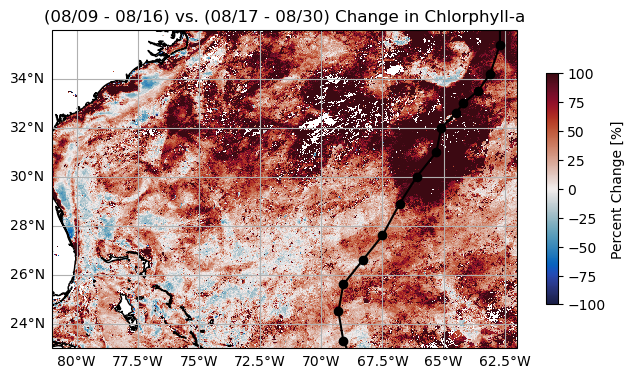

In [31]:
# Plot percent change during long post-event window
fig,ax = plt.subplots(1, 1, figsize=(7.5, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})

plot = storm_data[event_name]["chl_pct_chng"].plot(x="longitude", y="latitude" , cbar_kwargs={'label': 'Percent Change [%]', 'shrink':0.5}, cmap=cmocean.cm.balance, extend = "neither", ax=ax, robust=True, vmin=-100, vmax=100)
ax.plot(storm_data[event_name]["track"]['Longitude'], storm_data[event_name]["track"]['Latitude'], color='black', marker='o', transform=ccrs.PlateCarree(), label='Observed Track')

ax.set_xlim(storm_data[event_name]["bbox"][0],storm_data[event_name]["bbox"][2])
ax.set_ylim(storm_data[event_name]["bbox"][1],storm_data[event_name]["bbox"][3])
ax.coastlines()
# Convert pre and post event times to readable format for title
pre_start_str = pd.to_datetime(storm_data[event_name]["pre_tspan"][0]).strftime('%m/%d')
pre_end_str = pd.to_datetime(storm_data[event_name]["pre_tspan"][1]).strftime('%m/%d')
post_start_str = pd.to_datetime(storm_data[event_name]["post_tspan"][0]).strftime('%m/%d')
post_end_str = pd.to_datetime(storm_data[event_name]["post_tspan"][1]).strftime('%m/%d')
ax.set_title(f'({pre_start_str} - {pre_end_str}) vs. ({post_start_str} - {post_end_str}) Change in Chlorphyll-a')

# Save figure
#plt.savefig(f'{output_path}/ErinChlaChange.png', dpi=300, bbox_inches='tight')

In [32]:
# compare the pre and post event data. first, mask both to only pixels where data is available before and after the hurricane
# then, mask each where it's values are greater or less than

# Calculate mean over pre and post event periods
pre_mean = storm_data[event_name]["data_avw"].sel(time=slice(storm_data[event_name]["pre_tspan"][0], storm_data[event_name]["pre_tspan"][1])).mean("time")
post_mean = storm_data[event_name]["data_avw"].sel(time=slice(storm_data[event_name]["post_tspan"][0], storm_data[event_name]["post_tspan"][1])).mean("time") 

# Create a mask where both datasets have valid values
masklong = ~np.isnan(post_mean) & ~np.isnan(pre_mean)

# Apply masks to datasets
# Calculate percent change over pre and post event periods during the post-event window
pre_mean_mask = pre_mean.where(masklong)
post_mean_mask = post_mean.where(masklong)
post_pct_change = post_mean_mask-pre_mean_mask
storm_data[event_name]["avw_diff"] = post_pct_change


In [33]:
# compare the pre and post event data. first, mask both to only pixels where data is available before and after the hurricane
# then, mask each where it's values are greater or less than

# Calculate mean over pre and post event periods
#pre_mean = storm_data[event_name]["data_avw"].sel(time=slice(storm_data[event_name]["pre_tspan"][0], storm_data[event_name]["pre_tspan"][1])).mean("time")
pre_mean = storm_data[event_name]["data_avw"].sel(time=slice(storm_data[event_name]["pre_tspan"][0], storm_data[event_name]["pre_tspan"][1]))
pre_mean = pre_mean.where(pre_mean != 0).mean("time") # MK edit to remove zeros before calculating mean, since zeros are likely not real values and skewing the mean. Not sure exactly why this bug occurs in MK processing but not in GT processing, regardless, this should take care of the issue.

#post_mean = storm_data[event_name]["data_avw"].sel(time=slice(storm_data[event_name]["post_tspan"][0], storm_data[event_name]["post_tspan"][1])).mean("time") 
post_mean = storm_data[event_name]["data_avw"].sel(time=slice(storm_data[event_name]["post_tspan"][0], storm_data[event_name]["post_tspan"][1]))
post_mean = post_mean.where(post_mean != 0).mean("time") # MK edit to remove zeros before calculating mean, since zeros are likely not real values and skewing the mean. Not sure exactly why this bug occurs in MK processing but not in GT processing, regardless, this should take care of the issue.

# Create a mask where both datasets have valid values
masklong = ~np.isnan(post_mean) & ~np.isnan(pre_mean)

# Apply masks to datasets
# Calculate percent change over pre and post event periods during the post-event window
pre_mean_mask = pre_mean.where(masklong)
post_mean_mask = post_mean.where(masklong)
post_pct_change = post_mean_mask-pre_mean_mask
storm_data[event_name]["avw_diff"] = post_pct_change


In [34]:
storm_data[event_name]["dataset_MOANA"] = xr.open_mfdataset(paths_MOANA, preprocess=time_from_attr_L4MOANNA, combine='nested', concat_dim='time')
storm_data[event_name]["dataset_BGC"] = xr.open_mfdataset(paths_bgc_L3, preprocess=time_from_attr_L4MOANNA, combine='nested', concat_dim='time')
storm_data[event_name]["dataset_sst"] = xr.open_mfdataset(paths_sst, preprocess=time_from_attr_sst, combine='nested', concat_dim='time')

#Add 2025-08-23 to dataset with NaNs since missing due to safehold
# gap_ds = storm_data[event_name]["dataset_MOANA"].isel(time=-1).copy()
# # Set all data variables to NaN arrays (float dtype)
# for var in gap_ds.data_vars:
#     shape = gap_ds[var].shape
#     gap_ds[var] = (gap_ds[var].dims, np.full(shape, np.nan, dtype=float))
# gap_ds = gap_ds.assign_coords(time=[np.datetime64('2025-08-23')])
# storm_data[event_name]["dataset_MOANA"] = xr.concat([storm_data[event_name]["dataset_MOANA"], gap_ds], dim='time')
# storm_data[event_name]["dataset_MOANA"] = storm_data[event_name]["dataset_MOANA"].sortby('time')

# Set SST time variables to midnight for consistency
storm_data[event_name]["dataset_sst"] = storm_data[event_name]["dataset_sst"].assign_coords(time=storm_data[event_name]["dataset_sst"]['time'].dt.floor('D'))

# Get min/max values of L4 dataset within bounding box coordinates for later plotting
date_str = [str(date) for date in storm_data[event_name]["dataset_MOANA"]["time"].dt.date.values]

# Calculate 2-day coarsened mean of L3 & L4M data products
storm_data[event_name]["MOANA_mean_2"] = storm_data[event_name]["dataset_MOANA"].coarsen(time=2, boundary='trim').mean()
storm_data[event_name]["BGC_mean_2"] = storm_data[event_name]["dataset_BGC"].coarsen(time=2, boundary='trim').mean()

# Print time values to verify they are consistent between datasets
print(storm_data[event_name]["dataset_MOANA"].time.values)
print(storm_data[event_name]["dataset_BGC"].time.values)
print(storm_data[event_name]["dataset_sst"].time.values)

['2024-08-09T00:00:00' '2024-08-10T00:00:00' '2024-08-11T00:00:00'
 '2024-08-12T00:00:00' '2024-08-13T00:00:00' '2024-08-14T00:00:00'
 '2024-08-15T00:00:00' '2024-08-16T00:00:00' '2024-08-17T00:00:00'
 '2024-08-18T00:00:00' '2024-08-19T00:00:00' '2024-08-20T00:00:00'
 '2024-08-21T00:00:00' '2024-08-22T00:00:00' '2024-08-23T00:00:00'
 '2024-08-24T00:00:00' '2024-08-25T00:00:00' '2024-08-26T00:00:00'
 '2024-08-27T00:00:00' '2024-08-28T00:00:00' '2024-08-29T00:00:00'
 '2024-08-30T00:00:00']
['2024-08-09T00:00:00' '2024-08-10T00:00:00' '2024-08-11T00:00:00'
 '2024-08-12T00:00:00' '2024-08-13T00:00:00' '2024-08-14T00:00:00'
 '2024-08-15T00:00:00' '2024-08-16T00:00:00' '2024-08-17T00:00:00'
 '2024-08-18T00:00:00' '2024-08-19T00:00:00' '2024-08-20T00:00:00'
 '2024-08-21T00:00:00' '2024-08-22T00:00:00' '2024-08-23T00:00:00'
 '2024-08-24T00:00:00' '2024-08-25T00:00:00' '2024-08-26T00:00:00'
 '2024-08-27T00:00:00' '2024-08-28T00:00:00' '2024-08-29T00:00:00'
 '2024-08-30T00:00:00']
['2024-08-09T0

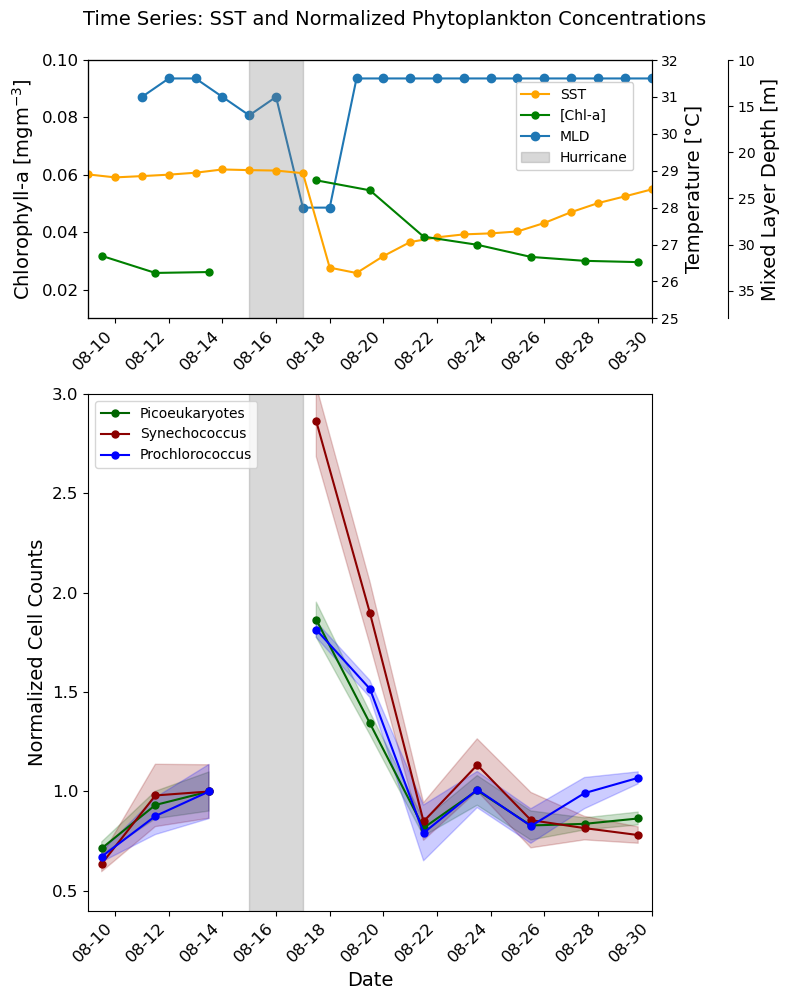

In [35]:
# Normalize phytoplankton functional type plots to day before event

# Find the nearest point to the target lat/lon coordinates
datanear =  storm_data[event_name]["MOANA_mean_2"].sel(lat=storm_data[event_name]["target_point"][0], lon=storm_data[event_name]["target_point"][1], method='nearest')

# Determine the index of lat/lon to the target coordinate
storm_data[event_name]["MOANA_tar_idx"] = [storm_data[event_name]["MOANA_mean_2"].lat.values.tolist().index(datanear.lat.values), \
                  storm_data[event_name]["MOANA_mean_2"].lon.values.tolist().index(datanear.lon.values)]
# Select adjacent data
storm_data[event_name]["MOANA_data"] = storm_data[event_name]["MOANA_mean_2"].isel(lat=slice(storm_data[event_name]["MOANA_tar_idx"][0]-2, storm_data[event_name]["MOANA_tar_idx"][0]+3), \
                                  lon=slice(storm_data[event_name]["MOANA_tar_idx"][1]-2, storm_data[event_name]["MOANA_tar_idx"][1]+3))
storm_data[event_name]["MOANA_std"] = storm_data[event_name]["dataset_MOANA"].isel(lat=slice(storm_data[event_name]["MOANA_tar_idx"][0]-2, storm_data[event_name]["MOANA_tar_idx"][0]+3), \
                                  lon=slice(storm_data[event_name]["MOANA_tar_idx"][1]-2, storm_data[event_name]["MOANA_tar_idx"][1]+3))

# Calculate the mean of the selected adjacent data
storm_data[event_name]["MOANA_data"] = storm_data[event_name]["MOANA_data"].mean(dim=['lat','lon']) #
storm_data[event_name]["MOANA_std"] = storm_data[event_name]["MOANA_std"].std(dim=['lat','lon'])
storm_data[event_name]["MOANA_std"] = storm_data[event_name]["MOANA_std"].coarsen(time=2, boundary='trim').mean()

###########################BGC Data Extraction########################
# Find the nearest point to the target lat/lon coordinates
datanear =  storm_data[event_name]["BGC_mean_2"].sel(lat=storm_data[event_name]["target_point"][0], lon=storm_data[event_name]["target_point"][1], method='nearest')

# Determine the index of lat/lon to the target coordinate
storm_data[event_name]["BGC_tar_idx"] = [storm_data[event_name]["BGC_mean_2"].lat.values.tolist().index(datanear.lat.values), \
                  storm_data[event_name]["BGC_mean_2"].lon.values.tolist().index(datanear.lon.values)]
# Select adjacent data
storm_data[event_name]["BGC_data"] = storm_data[event_name]["BGC_mean_2"].isel(lat=slice(storm_data[event_name]["BGC_tar_idx"][0]-2, storm_data[event_name]["BGC_tar_idx"][0]+3), \
                                  lon=slice(storm_data[event_name]["BGC_tar_idx"][1]-2, storm_data[event_name]["BGC_tar_idx"][1]+3))
storm_data[event_name]["BGC_std"] = storm_data[event_name]["dataset_BGC"].isel(lat=slice(storm_data[event_name]["BGC_tar_idx"][0]-2, storm_data[event_name]["BGC_tar_idx"][0]+3), \
                                  lon=slice(storm_data[event_name]["BGC_tar_idx"][1]-2, storm_data[event_name]["BGC_tar_idx"][1]+3))

# Calculate the mean of the selected adjacent data
storm_data[event_name]["BGC_data"] = storm_data[event_name]["BGC_data"].mean(dim=['lat','lon']) #
storm_data[event_name]["BGC_std"] = storm_data[event_name]["BGC_std"].std(dim=['lat','lon'])
storm_data[event_name]["BGC_std"] = storm_data[event_name]["BGC_std"].coarsen(time=2, boundary='trim').mean()

#############################SST Data Extraction############################
# Find the nearest point to the target lat/lon coordinates
sst_datanear = storm_data[event_name]["dataset_sst"].sel(lat=target_point[0], lon=target_point[1], method='nearest')

# Determine the index of lat/lon to the target coordinate
sst_tarcoords_idx = [storm_data[event_name]["dataset_sst"].lat.values.tolist().index(sst_datanear.lat.values), \
                     storm_data[event_name]["dataset_sst"].lon.values.tolist().index(sst_datanear.lon.values)]

# Select adjacent data (1x1 pixel grid)
tar1_data_sst = storm_data[event_name]["dataset_sst"].isel(lat=slice(sst_tarcoords_idx[0], sst_tarcoords_idx[0]+1), \
                                 lon=slice(sst_tarcoords_idx[1], sst_tarcoords_idx[1]+1))

# Calculate the mean of the selected adjacent data
storm_data[event_name]["SST_data"] = tar1_data_sst.mean(dim=['lat','lon']) - 273.15  # Convert from Kelvin to Celsius

# Normalize phytoplankton data to the day before the event
storm_data[event_name]["pico_norm"] = storm_data[event_name]["MOANA_data"]['picoeuk_moana'] / storm_data[event_name]["MOANA_data"]['picoeuk_moana'].sel(time=storm_data[event_name]["day_before"],method='nearest')
storm_data[event_name]["sync_norm"] = storm_data[event_name]["MOANA_data"]['syncoccus_moana'] / storm_data[event_name]["MOANA_data"]['syncoccus_moana'].sel(time=storm_data[event_name]["day_before"],method='nearest')
storm_data[event_name]["proc_norm"] = storm_data[event_name]["MOANA_data"]['prococcus_moana'] / storm_data[event_name]["MOANA_data"]['prococcus_moana'].sel(time=storm_data[event_name]["day_before"],method='nearest')

# Normalize standard deviations proportionally
storm_data[event_name]["pico_std_norm"] = storm_data[event_name]["MOANA_std"]['picoeuk_moana'] / storm_data[event_name]["MOANA_data"]['picoeuk_moana'].sel(time=storm_data[event_name]["day_before"],method='nearest')#MOANA_data['picoeuk_moana'].max()
storm_data[event_name]["sync_std_norm"] = storm_data[event_name]["MOANA_std"]['syncoccus_moana'] / storm_data[event_name]["MOANA_data"]['syncoccus_moana'].sel(time=storm_data[event_name]["day_before"],method='nearest')#MOANA_data['syncoccus_moana'].max()
storm_data[event_name]["proc_std_norm"] = storm_data[event_name]["MOANA_std"]['prococcus_moana'] / storm_data[event_name]["MOANA_data"]['prococcus_moana'].sel(time=storm_data[event_name]["day_before"],method='nearest')#MOANA_data['prococcus_moana'].max()

# Create 2x1 subplot layout with different heights
fig, (ax_chl, ax_bottom) = plt.subplots(2, 1, figsize=(8, 10), 
                                         gridspec_kw={'height_ratios': [1, 2]})

# Extract time values
sst_time_values = storm_data[event_name]["SST_data"]['time'].values
moana_time_values = storm_data[event_name]["MOANA_data"]['time'].values
bgc_time_values = storm_data[event_name]["BGC_data"]['time'].values

# Create left y-axis for chlorophyll-a
ax_chl.set_zorder(2)
ax_chl.plot(bgc_time_values, storm_data[event_name]["BGC_data"]['chlor_a'].values, 'o-',
            color=mcolors.CSS4_COLORS['green'], label="[Chl-a]", markersize=5)
# ax_chl.fill_between(bgc_time_values,
#                     (chl_norm - chl_std_norm).values,
#                     (chl_norm + chl_std_norm).values,
#                     color=mcolors.CSS4_COLORS['black'], alpha=0.2)
ax_chl.set_ylabel('Chlorophyll-a [mgm$^{-3}$]', fontsize=14, color=mcolors.CSS4_COLORS['black'])
ax_chl.tick_params(axis='y', labelcolor=mcolors.CSS4_COLORS['black'])
ax_chl.set_ylim(0.01, 0.1)


# Plot 1: SST (top panel)
ax_sst = ax_chl.twinx()
ax_sst.set_zorder(1)
ax_sst.plot(sst_time_values,
            storm_data[event_name]["SST_data"]['analysed_sst'].values,
            'o-',
            color=mcolors.CSS4_COLORS['orange'],
            label="SST",
            markersize=5)
ax_sst.axvspan(np.datetime64(storm_data[event_name]["tp_tspan"][0]), np.datetime64(tp_tspan[1]), 
               color='gray', alpha=0.3, label='Hurricane')
ax_sst.set_ylabel('Temperature [°C]', fontsize=14)
ax_sst.set_ylim(25, 32)
#ax_top.set_ylim(np.floor(SST_data['analysed_sst'].values.min()), np.ceil(SST_data['analysed_sst'].values.max()))



# create 3rd y axis for MLD
mld_data = storm_data[event_name]["hycom_data"].sel(lat=target_point[0], lon=target_point[1], method='nearest').mixed_layer_thickness.values
mld_time = storm_data[event_name]["hycom_data"].sel(lat=target_point[0], lon=target_point[1], method='nearest').time.values

ax_mld = ax_chl.twinx()
ax_mld.set_zorder(0)
ax_mld.invert_yaxis()
#subset.sel(lat=target_point[0], lon = target_point[1], method='nearest').mixed_layer_thickness.plot(ax=ax_mld,)
ax_mld.plot(mld_time, mld_data, 'o-', label='MLD')
ax_mld.spines['right'].set_position(('outward', 55))  # Move right spine outward by 60 points
ax_mld.set_ylabel('Mixed Layer Depth [m]', fontsize=14)
ax_mld.set_ylim(38, 10)

# IMPORTANT: Set patch visibility to control what shows through
# This prevents lower axes from blocking higher ones
ax_chl.patch.set_visible(False)   # Keep background visible for bottom layer
ax_sst.patch.set_visible(False)  # Make background transparent for middle layer
ax_mld.patch.set_visible(True)  # Make background transparent for top layer

# Combine legends from both axes
handles_sst, labels_sst = ax_sst.get_legend_handles_labels()
handles_chl, labels_chl = ax_chl.get_legend_handles_labels()
handles_mld, labels_mld = ax_mld.get_legend_handles_labels()


ax_chl.legend(handles_sst[0:1] + handles_chl + handles_mld + handles_sst[1:2],
              labels_sst[0:1] + labels_chl + labels_mld + labels_sst[1:2],
              bbox_to_anchor=(0.98, 0.94), frameon=True, framealpha=0.9)


# Bottom panel: All normalized phytoplankton on left, chlorophyll on right
# Plot all three phytoplankton on left axis
ax_bottom.plot(moana_time_values, storm_data[event_name]["pico_norm"].values, 'o-',
               color=mcolors.CSS4_COLORS['darkgreen'], label="Picoeukaryotes", markersize=5)
ax_bottom.fill_between(moana_time_values,
                       (storm_data[event_name]["pico_norm"] - storm_data[event_name]["pico_std_norm"]).values,
                       (storm_data[event_name]["pico_norm"] + storm_data[event_name]["pico_std_norm"]).values,
                       color=mcolors.CSS4_COLORS['darkgreen'], alpha=0.2)

ax_bottom.plot(moana_time_values, storm_data[event_name]["sync_norm"].values, 'o-',
               color=mcolors.CSS4_COLORS['darkred'], label="Synechococcus", markersize=5)
ax_bottom.fill_between(moana_time_values,
                       (storm_data[event_name]["sync_norm"] - storm_data[event_name]["sync_std_norm"]).values,
                       (storm_data[event_name]["sync_norm"] + storm_data[event_name]["sync_std_norm"]).values,
                       color=mcolors.CSS4_COLORS['darkred'], alpha=0.2)

ax_bottom.plot(moana_time_values, storm_data[event_name]["proc_norm"].values, 'o-',
               color=mcolors.CSS4_COLORS['blue'], label="Prochlorococcus", markersize=5)
ax_bottom.fill_between(moana_time_values,
                       (storm_data[event_name]["proc_norm"] - storm_data[event_name]["proc_std_norm"]).values,
                       (storm_data[event_name]["proc_norm"] + storm_data[event_name]["proc_std_norm"]).values,
                       color=mcolors.CSS4_COLORS['blue'], alpha=0.2)

ax_bottom.set_ylabel('Normalized Cell Counts', fontsize=14)
ax_bottom.set_ylim(0.4, 3)


# Add event shading
ax_bottom.axvspan(np.datetime64(tp_tspan[0]), np.datetime64(tp_tspan[1]), 
                  color='gray', alpha=0.3)

# Labels and formatting
ax_bottom.set_xlabel('Date', fontsize=14)

# Combine legends from both axes
handles_phyto, labels_phyto = ax_bottom.get_legend_handles_labels()
handles_chl, labels_chl = ax_chl.get_legend_handles_labels()

ax_bottom.legend(handles_phyto,
                 labels_phyto,
                 loc='upper left', frameon=True, framealpha=0.8)

# Format x-axis for both subplots
for axis in [ax_chl, ax_bottom]:
    axis.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    axis.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    axis.xaxis.set_tick_params(labelsize=12)
    axis.yaxis.set_tick_params(labelsize=12)
    axis.set_xlim(np.datetime64(tspan[0]), np.datetime64(tspan[1]))
    plt.setp(axis.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.suptitle('Time Series: SST and Normalized Phytoplankton Concentrations', fontsize=14, y=0.995)
plt.tight_layout()

# Save figure
#plt.savefig(f'{output_path}/MOANA_SST_CHL_TimeSeries_prenorm.png', dpi=300, bbox_inches='tight')

### Humberto

In [36]:
# Event Timeframes
# Complete event timespan
tspan = ("2025-09-14", "2025-10-10")
# Define pre-event and post-event timespans
pre_tspan =  ("2025-09-14", "2025-09-26") 
post_tspan = ("2025-09-26", "2025-10-03") 

# Geographic information for event analysis
# Define latitudes and longitudes for area of interest
# min_lon = -67 
# min_lat = 21
# max_lon = -50.5
# max_lat = 26.5 #Old Humberto ROI

min_lon = -74
min_lat = 17
max_lon = -55
max_lat = 30
# Target point of interest (e.g., storm center along track with high data coverage. Look at data coverage maps to decide))
#target_point = [22.2, -57.7] #26th target point for Humberto
#target_point = [22.8, -60.3] #27th target point for Humberto
target_point = [23, -60] #28th target point for Humberto

# Define hurricane event timespan at target point
tp_tspan = ("2025-09-25", "2025-09-28")
day_before = "2025-09-25"

# Name of event for labeling outputs
event_name = "Hurricane_Humberto"
hurricane_id = 'al082025' # Hurricane ID for getting storm track data from CSU website: https://rammb-data.cira.colostate.edu/tc_realtime/

# Set method for storing data. If working in the cloud and you would like to stream data, set boolean to True. Otherwise, set to False to download and work with data locally.
in_the_cloud = False


In [37]:
# now, attribute all these vars to "Hurricane_Erin" in the main dictionary

storm_data[event_name]["tspan"] = tspan
storm_data[event_name]["pre_tspan"] = pre_tspan
storm_data[event_name]["post_tspan"] = post_tspan
storm_data[event_name]["min_lon"] = min_lon
storm_data[event_name]["min_lat"] = min_lat
storm_data[event_name]["max_lon"] = max_lon
storm_data[event_name]["max_lat"] = max_lat
storm_data[event_name]["target_point"] = target_point
storm_data[event_name]["tp_tspan"] = tp_tspan
storm_data[event_name]["day_before"] = day_before
storm_data[event_name]["hurricane_id"] = hurricane_id


In [38]:
# Setup .ipynb filing using the users inputs

# Add HH:MM:SS (set to noon UTC) to temporal span for SST earthaccess query
tspan_with_time = (f"{tspan[0]} 12:00:00", f"{tspan[1]} 12:00:00")

# Construct bounding box
bbox = (min_lon, min_lat, max_lon, max_lat)
storm_data[event_name]["bbox"] = bbox

# Set path to store data locally if not working in the cloud
data_path = os.path.join(os.getcwd(), "local", event_name, "data")
if in_the_cloud == False:
    os.makedirs(data_path, exist_ok=True)
# Set path to store output images and figures
output_path = os.path.join(os.getcwd(), "local", event_name, "figures")
os.makedirs(output_path, exist_ok=True)

In [39]:
# First, download all data necessary for analysis

# Collect results for all data products of interest

# Surface Reflectance Data (SREF)
results_sref = earthaccess.search_data(
    short_name="PACE_OCI_L2_SFREFL",
    temporal=tspan,
    bounding_box=bbox,
    version="3.1"
)
if len(results_sref) == 0:
    print("No results found for reprocessed surface reflectance data product, searching for near real time product instead.")
    results_sref = earthaccess.search_data(
        short_name="PACE_OCI_L2_SFREFL_NRT",
        temporal=tspan,
        bounding_box=bbox,
        version="3.1"
    )

# Biogeochemical Data (BGC L2)
results_bgc_L2 = earthaccess.search_data(
    short_name="PACE_OCI_L2_BGC",
    temporal=tspan,
    bounding_box=bbox,
    version="3.1"
)
if len(results_bgc_L2) == 0:
    print("No results found for reprocessed biogeochemical data product, searching for near real time product instead.")
    results_bgc_L2 = earthaccess.search_data(
        short_name="PACE_OCI_L2_BGC_NRT",
        temporal=tspan,
        bounding_box=bbox,
        version="3.1"
    )

# Apparent Optical Property Data (AOP L2)
results_aop = earthaccess.search_data(
    short_name="PACE_OCI_L2_AOP",
    temporal=tspan,
    bounding_box=bbox,
    version="3.1"
)
if len(results_aop) == 0:
    print("No results found for reprocessed apparent optical property data product, searching for near real time product instead.")
    results_aop = earthaccess.search_data(
        short_name="PACE_OCI_L2_AOP_NRT",
        temporal=tspan,
        bounding_box=bbox,
        version="3.1"
    )

# MOANA L4 Data
results_MOANA = earthaccess.search_data(
    short_name="PACE_OCI_L4M_MOANA",
    temporal=tspan,
    bounding_box=bbox,
    granule_name="*.DAY.*4km*",
    version="3.1"
)
if len(results_MOANA) == 0:
    print("No results found for reprocessed MOANA L4 data product, searching for near real time product instead.")
    results_MOANA = earthaccess.search_data(
        short_name="PACE_OCI_L4M_MOANA_NRT",
        temporal=tspan,
        bounding_box=bbox,
        granule_name="*.DAY.*4km*",
        version="3.1"
    )

# BGC L3M Chlorophyll Data
results_bgc_L3 = earthaccess.search_data(
    short_name="PACE_OCI_L3M_CHL",
    temporal=tspan,
    bounding_box=bbox,
    granule_name="*.DAY.*4km*",
    version="3.1"
)
if len(results_bgc_L3) == 0:
    print("No results found for reprocessed L3M Chlorophyll data product, searching for near real time product instead.")
    results_bgc_L3 = earthaccess.search_data(
        short_name="PACE_OCI_L3M_CHL_NRT",
        temporal=tspan,
        bounding_box=bbox,
        granule_name="*.DAY.*4km*",
        version="3.1"
    )
    
# Search and download SST data
sst_results = earthaccess.search_data(
    short_name="MUR25-JPL-L4-GLOB-v04.2",
    temporal=tspan_with_time,
)

# Download/stream data from collect search results
if in_the_cloud == True:
    paths_sref = earthaccess.open(results_sref)
    paths_bgc_L2 = earthaccess.open(results_bgc_L2)
    paths_aop = earthaccess.open(results_aop)
    paths_MOANA = earthaccess.open(results_MOANA)
    paths_bgc_L3 = earthaccess.open(results_bgc_L3)
    paths_sst = earthaccess.open(sst_results)
else:
    paths_sref = earthaccess.download(results_sref, local_path=data_path)
    paths_bgc_L2 = earthaccess.download(results_bgc_L2, local_path=data_path)
    paths_aop = earthaccess.download(results_aop, local_path=data_path)
    paths_MOANA = earthaccess.download(results_MOANA, local_path=data_path)
    paths_bgc_L3 = earthaccess.download(results_bgc_L3, local_path=data_path)
    paths_sst = earthaccess.download(sst_results, local_path=data_path)

print("Number of surface reflectance granules: "+str(len(results_sref)))
print("Number of biogeochemical granules: "+str(len(results_bgc_L2)))
print("Number of apparent optical property granules: "+str(len(results_aop)))
print("Number of MOANA L4 granules: "+str(len(results_MOANA)))
print("Number of L3M Chlorophyll granules: "+str(len(results_bgc_L3)))
print("Number of sea surface temperature granules: "+str(len(results_bgc_L3)))

QUEUEING TASKS | :   0%|          | 0/104 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/104 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/104 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/104 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/104 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/104 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/104 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/104 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/104 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/27 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/27 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/27 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/27 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/27 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/27 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/27 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/27 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/27 [00:00<?, ?it/s]

Number of surface reflectance granules: 104
Number of biogeochemical granules: 104
Number of apparent optical property granules: 104
Number of MOANA L4 granules: 27
Number of L3M Chlorophyll granules: 27
Number of sea surface temperature granules: 27


In [40]:
# Close all existing clients
for client in Client._instances:
    client.close()

In [41]:
# Extract the geospatial characteristics from the first file in paths to create merged L2 data products
crs_sref, shape_sref, transform_sref, wl = load_first_SREF(paths_sref[0], "rhos")
crs_bgc, shape_bgc, transform_bgc = load_first(paths_bgc_L2[0], "chlor_a")

In [42]:
# Coregister all granules to common grid
data_chla = coregister_granules(paths_bgc_L2, crs_bgc, shape_bgc, transform_bgc, "chlor_a")

In [43]:
data_avw = coregister_granules(paths_aop, crs_bgc, shape_bgc, transform_bgc, "avw")

In [44]:
# add these l2's to erin dictionary
storm_data[event_name]["data_chla"] = data_chla
storm_data[event_name]["data_avw"] = data_avw
track = get_hurricane_path(hurricane_id)
storm_data[event_name]["track"] = track

In [45]:

#MIXED LAYER DEPTH - from OEL-hosted HYCOM product

hycom_flist = download_MLT_hycom_files(tspan[0], tspan[1], data_path)
hycom_data = xr.open_mfdataset(hycom_flist, concat_dim='time', combine='nested', engine='h5netcdf')# if error here, check that all downloaded files have correct size
hycom_data.coords['lon'] = (hycom_data.coords['lon'] + 180) % 360 - 180
hycom_data = hycom_data.sortby('lon')
hycom_data = hycom_data.sel(
    lat=slice(bbox[1],bbox[3]),
    lon=slice(bbox[0],bbox[2])
)

storm_data[event_name]["hycom_data"] = hycom_data

File already exists, skipping: hycom_ESPC-D-V02.mlt.20250914.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250915.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250916.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250917.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250918.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250919.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250920.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250921.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250922.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250923.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250924.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250925.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250926.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250927.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20250928.nc
File already exists, skipping: hycom_ESP

In [46]:
# compare the pre and post event data. first, mask both to only pixels where data is available before and after the hurricane
# then, mask each where it's values are greater or less than

# Calculate mean over pre and post event periods
pre_mean = storm_data[event_name]["data_chla"].sel(time=slice(storm_data[event_name]["pre_tspan"][0], storm_data[event_name]["pre_tspan"][1])).mean("time")
post_mean = storm_data[event_name]["data_chla"].sel(time=slice(storm_data[event_name]["post_tspan"][0], storm_data[event_name]["post_tspan"][1])).mean("time") 

# # Create a mask where both datasets have valid values
masklong = ~np.isnan(post_mean) & ~np.isnan(pre_mean)

# Apply masks to datasets
# Calculate percent change over pre and post event periods during the post-event window
pre_mean_mask = pre_mean.where(masklong)
post_mean_mask = post_mean.where(masklong)
post_pct_change = (post_mean_mask-pre_mean_mask)/pre_mean_mask * 100

storm_data[event_name]["chl_pct_chng"] = post_pct_change


Text(0.5, 1.0, '(09/14 - 09/26) vs. (09/26 - 10/03) Change in Chlorphyll-a')

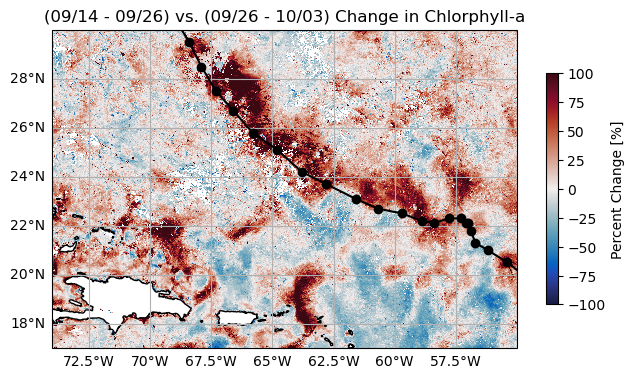

In [47]:
# Plot percent change during long post-event window
fig,ax = plt.subplots(1, 1, figsize=(7.5, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})

plot = storm_data[event_name]["chl_pct_chng"].plot(x="longitude", y="latitude" , cbar_kwargs={'label': 'Percent Change [%]', 'shrink':0.5}, cmap=cmocean.cm.balance, extend = "neither", ax=ax, robust=True, vmin=-100, vmax=100)
ax.plot(storm_data[event_name]["track"]['Longitude'], storm_data[event_name]["track"]['Latitude'], color='black', marker='o', transform=ccrs.PlateCarree(), label='Observed Track')

ax.set_xlim(storm_data[event_name]["bbox"][0],storm_data[event_name]["bbox"][2])
ax.set_ylim(storm_data[event_name]["bbox"][1],storm_data[event_name]["bbox"][3])
ax.coastlines()
# Convert pre and post event times to readable format for title
pre_start_str = pd.to_datetime(storm_data[event_name]["pre_tspan"][0]).strftime('%m/%d')
pre_end_str = pd.to_datetime(storm_data[event_name]["pre_tspan"][1]).strftime('%m/%d')
post_start_str = pd.to_datetime(storm_data[event_name]["post_tspan"][0]).strftime('%m/%d')
post_end_str = pd.to_datetime(storm_data[event_name]["post_tspan"][1]).strftime('%m/%d')
ax.set_title(f'({pre_start_str} - {pre_end_str}) vs. ({post_start_str} - {post_end_str}) Change in Chlorphyll-a')

# Save figure
#plt.savefig(f'{output_path}/ErinChlaChange.png', dpi=300, bbox_inches='tight')

In [48]:
# compare the pre and post event data. first, mask both to only pixels where data is available before and after the hurricane
# then, mask each where it's values are greater or less than

# Calculate mean over pre and post event periods
pre_mean = storm_data[event_name]["data_avw"].sel(time=slice(storm_data[event_name]["pre_tspan"][0], storm_data[event_name]["pre_tspan"][1])).mean("time")
post_mean = storm_data[event_name]["data_avw"].sel(time=slice(storm_data[event_name]["post_tspan"][0], storm_data[event_name]["post_tspan"][1])).mean("time") 

# Create a mask where both datasets have valid values
masklong = ~np.isnan(post_mean) & ~np.isnan(pre_mean)

# Apply masks to datasets
# Calculate percent change over pre and post event periods during the post-event window
pre_mean_mask = pre_mean.where(masklong)
post_mean_mask = post_mean.where(masklong)
post_pct_change = post_mean_mask-pre_mean_mask
storm_data[event_name]["avw_diff"] = post_pct_change


Text(0.5, 1.0, '(09/14 - 09/26) vs. (09/26 - 10/03) Change in AVW')

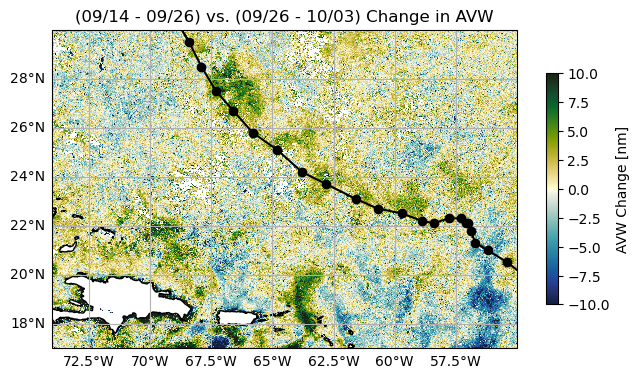

In [49]:
# Plot percent change during long post-event window
fig,ax = plt.subplots(1, 1, figsize=(7.5, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = storm_data[event_name]["avw_diff"].plot(x="longitude", y="latitude" , cbar_kwargs={'label': 'AVW Change [nm]', 'shrink':0.5}, cmap=cmocean.cm.delta, extend = "neither", ax=ax, robust=True, vmin=-10, vmax=10)
ax.plot(storm_data[event_name]["track"]['Longitude'], storm_data[event_name]["track"]['Latitude'], color='black', marker='o', transform=ccrs.PlateCarree(), label='Observed Track')
ax.set_xlim(storm_data[event_name]["bbox"][0],storm_data[event_name]["bbox"][2])
ax.set_ylim(storm_data[event_name]["bbox"][1],storm_data[event_name]["bbox"][3])
ax.coastlines()
# Convert pre and post event times to readable format for title
pre_start_str = pd.to_datetime(storm_data[event_name]["pre_tspan"][0]).strftime('%m/%d')
pre_end_str = pd.to_datetime(storm_data[event_name]["pre_tspan"][1]).strftime('%m/%d')
post_start_str = pd.to_datetime(storm_data[event_name]["post_tspan"][0]).strftime('%m/%d')
post_end_str = pd.to_datetime(storm_data[event_name]["post_tspan"][1]).strftime('%m/%d')
ax.set_title(f'({pre_start_str} - {pre_end_str}) vs. ({post_start_str} - {post_end_str}) Change in AVW')

# Save figure
#plt.savefig(f'{output_path}/ErinAVWChange.png', dpi=300, bbox_inches='tight')

In [50]:
storm_data[event_name]["dataset_MOANA"] = xr.open_mfdataset(paths_MOANA, preprocess=time_from_attr_L4MOANNA, combine='nested', concat_dim='time')
storm_data[event_name]["dataset_BGC"] = xr.open_mfdataset(paths_bgc_L3, preprocess=time_from_attr_L4MOANNA, combine='nested', concat_dim='time')
storm_data[event_name]["dataset_sst"] = xr.open_mfdataset(paths_sst, preprocess=time_from_attr_sst, combine='nested', concat_dim='time')

#Add 2025-08-23 to dataset with NaNs since missing due to safehold
# gap_ds = storm_data[event_name]["dataset_MOANA"].isel(time=-1).copy()
# # Set all data variables to NaN arrays (float dtype)
# for var in gap_ds.data_vars:
#     shape = gap_ds[var].shape
#     gap_ds[var] = (gap_ds[var].dims, np.full(shape, np.nan, dtype=float))
# gap_ds = gap_ds.assign_coords(time=[np.datetime64('2025-08-23')])
# storm_data[event_name]["dataset_MOANA"] = xr.concat([storm_data[event_name]["dataset_MOANA"], gap_ds], dim='time')
# storm_data[event_name]["dataset_MOANA"] = storm_data[event_name]["dataset_MOANA"].sortby('time')

# Set SST time variables to midnight for consistency
storm_data[event_name]["dataset_sst"] = storm_data[event_name]["dataset_sst"].assign_coords(time=storm_data[event_name]["dataset_sst"]['time'].dt.floor('D'))

# Get min/max values of L4 dataset within bounding box coordinates for later plotting
date_str = [str(date) for date in storm_data[event_name]["dataset_MOANA"]["time"].dt.date.values]

# Calculate 2-day coarsened mean of L3 & L4M data products
storm_data[event_name]["MOANA_mean_2"] = storm_data[event_name]["dataset_MOANA"].coarsen(time=2, boundary='trim').mean()
storm_data[event_name]["BGC_mean_2"] = storm_data[event_name]["dataset_BGC"].coarsen(time=2, boundary='trim').mean()

# Print time values to verify they are consistent between datasets
print(storm_data[event_name]["dataset_MOANA"].time.values)
print(storm_data[event_name]["dataset_BGC"].time.values)
print(storm_data[event_name]["dataset_sst"].time.values)

['2025-09-14T00:00:00' '2025-09-15T00:00:00' '2025-09-16T00:00:00'
 '2025-09-17T00:00:00' '2025-09-18T00:00:00' '2025-09-19T00:00:00'
 '2025-09-20T00:00:00' '2025-09-21T00:00:00' '2025-09-22T00:00:00'
 '2025-09-23T00:00:00' '2025-09-24T00:00:00' '2025-09-25T00:00:00'
 '2025-09-26T00:00:00' '2025-09-27T00:00:00' '2025-09-28T00:00:00'
 '2025-09-29T00:00:00' '2025-09-30T00:00:00' '2025-10-01T00:00:00'
 '2025-10-02T00:00:00' '2025-10-03T00:00:00' '2025-10-04T00:00:00'
 '2025-10-05T00:00:00' '2025-10-06T00:00:00' '2025-10-07T00:00:00'
 '2025-10-08T00:00:00' '2025-10-09T00:00:00' '2025-10-10T00:00:00']
['2025-09-14T00:00:00' '2025-09-15T00:00:00' '2025-09-16T00:00:00'
 '2025-09-17T00:00:00' '2025-09-18T00:00:00' '2025-09-19T00:00:00'
 '2025-09-20T00:00:00' '2025-09-21T00:00:00' '2025-09-22T00:00:00'
 '2025-09-23T00:00:00' '2025-09-24T00:00:00' '2025-09-25T00:00:00'
 '2025-09-26T00:00:00' '2025-09-27T00:00:00' '2025-09-28T00:00:00'
 '2025-09-29T00:00:00' '2025-09-30T00:00:00' '2025-10-01T00:0

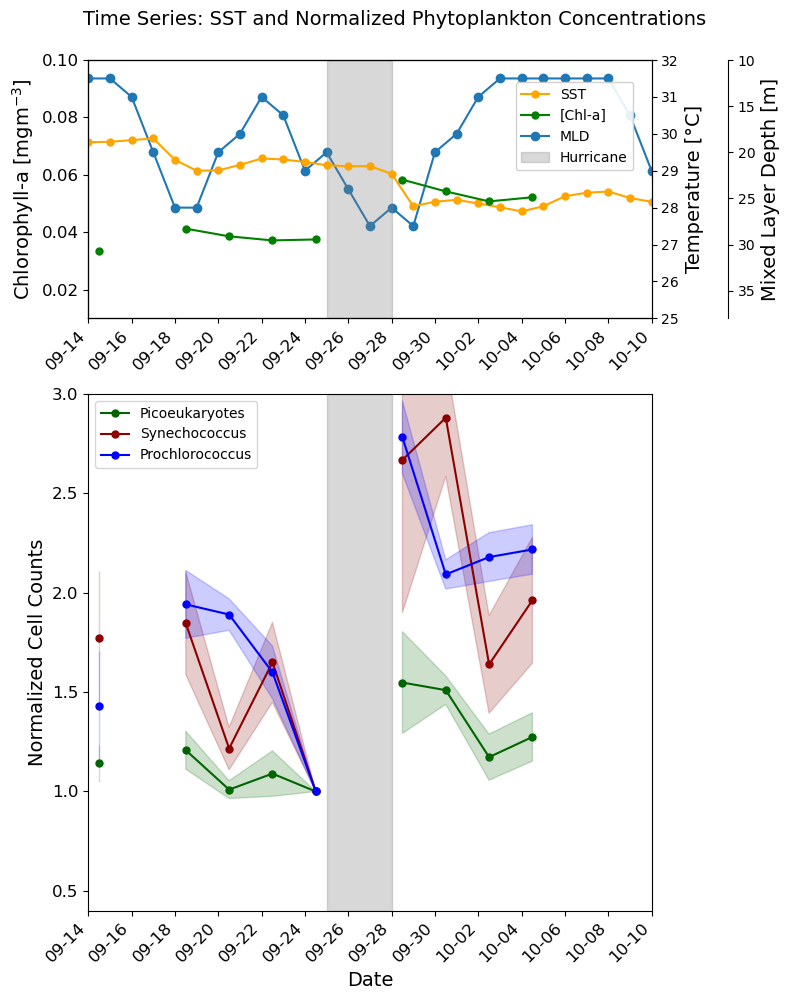

In [51]:
# Normalize phytoplankton functional type plots to day before event

# Find the nearest point to the target lat/lon coordinates
datanear =  storm_data[event_name]["MOANA_mean_2"].sel(lat=storm_data[event_name]["target_point"][0], lon=storm_data[event_name]["target_point"][1], method='nearest')

# Determine the index of lat/lon to the target coordinate
storm_data[event_name]["MOANA_tar_idx"] = [storm_data[event_name]["MOANA_mean_2"].lat.values.tolist().index(datanear.lat.values), \
                  storm_data[event_name]["MOANA_mean_2"].lon.values.tolist().index(datanear.lon.values)]
# Select adjacent data
storm_data[event_name]["MOANA_data"] = storm_data[event_name]["MOANA_mean_2"].isel(lat=slice(storm_data[event_name]["MOANA_tar_idx"][0]-2, storm_data[event_name]["MOANA_tar_idx"][0]+3), \
                                  lon=slice(storm_data[event_name]["MOANA_tar_idx"][1]-2, storm_data[event_name]["MOANA_tar_idx"][1]+3))
storm_data[event_name]["MOANA_std"] = storm_data[event_name]["dataset_MOANA"].isel(lat=slice(storm_data[event_name]["MOANA_tar_idx"][0]-2, storm_data[event_name]["MOANA_tar_idx"][0]+3), \
                                  lon=slice(storm_data[event_name]["MOANA_tar_idx"][1]-2, storm_data[event_name]["MOANA_tar_idx"][1]+3))

# Calculate the mean of the selected adjacent data
storm_data[event_name]["MOANA_data"] = storm_data[event_name]["MOANA_data"].mean(dim=['lat','lon']) #
storm_data[event_name]["MOANA_std"] = storm_data[event_name]["MOANA_std"].std(dim=['lat','lon'])
storm_data[event_name]["MOANA_std"] = storm_data[event_name]["MOANA_std"].coarsen(time=2, boundary='trim').mean()

###########################BGC Data Extraction########################
# Find the nearest point to the target lat/lon coordinates
datanear =  storm_data[event_name]["BGC_mean_2"].sel(lat=storm_data[event_name]["target_point"][0], lon=storm_data[event_name]["target_point"][1], method='nearest')

# Determine the index of lat/lon to the target coordinate
storm_data[event_name]["BGC_tar_idx"] = [storm_data[event_name]["BGC_mean_2"].lat.values.tolist().index(datanear.lat.values), \
                  storm_data[event_name]["BGC_mean_2"].lon.values.tolist().index(datanear.lon.values)]
# Select adjacent data
storm_data[event_name]["BGC_data"] = storm_data[event_name]["BGC_mean_2"].isel(lat=slice(storm_data[event_name]["BGC_tar_idx"][0]-2, storm_data[event_name]["BGC_tar_idx"][0]+3), \
                                  lon=slice(storm_data[event_name]["BGC_tar_idx"][1]-2, storm_data[event_name]["BGC_tar_idx"][1]+3))
storm_data[event_name]["BGC_std"] = storm_data[event_name]["dataset_BGC"].isel(lat=slice(storm_data[event_name]["BGC_tar_idx"][0]-2, storm_data[event_name]["BGC_tar_idx"][0]+3), \
                                  lon=slice(storm_data[event_name]["BGC_tar_idx"][1]-2, storm_data[event_name]["BGC_tar_idx"][1]+3))

# Calculate the mean of the selected adjacent data
storm_data[event_name]["BGC_data"] = storm_data[event_name]["BGC_data"].mean(dim=['lat','lon']) #
storm_data[event_name]["BGC_std"] = storm_data[event_name]["BGC_std"].std(dim=['lat','lon'])
storm_data[event_name]["BGC_std"] = storm_data[event_name]["BGC_std"].coarsen(time=2, boundary='trim').mean()

#############################SST Data Extraction############################
# Find the nearest point to the target lat/lon coordinates
sst_datanear = storm_data[event_name]["dataset_sst"].sel(lat=target_point[0], lon=target_point[1], method='nearest')

# Determine the index of lat/lon to the target coordinate
sst_tarcoords_idx = [storm_data[event_name]["dataset_sst"].lat.values.tolist().index(sst_datanear.lat.values), \
                     storm_data[event_name]["dataset_sst"].lon.values.tolist().index(sst_datanear.lon.values)]

# Select adjacent data (1x1 pixel grid)
tar1_data_sst = storm_data[event_name]["dataset_sst"].isel(lat=slice(sst_tarcoords_idx[0], sst_tarcoords_idx[0]+1), \
                                 lon=slice(sst_tarcoords_idx[1], sst_tarcoords_idx[1]+1))

# Calculate the mean of the selected adjacent data
storm_data[event_name]["SST_data"] = tar1_data_sst.mean(dim=['lat','lon']) - 273.15  # Convert from Kelvin to Celsius

# Normalize phytoplankton data to the day before the event
storm_data[event_name]["pico_norm"] = storm_data[event_name]["MOANA_data"]['picoeuk_moana'] / storm_data[event_name]["MOANA_data"]['picoeuk_moana'].sel(time=storm_data[event_name]["day_before"],method='nearest')
storm_data[event_name]["sync_norm"] = storm_data[event_name]["MOANA_data"]['syncoccus_moana'] / storm_data[event_name]["MOANA_data"]['syncoccus_moana'].sel(time=storm_data[event_name]["day_before"],method='nearest')
storm_data[event_name]["proc_norm"] = storm_data[event_name]["MOANA_data"]['prococcus_moana'] / storm_data[event_name]["MOANA_data"]['prococcus_moana'].sel(time=storm_data[event_name]["day_before"],method='nearest')

# Normalize standard deviations proportionally
storm_data[event_name]["pico_std_norm"] = storm_data[event_name]["MOANA_std"]['picoeuk_moana'] / storm_data[event_name]["MOANA_data"]['picoeuk_moana'].sel(time=storm_data[event_name]["day_before"],method='nearest')#MOANA_data['picoeuk_moana'].max()
storm_data[event_name]["sync_std_norm"] = storm_data[event_name]["MOANA_std"]['syncoccus_moana'] / storm_data[event_name]["MOANA_data"]['syncoccus_moana'].sel(time=storm_data[event_name]["day_before"],method='nearest')#MOANA_data['syncoccus_moana'].max()
storm_data[event_name]["proc_std_norm"] = storm_data[event_name]["MOANA_std"]['prococcus_moana'] / storm_data[event_name]["MOANA_data"]['prococcus_moana'].sel(time=storm_data[event_name]["day_before"],method='nearest')#MOANA_data['prococcus_moana'].max()

# Create 2x1 subplot layout with different heights
fig, (ax_chl, ax_bottom) = plt.subplots(2, 1, figsize=(8, 10), 
                                         gridspec_kw={'height_ratios': [1, 2]})

# Extract time values
sst_time_values = storm_data[event_name]["SST_data"]['time'].values
moana_time_values = storm_data[event_name]["MOANA_data"]['time'].values
bgc_time_values = storm_data[event_name]["BGC_data"]['time'].values

# Create left y-axis for chlorophyll-a
ax_chl.set_zorder(2)
ax_chl.plot(bgc_time_values, storm_data[event_name]["BGC_data"]['chlor_a'].values, 'o-',
            color=mcolors.CSS4_COLORS['green'], label="[Chl-a]", markersize=5)
# ax_chl.fill_between(bgc_time_values,
#                     (chl_norm - chl_std_norm).values,
#                     (chl_norm + chl_std_norm).values,
#                     color=mcolors.CSS4_COLORS['black'], alpha=0.2)
ax_chl.set_ylabel('Chlorophyll-a [mgm$^{-3}$]', fontsize=14, color=mcolors.CSS4_COLORS['black'])
ax_chl.tick_params(axis='y', labelcolor=mcolors.CSS4_COLORS['black'])
ax_chl.set_ylim(0.01, 0.1)


# Plot 1: SST (top panel)
ax_sst = ax_chl.twinx()
ax_sst.set_zorder(1)
ax_sst.plot(sst_time_values,
            storm_data[event_name]["SST_data"]['analysed_sst'].values,
            'o-',
            color=mcolors.CSS4_COLORS['orange'],
            label="SST",
            markersize=5)
ax_sst.axvspan(np.datetime64(storm_data[event_name]["tp_tspan"][0]), np.datetime64(tp_tspan[1]), 
               color='gray', alpha=0.3, label='Hurricane')
ax_sst.set_ylabel('Temperature [°C]', fontsize=14)
ax_sst.set_ylim(25, 32)
#ax_top.set_ylim(np.floor(SST_data['analysed_sst'].values.min()), np.ceil(SST_data['analysed_sst'].values.max()))



# create 3rd y axis for MLD
mld_data = storm_data[event_name]["hycom_data"].sel(lat=target_point[0], lon=target_point[1], method='nearest').mixed_layer_thickness.values
mld_time = storm_data[event_name]["hycom_data"].sel(lat=target_point[0], lon=target_point[1], method='nearest').time.values

ax_mld = ax_chl.twinx()
ax_mld.set_zorder(0)
ax_mld.invert_yaxis()
#subset.sel(lat=target_point[0], lon = target_point[1], method='nearest').mixed_layer_thickness.plot(ax=ax_mld,)
ax_mld.plot(mld_time, mld_data, 'o-', label='MLD')
ax_mld.spines['right'].set_position(('outward', 55))  # Move right spine outward by 60 points
ax_mld.set_ylabel('Mixed Layer Depth [m]', fontsize=14)
ax_mld.set_ylim(38, 10)

# IMPORTANT: Set patch visibility to control what shows through
# This prevents lower axes from blocking higher ones
ax_chl.patch.set_visible(False)   # Keep background visible for bottom layer
ax_sst.patch.set_visible(False)  # Make background transparent for middle layer
ax_mld.patch.set_visible(True)  # Make background transparent for top layer

# Combine legends from both axes
handles_sst, labels_sst = ax_sst.get_legend_handles_labels()
handles_chl, labels_chl = ax_chl.get_legend_handles_labels()
handles_mld, labels_mld = ax_mld.get_legend_handles_labels()


ax_chl.legend(handles_sst[0:1] + handles_chl + handles_mld + handles_sst[1:2],
              labels_sst[0:1] + labels_chl + labels_mld + labels_sst[1:2],
              bbox_to_anchor=(0.98, 0.94), frameon=True, framealpha=0.9)


# Bottom panel: All normalized phytoplankton on left, chlorophyll on right
# Plot all three phytoplankton on left axis
ax_bottom.plot(moana_time_values, storm_data[event_name]["pico_norm"].values, 'o-',
               color=mcolors.CSS4_COLORS['darkgreen'], label="Picoeukaryotes", markersize=5)
ax_bottom.fill_between(moana_time_values,
                       (storm_data[event_name]["pico_norm"] - storm_data[event_name]["pico_std_norm"]).values,
                       (storm_data[event_name]["pico_norm"] + storm_data[event_name]["pico_std_norm"]).values,
                       color=mcolors.CSS4_COLORS['darkgreen'], alpha=0.2)

ax_bottom.plot(moana_time_values, storm_data[event_name]["sync_norm"].values, 'o-',
               color=mcolors.CSS4_COLORS['darkred'], label="Synechococcus", markersize=5)
ax_bottom.fill_between(moana_time_values,
                       (storm_data[event_name]["sync_norm"] - storm_data[event_name]["sync_std_norm"]).values,
                       (storm_data[event_name]["sync_norm"] + storm_data[event_name]["sync_std_norm"]).values,
                       color=mcolors.CSS4_COLORS['darkred'], alpha=0.2)

ax_bottom.plot(moana_time_values, storm_data[event_name]["proc_norm"].values, 'o-',
               color=mcolors.CSS4_COLORS['blue'], label="Prochlorococcus", markersize=5)
ax_bottom.fill_between(moana_time_values,
                       (storm_data[event_name]["proc_norm"] - storm_data[event_name]["proc_std_norm"]).values,
                       (storm_data[event_name]["proc_norm"] + storm_data[event_name]["proc_std_norm"]).values,
                       color=mcolors.CSS4_COLORS['blue'], alpha=0.2)

ax_bottom.set_ylabel('Normalized Cell Counts', fontsize=14)
ax_bottom.set_ylim(0.4, 3)


# Add event shading
ax_bottom.axvspan(np.datetime64(tp_tspan[0]), np.datetime64(tp_tspan[1]), 
                  color='gray', alpha=0.3)

# Labels and formatting
ax_bottom.set_xlabel('Date', fontsize=14)

# Combine legends from both axes
handles_phyto, labels_phyto = ax_bottom.get_legend_handles_labels()
handles_chl, labels_chl = ax_chl.get_legend_handles_labels()

ax_bottom.legend(handles_phyto,
                 labels_phyto,
                 loc='upper left', frameon=True, framealpha=0.8)

# Format x-axis for both subplots
for axis in [ax_chl, ax_bottom]:
    axis.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    axis.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    axis.xaxis.set_tick_params(labelsize=12)
    axis.yaxis.set_tick_params(labelsize=12)
    axis.set_xlim(np.datetime64(tspan[0]), np.datetime64(tspan[1]))
    plt.setp(axis.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.suptitle('Time Series: SST and Normalized Phytoplankton Concentrations', fontsize=14, y=0.995)
plt.tight_layout()

# Save figure
#plt.savefig(f'{output_path}/MOANA_SST_CHL_TimeSeries_prenorm.png', dpi=300, bbox_inches='tight')

### Melissa

In [52]:
# Event Timeframes
# Complete event timespan
tspan = ("2025-10-18", "2025-11-09")
# Define pre-event and post-event timespans
pre_tspan =  ("2025-10-18", "2025-10-28") 
post_tspan = ("2025-10-31", "2025-11-09") 

# Geographic information for event analysis
# Define latitudes and longitudes for area of interest
min_lon = -81
min_lat = 25
max_lon = -62
max_lat = 38
# Target point of interest (e.g., storm center along track with high data coverage. Look at data coverage maps to decide))
target_point = [34.9, -64]#[30.92, -69.96]#[32, -67.5]
# Define hurricane event timespan at target point
tp_tspan = ("2025-10-29", "2025-10-30")
day_before = "2025-10-28"

# Name of event for labeling outputs
event_name = "Hurricane_Melissa"
hurricane_id = 'al132025' # Hurricane ID for getting storm track data from CSU website: https://rammb-data.cira.colostate.edu/tc_realtime/

# Set method for storing data. If working in the cloud and you would like to stream data, set boolean to True. Otherwise, set to False to download and work with data locally.
in_the_cloud = False


In [53]:
# now, attribute all these vars to "Hurricane_Erin" in the main dictionary

storm_data[event_name]["tspan"] = tspan
storm_data[event_name]["pre_tspan"] = pre_tspan
storm_data[event_name]["post_tspan"] = post_tspan
storm_data[event_name]["min_lon"] = min_lon
storm_data[event_name]["min_lat"] = min_lat
storm_data[event_name]["max_lon"] = max_lon
storm_data[event_name]["max_lat"] = max_lat
storm_data[event_name]["target_point"] = target_point
storm_data[event_name]["tp_tspan"] = tp_tspan
storm_data[event_name]["day_before"] = day_before
storm_data[event_name]["hurricane_id"] = hurricane_id


In [54]:
# Setup .ipynb filing using the users inputs

# Add HH:MM:SS (set to noon UTC) to temporal span for SST earthaccess query
tspan_with_time = (f"{tspan[0]} 12:00:00", f"{tspan[1]} 12:00:00")

# Construct bounding box
bbox = (min_lon, min_lat, max_lon, max_lat)
storm_data[event_name]["bbox"] = bbox

# Set path to store data locally if not working in the cloud
data_path = os.path.join(os.getcwd(), "local", event_name, "data")
if in_the_cloud == False:
    os.makedirs(data_path, exist_ok=True)
# Set path to store output images and figures
output_path = os.path.join(os.getcwd(), "local", event_name, "figures")
os.makedirs(output_path, exist_ok=True)

In [55]:
# First, download all data necessary for analysis

# Collect results for all data products of interest

# Surface Reflectance Data (SREF)
results_sref = earthaccess.search_data(
    short_name="PACE_OCI_L2_SFREFL",
    temporal=tspan,
    bounding_box=bbox,
    version="3.1"
)
if len(results_sref) == 0:
    print("No results found for reprocessed surface reflectance data product, searching for near real time product instead.")
    results_sref = earthaccess.search_data(
        short_name="PACE_OCI_L2_SFREFL_NRT",
        temporal=tspan,
        bounding_box=bbox,
        version="3.1"
    )

# Biogeochemical Data (BGC L2)
results_bgc_L2 = earthaccess.search_data(
    short_name="PACE_OCI_L2_BGC",
    temporal=tspan,
    bounding_box=bbox,
    version="3.1"
)
if len(results_bgc_L2) == 0:
    print("No results found for reprocessed biogeochemical data product, searching for near real time product instead.")
    results_bgc_L2 = earthaccess.search_data(
        short_name="PACE_OCI_L2_BGC_NRT",
        temporal=tspan,
        bounding_box=bbox,
        version="3.1"
    )

# Apparent Optical Property Data (AOP L2)
results_aop = earthaccess.search_data(
    short_name="PACE_OCI_L2_AOP",
    temporal=tspan,
    bounding_box=bbox,
    version="3.1"
)
if len(results_aop) == 0:
    print("No results found for reprocessed apparent optical property data product, searching for near real time product instead.")
    results_aop = earthaccess.search_data(
        short_name="PACE_OCI_L2_AOP_NRT",
        temporal=tspan,
        bounding_box=bbox,
        version="3.1"
    )

# MOANA L4 Data
results_MOANA = earthaccess.search_data(
    short_name="PACE_OCI_L4M_MOANA",
    temporal=tspan,
    bounding_box=bbox,
    granule_name="*.DAY.*4km*",
    version="3.1"
)
if len(results_MOANA) == 0:
    print("No results found for reprocessed MOANA L4 data product, searching for near real time product instead.")
    results_MOANA = earthaccess.search_data(
        short_name="PACE_OCI_L4M_MOANA_NRT",
        temporal=tspan,
        bounding_box=bbox,
        granule_name="*.DAY.*4km*",
        version="3.1"
    )

# BGC L3M Chlorophyll Data
results_bgc_L3 = earthaccess.search_data(
    short_name="PACE_OCI_L3M_CHL",
    temporal=tspan,
    bounding_box=bbox,
    granule_name="*.DAY.*4km*",
    version="3.1"
)
if len(results_bgc_L3) == 0:
    print("No results found for reprocessed L3M Chlorophyll data product, searching for near real time product instead.")
    results_bgc_L3 = earthaccess.search_data(
        short_name="PACE_OCI_L3M_CHL_NRT",
        temporal=tspan,
        bounding_box=bbox,
        granule_name="*.DAY.*4km*",
        version="3.1"
    )
    
# Search and download SST data
sst_results = earthaccess.search_data(
    short_name="MUR25-JPL-L4-GLOB-v04.2",
    temporal=tspan_with_time,
)

# Download/stream data from collect search results
if in_the_cloud == True:
    paths_sref = earthaccess.open(results_sref)
    paths_bgc_L2 = earthaccess.open(results_bgc_L2)
    paths_aop = earthaccess.open(results_aop)
    paths_MOANA = earthaccess.open(results_MOANA)
    paths_bgc_L3 = earthaccess.open(results_bgc_L3)
    paths_sst = earthaccess.open(sst_results)
else:
    paths_sref = earthaccess.download(results_sref, local_path=data_path)
    paths_bgc_L2 = earthaccess.download(results_bgc_L2, local_path=data_path)
    paths_aop = earthaccess.download(results_aop, local_path=data_path)
    paths_MOANA = earthaccess.download(results_MOANA, local_path=data_path)
    paths_bgc_L3 = earthaccess.download(results_bgc_L3, local_path=data_path)
    paths_sst = earthaccess.download(sst_results, local_path=data_path)

print("Number of surface reflectance granules: "+str(len(results_sref)))
print("Number of biogeochemical granules: "+str(len(results_bgc_L2)))
print("Number of apparent optical property granules: "+str(len(results_aop)))
print("Number of MOANA L4 granules: "+str(len(results_MOANA)))
print("Number of L3M Chlorophyll granules: "+str(len(results_bgc_L3)))
print("Number of sea surface temperature granules: "+str(len(results_bgc_L3)))

QUEUEING TASKS | :   0%|          | 0/90 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/90 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/90 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/90 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/90 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/90 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/90 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/90 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/90 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/23 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/23 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/23 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/23 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/23 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/23 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/23 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/23 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/23 [00:00<?, ?it/s]

Number of surface reflectance granules: 90
Number of biogeochemical granules: 90
Number of apparent optical property granules: 90
Number of MOANA L4 granules: 23
Number of L3M Chlorophyll granules: 23
Number of sea surface temperature granules: 23


In [56]:
# Close all existing clients
for client in Client._instances:
    client.close()

In [57]:
# Extract the geospatial characteristics from the first file in paths to create merged L2 data products
crs_sref, shape_sref, transform_sref, wl = load_first_SREF(paths_sref[0], "rhos")
crs_bgc, shape_bgc, transform_bgc = load_first(paths_bgc_L2[0], "chlor_a")

In [58]:
# Coregister all granules to common grid
data_chla = coregister_granules(paths_bgc_L2, crs_bgc, shape_bgc, transform_bgc, "chlor_a")

In [59]:
data_avw = coregister_granules(paths_aop, crs_bgc, shape_bgc, transform_bgc, "avw")

In [60]:
# add these l2's to erin dictionary
storm_data[event_name]["data_chla"] = data_chla
storm_data[event_name]["data_avw"] = data_avw
track = get_hurricane_path(hurricane_id)
storm_data[event_name]["track"] = track

In [61]:

#MIXED LAYER DEPTH - from OEL-hosted HYCOM product

hycom_flist = download_MLT_hycom_files(tspan[0], tspan[1], data_path)
hycom_data = xr.open_mfdataset(hycom_flist, concat_dim='time', combine='nested', engine='h5netcdf')# if error here, check that all downloaded files have correct size
hycom_data.coords['lon'] = (hycom_data.coords['lon'] + 180) % 360 - 180
hycom_data = hycom_data.sortby('lon')
hycom_data = hycom_data.sel(
    lat=slice(bbox[1],bbox[3]),
    lon=slice(bbox[0],bbox[2])
)

storm_data[event_name]["hycom_data"] = hycom_data

File already exists, skipping: hycom_ESPC-D-V02.mlt.20251018.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20251019.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20251020.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20251021.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20251022.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20251023.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20251024.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20251025.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20251026.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20251027.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20251028.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20251029.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20251030.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20251031.nc
File already exists, skipping: hycom_ESPC-D-V02.mlt.20251101.nc
File already exists, skipping: hycom_ESP

In [62]:
# compare the pre and post event data. first, mask both to only pixels where data is available before and after the hurricane
# then, mask each where it's values are greater or less than

# Calculate mean over pre and post event periods
pre_mean = storm_data[event_name]["data_chla"].sel(time=slice(storm_data[event_name]["pre_tspan"][0], storm_data[event_name]["pre_tspan"][1])).mean("time")
post_mean = storm_data[event_name]["data_chla"].sel(time=slice(storm_data[event_name]["post_tspan"][0], storm_data[event_name]["post_tspan"][1])).mean("time") 

# # Create a mask where both datasets have valid values
masklong = ~np.isnan(post_mean) & ~np.isnan(pre_mean)

# Apply masks to datasets
# Calculate percent change over pre and post event periods during the post-event window
pre_mean_mask = pre_mean.where(masklong)
post_mean_mask = post_mean.where(masklong)
post_pct_change = (post_mean_mask-pre_mean_mask)/pre_mean_mask * 100

storm_data[event_name]["chl_pct_chng"] = post_pct_change


Text(0.5, 1.0, '(10/18 - 10/28) vs. (10/31 - 11/09) Change in Chlorphyll-a')

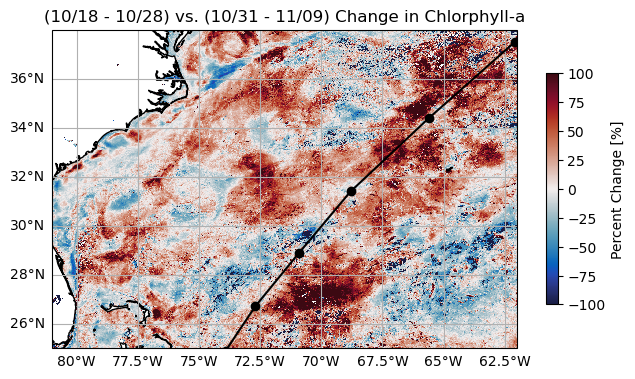

In [63]:
# Plot percent change during long post-event window
fig,ax = plt.subplots(1, 1, figsize=(7.5, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})

plot = storm_data[event_name]["chl_pct_chng"].plot(x="longitude", y="latitude" , cbar_kwargs={'label': 'Percent Change [%]', 'shrink':0.5}, cmap=cmocean.cm.balance, extend = "neither", ax=ax, robust=True, vmin=-100, vmax=100)
ax.plot(storm_data[event_name]["track"]['Longitude'], storm_data[event_name]["track"]['Latitude'], color='black', marker='o', transform=ccrs.PlateCarree(), label='Observed Track')

ax.set_xlim(storm_data[event_name]["bbox"][0],storm_data[event_name]["bbox"][2])
ax.set_ylim(storm_data[event_name]["bbox"][1],storm_data[event_name]["bbox"][3])
ax.coastlines()
# Convert pre and post event times to readable format for title
pre_start_str = pd.to_datetime(storm_data[event_name]["pre_tspan"][0]).strftime('%m/%d')
pre_end_str = pd.to_datetime(storm_data[event_name]["pre_tspan"][1]).strftime('%m/%d')
post_start_str = pd.to_datetime(storm_data[event_name]["post_tspan"][0]).strftime('%m/%d')
post_end_str = pd.to_datetime(storm_data[event_name]["post_tspan"][1]).strftime('%m/%d')
ax.set_title(f'({pre_start_str} - {pre_end_str}) vs. ({post_start_str} - {post_end_str}) Change in Chlorphyll-a')

# Save figure
#plt.savefig(f'{output_path}/ErinChlaChange.png', dpi=300, bbox_inches='tight')

In [64]:
# compare the pre and post event data. first, mask both to only pixels where data is available before and after the hurricane
# then, mask each where it's values are greater or less than

# Calculate mean over pre and post event periods
#pre_mean = storm_data[event_name]["data_avw"].sel(time=slice(storm_data[event_name]["pre_tspan"][0], storm_data[event_name]["pre_tspan"][1])).mean("time")
pre_mean = storm_data[event_name]["data_avw"].sel(time=slice(storm_data[event_name]["pre_tspan"][0], storm_data[event_name]["pre_tspan"][1]))
pre_mean = pre_mean.where(pre_mean != 0).mean("time") # MK edit to remove zeros before calculating mean, since zeros are likely not real values and skewing the mean. Not sure exactly why this bug occurs in MK processing but not in GT processing, regardless, this should take care of the issue.

#post_mean = storm_data[event_name]["data_avw"].sel(time=slice(storm_data[event_name]["post_tspan"][0], storm_data[event_name]["post_tspan"][1])).mean("time") 
post_mean = storm_data[event_name]["data_avw"].sel(time=slice(storm_data[event_name]["post_tspan"][0], storm_data[event_name]["post_tspan"][1]))
post_mean = post_mean.where(post_mean != 0).mean("time") # MK edit to remove zeros before calculating mean, since zeros are likely not real values and skewing the mean. Not sure exactly why this bug occurs in MK processing but not in GT processing, regardless, this should take care of the issue.

# Create a mask where both datasets have valid values
masklong = ~np.isnan(post_mean) & ~np.isnan(pre_mean)

# Apply masks to datasets
# Calculate percent change over pre and post event periods during the post-event window
pre_mean_mask = pre_mean.where(masklong)
post_mean_mask = post_mean.where(masklong)
post_pct_change = post_mean_mask-pre_mean_mask
storm_data[event_name]["avw_diff"] = post_pct_change


In [65]:
# #LLM solution to plot time series of AVW maps to see evolution over time and check for outliers, will remove in a future commit.

# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cmocean
# import pandas as pd

# # Get the time-sliced data
# data_pre = storm_data[event_name]["data_avw"].sel(
#     time=slice(storm_data[event_name]["pre_tspan"][0], storm_data[event_name]["pre_tspan"][1])
# )

# # Loop through each time step
# for time_idx in range(len(data_pre.time)):
#     # Select data for this specific time
#     data_day = data_pre.isel(time=time_idx)
    
#     # Get the filename for this time index
#     filename = storm_data[event_name]["data_avw"][time_idx]
    
#     # Create figure
#     fig, ax = plt.subplots(1, 1, figsize=(7.5, 6), subplot_kw={'projection': ccrs.PlateCarree()})
#     ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
    
#     # Plot the data
#     plot = data_day.plot(
#         x="longitude", y="latitude",
#         cbar_kwargs={'label': 'AVW [nm]', 'shrink': 0.5},
#         cmap=cmocean.cm.tempo,  # or use cmocean.cm.matter for AVW
#         ax=ax,
#         robust=True
#     )
    
#     # Add storm track
#     ax.plot(storm_data[event_name]["track"]['Longitude'], 
#             storm_data[event_name]["track"]['Latitude'], 
#             color='black', marker='o', transform=ccrs.PlateCarree(), 
#             label='Observed Track')
    
#     # Set extent
#     ax.set_xlim(storm_data[event_name]["bbox"][0], storm_data[event_name]["bbox"][2])
#     ax.set_ylim(storm_data[event_name]["bbox"][1], storm_data[event_name]["bbox"][3])
#     ax.coastlines()
    
#     # Format date for title
#     date_str = pd.to_datetime(data_day.time.values).strftime('%Y-%m-%d')
#     ax.set_title(f'AVW - {date_str}')
    
#     # Add filename as text in the lower left corner
#     ax.text(0.02, 0.02, filename, transform=ax.transAxes, 
#             fontsize=8, verticalalignment='bottom',
#             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
#     plt.tight_layout()
#     plt.show()

Text(0.5, 1.0, '(10/18 - 10/28) vs. (10/31 - 11/09) Change in AVW')

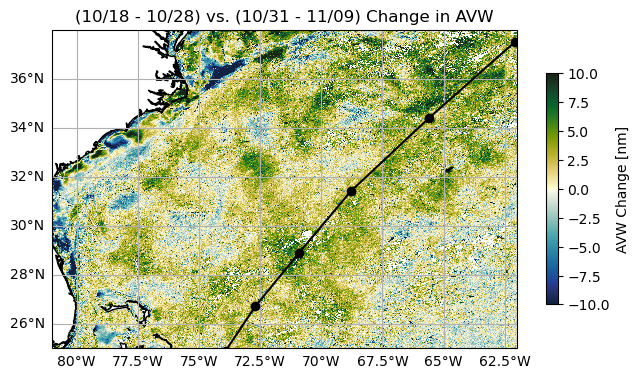

In [66]:
# Plot percent change during long post-event window
fig,ax = plt.subplots(1, 1, figsize=(7.5, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = storm_data[event_name]["avw_diff"].plot(x="longitude", y="latitude" , cbar_kwargs={'label': 'AVW Change [nm]', 'shrink':0.5}, cmap=cmocean.cm.delta, extend = "neither", ax=ax, robust=True, vmin=-10, vmax=10)
ax.plot(storm_data[event_name]["track"]['Longitude'], storm_data[event_name]["track"]['Latitude'], color='black', marker='o', transform=ccrs.PlateCarree(), label='Observed Track')
ax.set_xlim(storm_data[event_name]["bbox"][0],storm_data[event_name]["bbox"][2])
ax.set_ylim(storm_data[event_name]["bbox"][1],storm_data[event_name]["bbox"][3])
ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='white', zorder=1) # MK add to make land white since AVW values over land are not meaningful and can skew the colorbar scaling. Issue occurs with new MK AVW averaging method...
# Convert pre and post event times to readable format for title
pre_start_str = pd.to_datetime(storm_data[event_name]["pre_tspan"][0]).strftime('%m/%d')
pre_end_str = pd.to_datetime(storm_data[event_name]["pre_tspan"][1]).strftime('%m/%d')
post_start_str = pd.to_datetime(storm_data[event_name]["post_tspan"][0]).strftime('%m/%d')
post_end_str = pd.to_datetime(storm_data[event_name]["post_tspan"][1]).strftime('%m/%d')
ax.set_title(f'({pre_start_str} - {pre_end_str}) vs. ({post_start_str} - {post_end_str}) Change in AVW')

# Save figure
#plt.savefig(f'{output_path}/ErinAVWChange.png', dpi=300, bbox_inches='tight')

In [67]:
storm_data[event_name]["dataset_MOANA"] = xr.open_mfdataset(paths_MOANA, preprocess=time_from_attr_L4MOANNA, combine='nested', concat_dim='time')
storm_data[event_name]["dataset_BGC"] = xr.open_mfdataset(paths_bgc_L3, preprocess=time_from_attr_L4MOANNA, combine='nested', concat_dim='time')
storm_data[event_name]["dataset_sst"] = xr.open_mfdataset(paths_sst, preprocess=time_from_attr_sst, combine='nested', concat_dim='time')

#Add 2025-08-23 to dataset with NaNs since missing due to safehold
# gap_ds = storm_data[event_name]["dataset_MOANA"].isel(time=-1).copy()
# # Set all data variables to NaN arrays (float dtype)
# for var in gap_ds.data_vars:
#     shape = gap_ds[var].shape
#     gap_ds[var] = (gap_ds[var].dims, np.full(shape, np.nan, dtype=float))
# gap_ds = gap_ds.assign_coords(time=[np.datetime64('2025-08-23')])
# storm_data[event_name]["dataset_MOANA"] = xr.concat([storm_data[event_name]["dataset_MOANA"], gap_ds], dim='time')
# storm_data[event_name]["dataset_MOANA"] = storm_data[event_name]["dataset_MOANA"].sortby('time')

# Set SST time variables to midnight for consistency
storm_data[event_name]["dataset_sst"] = storm_data[event_name]["dataset_sst"].assign_coords(time=storm_data[event_name]["dataset_sst"]['time'].dt.floor('D'))

# Get min/max values of L4 dataset within bounding box coordinates for later plotting
date_str = [str(date) for date in storm_data[event_name]["dataset_MOANA"]["time"].dt.date.values]

# Calculate 2-day coarsened mean of L3 & L4M data products
storm_data[event_name]["MOANA_mean_2"] = storm_data[event_name]["dataset_MOANA"].coarsen(time=2, boundary='trim').mean()
storm_data[event_name]["BGC_mean_2"] = storm_data[event_name]["dataset_BGC"].coarsen(time=2, boundary='trim').mean()

# Print time values to verify they are consistent between datasets
print(storm_data[event_name]["dataset_MOANA"].time.values)
print(storm_data[event_name]["dataset_BGC"].time.values)
print(storm_data[event_name]["dataset_sst"].time.values)

['2025-10-18T00:00:00' '2025-10-19T00:00:00' '2025-10-20T00:00:00'
 '2025-10-21T00:00:00' '2025-10-22T00:00:00' '2025-10-23T00:00:00'
 '2025-10-24T00:00:00' '2025-10-25T00:00:00' '2025-10-26T00:00:00'
 '2025-10-27T00:00:00' '2025-10-28T00:00:00' '2025-10-29T00:00:00'
 '2025-10-30T00:00:00' '2025-10-31T00:00:00' '2025-11-01T00:00:00'
 '2025-11-02T00:00:00' '2025-11-03T00:00:00' '2025-11-04T00:00:00'
 '2025-11-05T00:00:00' '2025-11-06T00:00:00' '2025-11-07T00:00:00'
 '2025-11-08T00:00:00' '2025-11-09T00:00:00']
['2025-10-18T00:00:00' '2025-10-19T00:00:00' '2025-10-20T00:00:00'
 '2025-10-21T00:00:00' '2025-10-22T00:00:00' '2025-10-23T00:00:00'
 '2025-10-24T00:00:00' '2025-10-25T00:00:00' '2025-10-26T00:00:00'
 '2025-10-27T00:00:00' '2025-10-28T00:00:00' '2025-10-29T00:00:00'
 '2025-10-30T00:00:00' '2025-10-31T00:00:00' '2025-11-01T00:00:00'
 '2025-11-02T00:00:00' '2025-11-03T00:00:00' '2025-11-04T00:00:00'
 '2025-11-05T00:00:00' '2025-11-06T00:00:00' '2025-11-07T00:00:00'
 '2025-11-08T00:

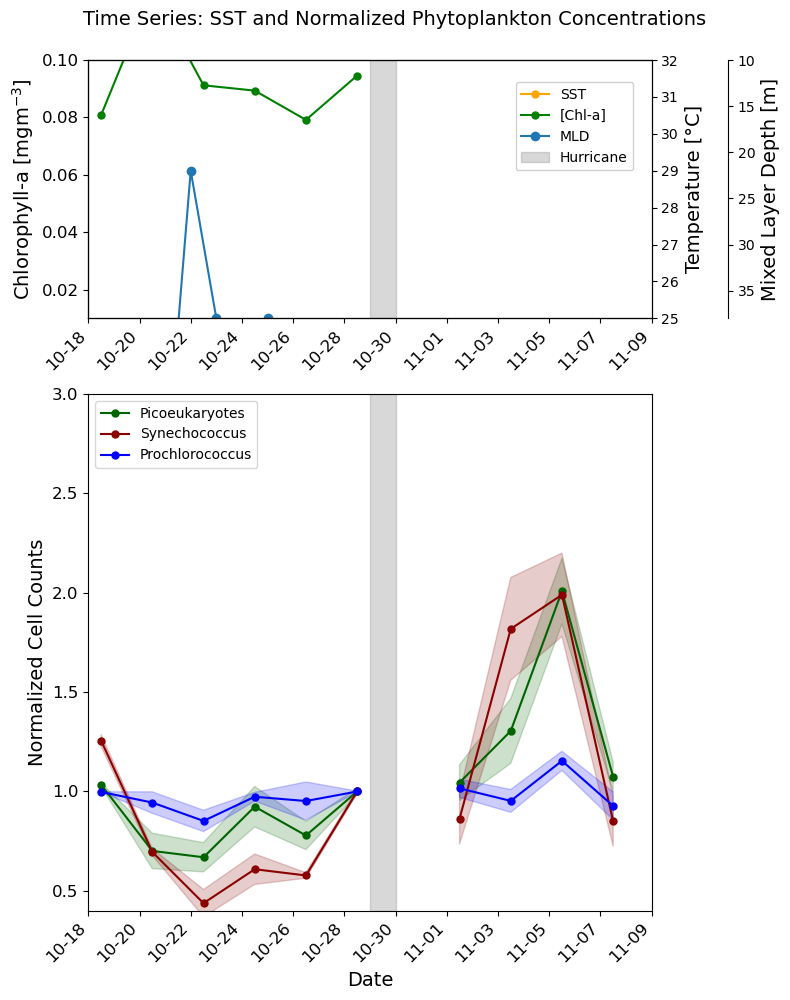

In [68]:
# Normalize phytoplankton functional type plots to day before event

# Find the nearest point to the target lat/lon coordinates
datanear =  storm_data[event_name]["MOANA_mean_2"].sel(lat=storm_data[event_name]["target_point"][0], lon=storm_data[event_name]["target_point"][1], method='nearest')

# Determine the index of lat/lon to the target coordinate
storm_data[event_name]["MOANA_tar_idx"] = [storm_data[event_name]["MOANA_mean_2"].lat.values.tolist().index(datanear.lat.values), \
                  storm_data[event_name]["MOANA_mean_2"].lon.values.tolist().index(datanear.lon.values)]
# Select adjacent data
storm_data[event_name]["MOANA_data"] = storm_data[event_name]["MOANA_mean_2"].isel(lat=slice(storm_data[event_name]["MOANA_tar_idx"][0]-2, storm_data[event_name]["MOANA_tar_idx"][0]+3), \
                                  lon=slice(storm_data[event_name]["MOANA_tar_idx"][1]-2, storm_data[event_name]["MOANA_tar_idx"][1]+3))
storm_data[event_name]["MOANA_std"] = storm_data[event_name]["dataset_MOANA"].isel(lat=slice(storm_data[event_name]["MOANA_tar_idx"][0]-2, storm_data[event_name]["MOANA_tar_idx"][0]+3), \
                                  lon=slice(storm_data[event_name]["MOANA_tar_idx"][1]-2, storm_data[event_name]["MOANA_tar_idx"][1]+3))

# Calculate the mean of the selected adjacent data
storm_data[event_name]["MOANA_data"] = storm_data[event_name]["MOANA_data"].mean(dim=['lat','lon']) #
storm_data[event_name]["MOANA_std"] = storm_data[event_name]["MOANA_std"].std(dim=['lat','lon'])
storm_data[event_name]["MOANA_std"] = storm_data[event_name]["MOANA_std"].coarsen(time=2, boundary='trim').mean()

###########################BGC Data Extraction########################
# Find the nearest point to the target lat/lon coordinates
datanear =  storm_data[event_name]["BGC_mean_2"].sel(lat=storm_data[event_name]["target_point"][0], lon=storm_data[event_name]["target_point"][1], method='nearest')

# Determine the index of lat/lon to the target coordinate
storm_data[event_name]["BGC_tar_idx"] = [storm_data[event_name]["BGC_mean_2"].lat.values.tolist().index(datanear.lat.values), \
                  storm_data[event_name]["BGC_mean_2"].lon.values.tolist().index(datanear.lon.values)]
# Select adjacent data
storm_data[event_name]["BGC_data"] = storm_data[event_name]["BGC_mean_2"].isel(lat=slice(storm_data[event_name]["BGC_tar_idx"][0]-2, storm_data[event_name]["BGC_tar_idx"][0]+3), \
                                  lon=slice(storm_data[event_name]["BGC_tar_idx"][1]-2, storm_data[event_name]["BGC_tar_idx"][1]+3))
storm_data[event_name]["BGC_std"] = storm_data[event_name]["dataset_BGC"].isel(lat=slice(storm_data[event_name]["BGC_tar_idx"][0]-2, storm_data[event_name]["BGC_tar_idx"][0]+3), \
                                  lon=slice(storm_data[event_name]["BGC_tar_idx"][1]-2, storm_data[event_name]["BGC_tar_idx"][1]+3))

# Calculate the mean of the selected adjacent data
storm_data[event_name]["BGC_data"] = storm_data[event_name]["BGC_data"].mean(dim=['lat','lon']) #
storm_data[event_name]["BGC_std"] = storm_data[event_name]["BGC_std"].std(dim=['lat','lon'])
storm_data[event_name]["BGC_std"] = storm_data[event_name]["BGC_std"].coarsen(time=2, boundary='trim').mean()

#############################SST Data Extraction############################
# Find the nearest point to the target lat/lon coordinates
sst_datanear = storm_data[event_name]["dataset_sst"].sel(lat=target_point[0], lon=target_point[1], method='nearest')

# Determine the index of lat/lon to the target coordinate
sst_tarcoords_idx = [storm_data[event_name]["dataset_sst"].lat.values.tolist().index(sst_datanear.lat.values), \
                     storm_data[event_name]["dataset_sst"].lon.values.tolist().index(sst_datanear.lon.values)]

# Select adjacent data (1x1 pixel grid)
tar1_data_sst = storm_data[event_name]["dataset_sst"].isel(lat=slice(sst_tarcoords_idx[0], sst_tarcoords_idx[0]+1), \
                                 lon=slice(sst_tarcoords_idx[1], sst_tarcoords_idx[1]+1))

# Calculate the mean of the selected adjacent data
storm_data[event_name]["SST_data"] = tar1_data_sst.mean(dim=['lat','lon']) - 273.15  # Convert from Kelvin to Celsius

# Normalize phytoplankton data to the day before the event
storm_data[event_name]["pico_norm"] = storm_data[event_name]["MOANA_data"]['picoeuk_moana'] / storm_data[event_name]["MOANA_data"]['picoeuk_moana'].sel(time=storm_data[event_name]["day_before"],method='nearest')
storm_data[event_name]["sync_norm"] = storm_data[event_name]["MOANA_data"]['syncoccus_moana'] / storm_data[event_name]["MOANA_data"]['syncoccus_moana'].sel(time=storm_data[event_name]["day_before"],method='nearest')
storm_data[event_name]["proc_norm"] = storm_data[event_name]["MOANA_data"]['prococcus_moana'] / storm_data[event_name]["MOANA_data"]['prococcus_moana'].sel(time=storm_data[event_name]["day_before"],method='nearest')

# Normalize standard deviations proportionally
storm_data[event_name]["pico_std_norm"] = storm_data[event_name]["MOANA_std"]['picoeuk_moana'] / storm_data[event_name]["MOANA_data"]['picoeuk_moana'].sel(time=storm_data[event_name]["day_before"],method='nearest')#MOANA_data['picoeuk_moana'].max()
storm_data[event_name]["sync_std_norm"] = storm_data[event_name]["MOANA_std"]['syncoccus_moana'] / storm_data[event_name]["MOANA_data"]['syncoccus_moana'].sel(time=storm_data[event_name]["day_before"],method='nearest')#MOANA_data['syncoccus_moana'].max()
storm_data[event_name]["proc_std_norm"] = storm_data[event_name]["MOANA_std"]['prococcus_moana'] / storm_data[event_name]["MOANA_data"]['prococcus_moana'].sel(time=storm_data[event_name]["day_before"],method='nearest')#MOANA_data['prococcus_moana'].max()

# Create 2x1 subplot layout with different heights
fig, (ax_chl, ax_bottom) = plt.subplots(2, 1, figsize=(8, 10), 
                                         gridspec_kw={'height_ratios': [1, 2]})

# Extract time values
sst_time_values = storm_data[event_name]["SST_data"]['time'].values
moana_time_values = storm_data[event_name]["MOANA_data"]['time'].values
bgc_time_values = storm_data[event_name]["BGC_data"]['time'].values

# Create left y-axis for chlorophyll-a
ax_chl.set_zorder(2)
ax_chl.plot(bgc_time_values, storm_data[event_name]["BGC_data"]['chlor_a'].values, 'o-',
            color=mcolors.CSS4_COLORS['green'], label="[Chl-a]", markersize=5)
# ax_chl.fill_between(bgc_time_values,
#                     (chl_norm - chl_std_norm).values,
#                     (chl_norm + chl_std_norm).values,
#                     color=mcolors.CSS4_COLORS['black'], alpha=0.2)
ax_chl.set_ylabel('Chlorophyll-a [mgm$^{-3}$]', fontsize=14, color=mcolors.CSS4_COLORS['black'])
ax_chl.tick_params(axis='y', labelcolor=mcolors.CSS4_COLORS['black'])
ax_chl.set_ylim(0.01, 0.1)


# Plot 1: SST (top panel)
ax_sst = ax_chl.twinx()
ax_sst.set_zorder(1)
ax_sst.plot(sst_time_values,
            storm_data[event_name]["SST_data"]['analysed_sst'].values,
            'o-',
            color=mcolors.CSS4_COLORS['orange'],
            label="SST",
            markersize=5)
ax_sst.axvspan(np.datetime64(storm_data[event_name]["tp_tspan"][0]), np.datetime64(tp_tspan[1]), 
               color='gray', alpha=0.3, label='Hurricane')
ax_sst.set_ylabel('Temperature [°C]', fontsize=14)
ax_sst.set_ylim(25, 32)
#ax_top.set_ylim(np.floor(SST_data['analysed_sst'].values.min()), np.ceil(SST_data['analysed_sst'].values.max()))



# create 3rd y axis for MLD
mld_data = storm_data[event_name]["hycom_data"].sel(lat=target_point[0], lon=target_point[1], method='nearest').mixed_layer_thickness.values
mld_time = storm_data[event_name]["hycom_data"].sel(lat=target_point[0], lon=target_point[1], method='nearest').time.values

ax_mld = ax_chl.twinx()
ax_mld.set_zorder(0)
ax_mld.invert_yaxis()
#subset.sel(lat=target_point[0], lon = target_point[1], method='nearest').mixed_layer_thickness.plot(ax=ax_mld,)
ax_mld.plot(mld_time, mld_data, 'o-', label='MLD')
ax_mld.spines['right'].set_position(('outward', 55))  # Move right spine outward by 60 points
ax_mld.set_ylabel('Mixed Layer Depth [m]', fontsize=14)
ax_mld.set_ylim(38, 10)

# IMPORTANT: Set patch visibility to control what shows through
# This prevents lower axes from blocking higher ones
ax_chl.patch.set_visible(False)   # Keep background visible for bottom layer
ax_sst.patch.set_visible(False)  # Make background transparent for middle layer
ax_mld.patch.set_visible(True)  # Make background transparent for top layer

# Combine legends from both axes
handles_sst, labels_sst = ax_sst.get_legend_handles_labels()
handles_chl, labels_chl = ax_chl.get_legend_handles_labels()
handles_mld, labels_mld = ax_mld.get_legend_handles_labels()


ax_chl.legend(handles_sst[0:1] + handles_chl + handles_mld + handles_sst[1:2],
              labels_sst[0:1] + labels_chl + labels_mld + labels_sst[1:2],
              bbox_to_anchor=(0.98, 0.94), frameon=True, framealpha=0.9)


# Bottom panel: All normalized phytoplankton on left, chlorophyll on right
# Plot all three phytoplankton on left axis
ax_bottom.plot(moana_time_values, storm_data[event_name]["pico_norm"].values, 'o-',
               color=mcolors.CSS4_COLORS['darkgreen'], label="Picoeukaryotes", markersize=5)
ax_bottom.fill_between(moana_time_values,
                       (storm_data[event_name]["pico_norm"] - storm_data[event_name]["pico_std_norm"]).values,
                       (storm_data[event_name]["pico_norm"] + storm_data[event_name]["pico_std_norm"]).values,
                       color=mcolors.CSS4_COLORS['darkgreen'], alpha=0.2)

ax_bottom.plot(moana_time_values, storm_data[event_name]["sync_norm"].values, 'o-',
               color=mcolors.CSS4_COLORS['darkred'], label="Synechococcus", markersize=5)
ax_bottom.fill_between(moana_time_values,
                       (storm_data[event_name]["sync_norm"] - storm_data[event_name]["sync_std_norm"]).values,
                       (storm_data[event_name]["sync_norm"] + storm_data[event_name]["sync_std_norm"]).values,
                       color=mcolors.CSS4_COLORS['darkred'], alpha=0.2)

ax_bottom.plot(moana_time_values, storm_data[event_name]["proc_norm"].values, 'o-',
               color=mcolors.CSS4_COLORS['blue'], label="Prochlorococcus", markersize=5)
ax_bottom.fill_between(moana_time_values,
                       (storm_data[event_name]["proc_norm"] - storm_data[event_name]["proc_std_norm"]).values,
                       (storm_data[event_name]["proc_norm"] + storm_data[event_name]["proc_std_norm"]).values,
                       color=mcolors.CSS4_COLORS['blue'], alpha=0.2)

ax_bottom.set_ylabel('Normalized Cell Counts', fontsize=14)
ax_bottom.set_ylim(0.4, 3)


# Add event shading
ax_bottom.axvspan(np.datetime64(tp_tspan[0]), np.datetime64(tp_tspan[1]), 
                  color='gray', alpha=0.3)

# Labels and formatting
ax_bottom.set_xlabel('Date', fontsize=14)

# Combine legends from both axes
handles_phyto, labels_phyto = ax_bottom.get_legend_handles_labels()
handles_chl, labels_chl = ax_chl.get_legend_handles_labels()

ax_bottom.legend(handles_phyto,
                 labels_phyto,
                 loc='upper left', frameon=True, framealpha=0.8)

# Format x-axis for both subplots
for axis in [ax_chl, ax_bottom]:
    axis.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    axis.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    axis.xaxis.set_tick_params(labelsize=12)
    axis.yaxis.set_tick_params(labelsize=12)
    axis.set_xlim(np.datetime64(tspan[0]), np.datetime64(tspan[1]))
    plt.setp(axis.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.suptitle('Time Series: SST and Normalized Phytoplankton Concentrations', fontsize=14, y=0.995)
plt.tight_layout()

# Save figure
#plt.savefig(f'{output_path}/MOANA_SST_CHL_TimeSeries_prenorm.png', dpi=300, bbox_inches='tight')

### now, make publication quality paper figures combining plots from all 4 hurricanes


Text(0.5, 1.0, 'Data Availability Heat Map (10/18 - 11/09)')

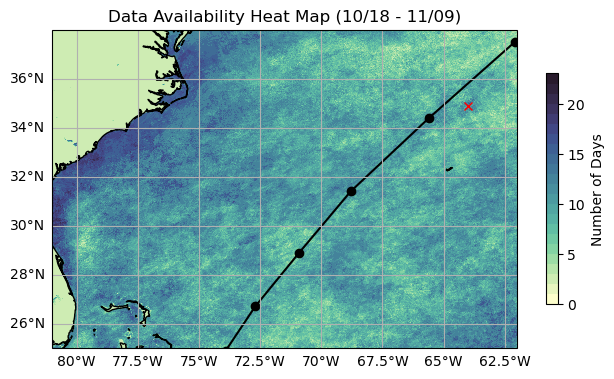

In [69]:
## Chlorophyll-a time series at target point - single event

# Data availability heat map
# Group the data by date and compute the mean for each group
data_chla_by_date = storm_data[event_name]["data_chla"].groupby(storm_data[event_name]["data_chla"]['time'].dt.date).mean(dim='time')
# Count the number of non-NaN values across the time dimension
data_count = data_chla_by_date.count(dim='date')
# Get the total number of days in the 'date' dimension
total_days = len(data_chla_by_date['date'])

# Create a discrete colormap with `total_days` colors
discrete_cmap = ListedColormap(cmocean.cm.deep(np.linspace(0, 1, total_days)))

# Define boundaries for the colormap
boundaries = np.arange(0, total_days + 1)  # One boundary for each day

# Plot data availability heat map
fig,ax = plt.subplots(1, 1, figsize=(7.5, 6), subplot_kw={'projection': ccrs.PlateCarree()})
data_count.plot(
    x='longitude',
    y='latitude',
    cmap=discrete_cmap,  # Use the discrete colormap
    cbar_kwargs={
        'label': 'Number of Days',
        'spacing': 'proportional',
        'pad': 0.05,
        'shrink': 0.5
    },
    vmin=0,
    vmax=total_days,  # Set color bar range
    ax=ax
)
ax.plot(storm_data[event_name]["track"]['Longitude'], storm_data[event_name]["track"]['Latitude'], color='black', marker='o', transform=ccrs.PlateCarree(), label='Observed Track')
ax.plot(storm_data[event_name]["target_point"][1], storm_data[event_name]["target_point"][0], color='red', marker='x', transform=ccrs.PlateCarree(), label='Target Point')
ax.set_xlim(storm_data[event_name]["bbox"][0],storm_data[event_name]["bbox"][2])
ax.set_ylim(storm_data[event_name]["bbox"][1],storm_data[event_name]["bbox"][3])
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
ax.coastlines()
start_str = pd.to_datetime(tspan[0]).strftime('%m/%d')
end_str = pd.to_datetime(tspan[1]).strftime('%m/%d')
ax.set_title(f'Data Availability Heat Map ({start_str} - {end_str})')
# Save figure
#plt.savefig(f'{output_path}/_Chla_Data_Availability_Heat_Map.png', dpi=300, bbox_inches='tight')







In [70]:
output_path = os.path.join(os.getcwd(), "paper_figures")
os.makedirs(output_path, exist_ok=True)

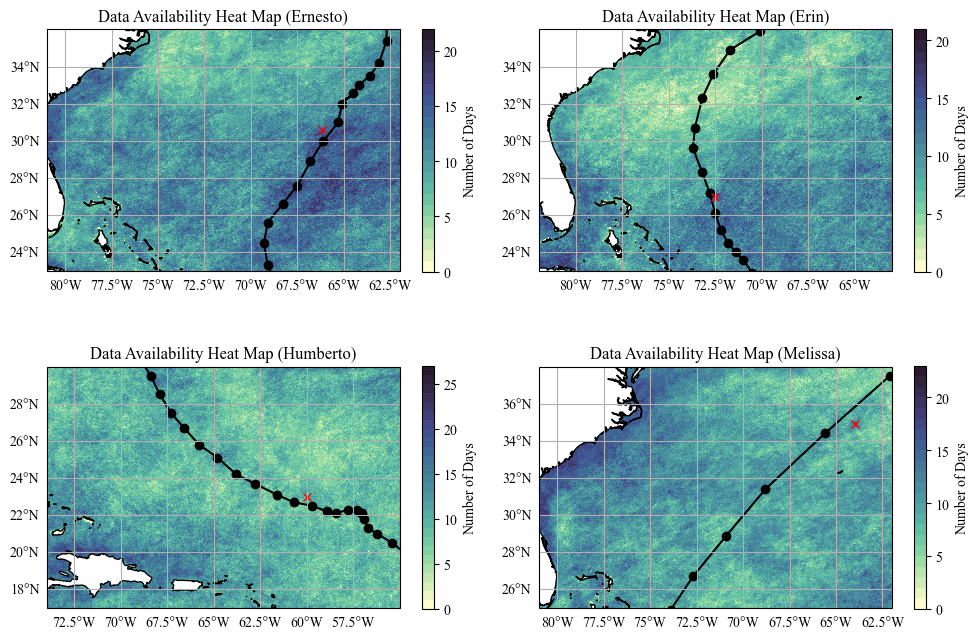

In [71]:
import matplotlib.pyplot as plt

# Set Times New Roman as the default font
plt.rcParams['font.family'] = 'Times New Roman'

fig, axes = plt.subplots(2, 2, figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})

# compute Ernesto
event_name = "Hurricane_Ernesto"
# Group the data by date and compute the mean for each group
data_chla_by_date = storm_data[event_name]["data_chla"].groupby(storm_data[event_name]["data_chla"]['time'].dt.date).mean(dim='time')
# Count the number of non-NaN values across the time dimension
data_count = data_chla_by_date.count(dim='date')
# Get the total number of days in the 'date' dimension
total_days = len(data_chla_by_date['date'])
# Create a discrete colormap with `total_days` colors
discrete_cmap = ListedColormap(cmocean.cm.deep(np.linspace(0, 1, total_days)))
# Define boundaries for the colormap
boundaries = np.arange(0, total_days + 1)  # One boundary for each day
# plot ernesto:
data_count.plot(
    x='longitude',
    y='latitude',
    cmap=discrete_cmap,  # Use the discrete colormap
    cbar_kwargs={
        'label': 'Number of Days',
        'spacing': 'proportional',
        'pad': 0.05,
        'shrink': .73
    },
    vmin=0,
    vmax=total_days,  # Set color bar range
    ax=axes[0,0]
)
axes[0,0].plot(storm_data[event_name]["track"]['Longitude'], storm_data[event_name]["track"]['Latitude'], color='black', marker='o', transform=ccrs.PlateCarree(), label='Observed Track')
axes[0,0].plot(storm_data[event_name]["target_point"][1], storm_data[event_name]["target_point"][0], color='red', marker='x', transform=ccrs.PlateCarree(), label='Target Point')
axes[0,0].set_xlim(storm_data[event_name]["bbox"][0],storm_data[event_name]["bbox"][2])
axes[0,0].set_ylim(storm_data[event_name]["bbox"][1],storm_data[event_name]["bbox"][3])
axes[0,0].gridlines(draw_labels={"left": "y", "bottom": "x"})
axes[0,0].coastlines()
axes[0,0].add_feature(cfeature.LAND, facecolor='white', zorder=1) # MK add to make land white since AVW values over land are not meaningful and can skew the colorbar scaling. Issue occurs with new MK AVW averaging method...
start_str = pd.to_datetime(storm_data[event_name]["tspan"][0]).strftime('%m/%d')
end_str = pd.to_datetime(storm_data[event_name]["tspan"][1]).strftime('%m/%d')
axes[0,0].set_title(f'Data Availability Heat Map (Ernesto)', fontfamily='Times New Roman')

## Erin upper right

event_name = "Hurricane_Erin"
# Group the data by date and compute the mean for each group
data_chla_by_date = storm_data[event_name]["data_chla"].groupby(storm_data[event_name]["data_chla"]['time'].dt.date).mean(dim='time')
# Count the number of non-NaN values across the time dimension
data_count = data_chla_by_date.count(dim='date')
# Get the total number of days in the 'date' dimension
total_days = len(data_chla_by_date['date'])
# Create a discrete colormap with `total_days` colors
discrete_cmap = ListedColormap(cmocean.cm.deep(np.linspace(0, 1, total_days)))
# Define boundaries for the colormap
boundaries = np.arange(0, total_days + 1)  # One boundary for each day
# plot ernesto:
data_count.plot(
    x='longitude',
    y='latitude',
    cmap=discrete_cmap,  # Use the discrete colormap
    cbar_kwargs={
        'label': 'Number of Days',
        'spacing': 'proportional',
        'pad': 0.05,
        'shrink': 0.73
    },
    vmin=0,
    vmax=total_days,  # Set color bar range
    ax=axes[0,1]
)
axes[0,1].plot(storm_data[event_name]["track"]['Longitude'], storm_data[event_name]["track"]['Latitude'], color='black', marker='o', transform=ccrs.PlateCarree(), label='Observed Track')
axes[0,1].plot(storm_data[event_name]["target_point"][1], storm_data[event_name]["target_point"][0], color='red', marker='x', transform=ccrs.PlateCarree(), label='Target Point')
axes[0,1].set_xlim(storm_data[event_name]["bbox"][0],storm_data[event_name]["bbox"][2])
axes[0,1].set_ylim(storm_data[event_name]["bbox"][1],storm_data[event_name]["bbox"][3])
axes[0,1].gridlines(draw_labels={"left": "y", "bottom": "x"})
axes[0,1].coastlines()
axes[0,1].add_feature(cfeature.LAND, facecolor='white', zorder=1) # MK add to make land white since AVW values over land are not meaningful and can skew the colorbar scaling. Issue occurs with new MK AVW averaging method...
start_str = pd.to_datetime(storm_data[event_name]["tspan"][0]).strftime('%m/%d')
end_str = pd.to_datetime(storm_data[event_name]["tspan"][1]).strftime('%m/%d')
axes[0,1].set_title(f'Data Availability Heat Map (Erin)', fontfamily='Times New Roman')

# humberto LL
event_name = "Hurricane_Humberto"
# Group the data by date and compute the mean for each group
data_chla_by_date = storm_data[event_name]["data_chla"].groupby(storm_data[event_name]["data_chla"]['time'].dt.date).mean(dim='time')
# Count the number of non-NaN values across the time dimension
data_count = data_chla_by_date.count(dim='date')
# Get the total number of days in the 'date' dimension
total_days = len(data_chla_by_date['date'])
# Create a discrete colormap with `total_days` colors
discrete_cmap = ListedColormap(cmocean.cm.deep(np.linspace(0, 1, total_days)))
# Define boundaries for the colormap
boundaries = np.arange(0, total_days + 1)  # One boundary for each day
# plot ernesto:
data_count.plot(
    x='longitude',
    y='latitude',
    cmap=discrete_cmap,  # Use the discrete colormap
    cbar_kwargs={
        'label': 'Number of Days',
        'spacing': 'proportional',
        'pad': 0.05,
        'shrink': 0.73
    },
    vmin=0,
    vmax=total_days,  # Set color bar range
    ax=axes[1,0]
)
axes[1,0].plot(storm_data[event_name]["track"]['Longitude'], storm_data[event_name]["track"]['Latitude'], color='black', marker='o', transform=ccrs.PlateCarree(), label='Observed Track')
axes[1,0].plot(storm_data[event_name]["target_point"][1], storm_data[event_name]["target_point"][0], color='red', marker='x', transform=ccrs.PlateCarree(), label='Target Point')
axes[1,0].set_xlim(storm_data[event_name]["bbox"][0],storm_data[event_name]["bbox"][2])
axes[1,0].set_ylim(storm_data[event_name]["bbox"][1],storm_data[event_name]["bbox"][3])
axes[1,0].gridlines(draw_labels={"left": "y", "bottom": "x"})
axes[1,0].coastlines()
axes[1,0].add_feature(cfeature.LAND, facecolor='white', zorder=1) # MK add to make land white since AVW values over land are not meaningful and can skew the colorbar scaling. Issue occurs with new MK AVW averaging method...
start_str = pd.to_datetime(storm_data[event_name]["tspan"][0]).strftime('%m/%d')
end_str = pd.to_datetime(storm_data[event_name]["tspan"][1]).strftime('%m/%d')
axes[1,0].set_title(f'Data Availability Heat Map (Humberto)', fontfamily='Times New Roman')

# melissa LR
event_name = "Hurricane_Melissa"
# Group the data by date and compute the mean for each group
data_chla_by_date = storm_data[event_name]["data_chla"].groupby(storm_data[event_name]["data_chla"]['time'].dt.date).mean(dim='time')
# Count the number of non-NaN values across the time dimension
data_count = data_chla_by_date.count(dim='date')
# Get the total number of days in the 'date' dimension
total_days = len(data_chla_by_date['date'])
# Create a discrete colormap with `total_days` colors
discrete_cmap = ListedColormap(cmocean.cm.deep(np.linspace(0, 1, total_days)))
# Define boundaries for the colormap
boundaries = np.arange(0, total_days + 1)  # One boundary for each day
# plot ernesto:
data_count.plot(
    x='longitude',
    y='latitude',
    cmap=discrete_cmap,  # Use the discrete colormap
    cbar_kwargs={
        'label': 'Number of Days',
        'spacing': 'proportional',
        'pad': 0.05,
        'shrink': 0.73
    },
    vmin=0,
    vmax=total_days,  # Set color bar range
    ax=axes[1,1]
)
axes[1,1].plot(storm_data[event_name]["track"]['Longitude'], storm_data[event_name]["track"]['Latitude'], color='black', marker='o', transform=ccrs.PlateCarree(), label='Observed Track')
axes[1,1].plot(storm_data[event_name]["target_point"][1], storm_data[event_name]["target_point"][0], color='red', marker='x', transform=ccrs.PlateCarree(), label='Target Point')
axes[1,1].set_xlim(storm_data[event_name]["bbox"][0],storm_data[event_name]["bbox"][2])
axes[1,1].set_ylim(storm_data[event_name]["bbox"][1],storm_data[event_name]["bbox"][3])
axes[1,1].gridlines(draw_labels={"left": "y", "bottom": "x"})
axes[1,1].coastlines()
axes[1,1].add_feature(cfeature.LAND, facecolor='white', zorder=1) # MK add to make land white since AVW values over land are not meaningful and can skew the colorbar scaling. Issue occurs with new MK AVW averaging method...
start_str = pd.to_datetime(storm_data[event_name]["tspan"][0]).strftime('%m/%d')
end_str = pd.to_datetime(storm_data[event_name]["tspan"][1]).strftime('%m/%d')
axes[1,1].set_title(f'Data Availability Heat Map (Melissa)', fontfamily='Times New Roman')

# Set Times New Roman for all tick labels and colorbar labels
for i in range(2):
    for j in range(2):
        for label in axes[i,j].get_xticklabels() + axes[i,j].get_yticklabels():
            label.set_fontfamily('Times New Roman')

plt.tight_layout()
plt.savefig(f'{output_path}/Hurricanes_data_avail.png', dpi=300, bbox_inches='tight')

### Next, 4x2 array of %diff chl-a and avw diff

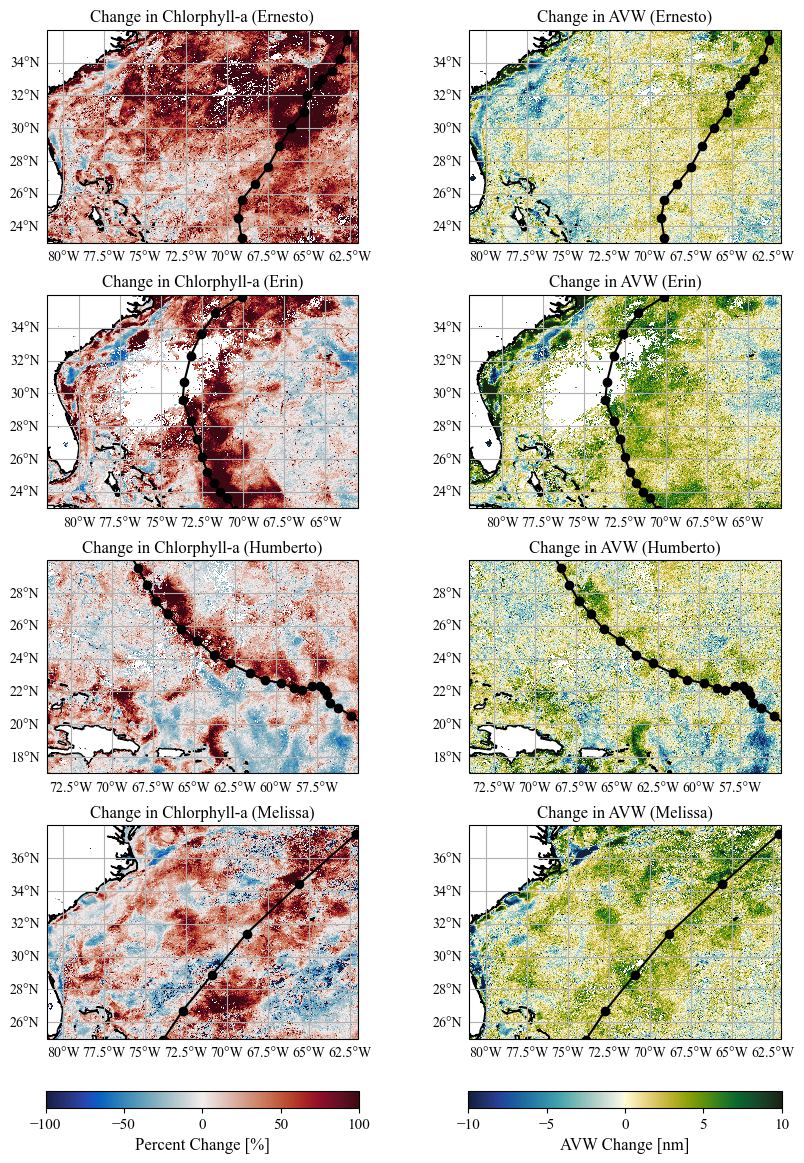

In [72]:
# Set Times New Roman as the default font
plt.rcParams['font.family'] = 'Times New Roman'

# Create figure with gridspec
fig = plt.figure(figsize=(10, 14))
gs = gridspec.GridSpec(5, 2, figure=fig, height_ratios=[1, 1, 1, 1, 0.08], hspace=0.3, wspace=0.2)

# Create the 4x2 grid of map subplots
ax = [[fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree()) for j in range(2)] for i in range(4)]

# row 0 is ernesto, col 0 is chl, col 1 is avw
event_name = "Hurricane_Ernesto"

ax[0][0].gridlines(draw_labels={"left": "y", "bottom": "x"})
ax[0][1].gridlines(draw_labels={"left": "y", "bottom": "x"})
plot_chl_0 = storm_data[event_name]["chl_pct_chng"].plot(x="longitude", y="latitude", add_colorbar=False, cmap=cmocean.cm.balance, extend="neither", ax=ax[0][0], robust=True, vmin=-100, vmax=100)
ax[0][0].plot(storm_data[event_name]["track"]['Longitude'], storm_data[event_name]["track"]['Latitude'], color='black', marker='o', transform=ccrs.PlateCarree(), label='Observed Track')
ax[0][0].set_xlim(storm_data[event_name]["bbox"][0],storm_data[event_name]["bbox"][2])
ax[0][0].set_ylim(storm_data[event_name]["bbox"][1],storm_data[event_name]["bbox"][3])
ax[0][0].coastlines()
# Convert pre and post event times to readable format for title
pre_start_str = pd.to_datetime(storm_data[event_name]["pre_tspan"][0]).strftime('%m/%d')
pre_end_str = pd.to_datetime(storm_data[event_name]["pre_tspan"][1]).strftime('%m/%d')
post_start_str = pd.to_datetime(storm_data[event_name]["post_tspan"][0]).strftime('%m/%d')
post_end_str = pd.to_datetime(storm_data[event_name]["post_tspan"][1]).strftime('%m/%d')
ax[0][0].set_title(f'Change in Chlorphyll-a (Ernesto)', fontfamily='Times New Roman', fontsize=12)

plot_avw_0 = storm_data[event_name]["avw_diff"].plot(x="longitude", y="latitude", add_colorbar=False, cmap=cmocean.cm.delta, extend="neither", ax=ax[0][1], robust=True, vmin=-10, vmax=10)
ax[0][1].plot(storm_data[event_name]["track"]['Longitude'], storm_data[event_name]["track"]['Latitude'], color='black', marker='o', transform=ccrs.PlateCarree(), label='Observed Track')
ax[0][1].set_xlim(storm_data[event_name]["bbox"][0],storm_data[event_name]["bbox"][2])
ax[0][1].set_ylim(storm_data[event_name]["bbox"][1],storm_data[event_name]["bbox"][3])
ax[0][1].coastlines()
ax[0][1].set_title(f'Change in AVW (Ernesto)', fontfamily='Times New Roman')

# row 1 is erin, col 0 is chl, col 1 is avw
event_name = "Hurricane_Erin"

ax[1][0].gridlines(draw_labels={"left": "y", "bottom": "x"})
ax[1][1].gridlines(draw_labels={"left": "y", "bottom": "x"})
storm_data[event_name]["chl_pct_chng"].plot(x="longitude", y="latitude", add_colorbar=False, cmap=cmocean.cm.balance, extend="neither", ax=ax[1][0], robust=True, vmin=-100, vmax=100)
ax[1][0].plot(storm_data[event_name]["track"]['Longitude'], storm_data[event_name]["track"]['Latitude'], color='black', marker='o', transform=ccrs.PlateCarree(), label='Observed Track')
ax[1][0].set_xlim(storm_data[event_name]["bbox"][0],storm_data[event_name]["bbox"][2])
ax[1][0].set_ylim(storm_data[event_name]["bbox"][1],storm_data[event_name]["bbox"][3])
ax[1][0].coastlines()
# Convert pre and post event times to readable format for title
pre_start_str = pd.to_datetime(storm_data[event_name]["pre_tspan"][0]).strftime('%m/%d')
pre_end_str = pd.to_datetime(storm_data[event_name]["pre_tspan"][1]).strftime('%m/%d')
post_start_str = pd.to_datetime(storm_data[event_name]["post_tspan"][0]).strftime('%m/%d')
post_end_str = pd.to_datetime(storm_data[event_name]["post_tspan"][1]).strftime('%m/%d')
ax[1][0].set_title(f'Change in Chlorphyll-a (Erin)', fontfamily='Times New Roman')

storm_data[event_name]["avw_diff"].plot(x="longitude", y="latitude", add_colorbar=False, cmap=cmocean.cm.delta, extend="neither", ax=ax[1][1], robust=True, vmin=-10, vmax=10)
ax[1][1].plot(storm_data[event_name]["track"]['Longitude'], storm_data[event_name]["track"]['Latitude'], color='black', marker='o', transform=ccrs.PlateCarree(), label='Observed Track')
ax[1][1].set_xlim(storm_data[event_name]["bbox"][0],storm_data[event_name]["bbox"][2])
ax[1][1].set_ylim(storm_data[event_name]["bbox"][1],storm_data[event_name]["bbox"][3])
ax[1][1].coastlines()
ax[1][1].set_title(f'Change in AVW (Erin)', fontfamily='Times New Roman')

# row 2 is Humberto, col 0 is chl, col 1 is avw
event_name = "Hurricane_Humberto"

ax[2][0].gridlines(draw_labels={"left": "y", "bottom": "x"})
ax[2][1].gridlines(draw_labels={"left": "y", "bottom": "x"})
storm_data[event_name]["chl_pct_chng"].plot(x="longitude", y="latitude", add_colorbar=False, cmap=cmocean.cm.balance, extend="neither", ax=ax[2][0], robust=True, vmin=-100, vmax=100)
ax[2][0].plot(storm_data[event_name]["track"]['Longitude'], storm_data[event_name]["track"]['Latitude'], color='black', marker='o', transform=ccrs.PlateCarree(), label='Observed Track')
ax[2][0].set_xlim(storm_data[event_name]["bbox"][0],storm_data[event_name]["bbox"][2])
ax[2][0].set_ylim(storm_data[event_name]["bbox"][1],storm_data[event_name]["bbox"][3])
ax[2][0].coastlines()
# Convert pre and post event times to readable format for title
pre_start_str = pd.to_datetime(storm_data[event_name]["pre_tspan"][0]).strftime('%m/%d')
pre_end_str = pd.to_datetime(storm_data[event_name]["pre_tspan"][1]).strftime('%m/%d')
post_start_str = pd.to_datetime(storm_data[event_name]["post_tspan"][0]).strftime('%m/%d')
post_end_str = pd.to_datetime(storm_data[event_name]["post_tspan"][1]).strftime('%m/%d')
ax[2][0].set_title(f'Change in Chlorphyll-a (Humberto)', fontfamily='Times New Roman')

storm_data[event_name]["avw_diff"].plot(x="longitude", y="latitude", add_colorbar=False, cmap=cmocean.cm.delta, extend="neither", ax=ax[2][1], robust=True, vmin=-10, vmax=10)
ax[2][1].plot(storm_data[event_name]["track"]['Longitude'], storm_data[event_name]["track"]['Latitude'], color='black', marker='o', transform=ccrs.PlateCarree(), label='Observed Track')
ax[2][1].set_xlim(storm_data[event_name]["bbox"][0],storm_data[event_name]["bbox"][2])
ax[2][1].set_ylim(storm_data[event_name]["bbox"][1],storm_data[event_name]["bbox"][3])
ax[2][1].coastlines()
ax[2][1].set_title(f'Change in AVW (Humberto)', fontfamily='Times New Roman')

# row 3 is Melissa, col 0 is chl, col 1 is avw
event_name = "Hurricane_Melissa"

ax[3][0].gridlines(draw_labels={"left": "y", "bottom": "x"})
ax[3][1].gridlines(draw_labels={"left": "y", "bottom": "x"})
storm_data[event_name]["chl_pct_chng"].plot(x="longitude", y="latitude", add_colorbar=False, cmap=cmocean.cm.balance, extend="neither", ax=ax[3][0], robust=True, vmin=-100, vmax=100)
ax[3][0].plot(storm_data[event_name]["track"]['Longitude'], storm_data[event_name]["track"]['Latitude'], color='black', marker='o', transform=ccrs.PlateCarree(), label='Observed Track')
ax[3][0].set_xlim(storm_data[event_name]["bbox"][0],storm_data[event_name]["bbox"][2])
ax[3][0].set_ylim(storm_data[event_name]["bbox"][1],storm_data[event_name]["bbox"][3])
ax[3][0].coastlines()
# Convert pre and post event times to readable format for title
pre_start_str = pd.to_datetime(storm_data[event_name]["pre_tspan"][0]).strftime('%m/%d')
pre_end_str = pd.to_datetime(storm_data[event_name]["pre_tspan"][1]).strftime('%m/%d')
post_start_str = pd.to_datetime(storm_data[event_name]["post_tspan"][0]).strftime('%m/%d')
post_end_str = pd.to_datetime(storm_data[event_name]["post_tspan"][1]).strftime('%m/%d')
ax[3][0].set_title(f'Change in Chlorphyll-a (Melissa)', fontfamily='Times New Roman')

storm_data[event_name]["avw_diff"].plot(x="longitude", y="latitude", add_colorbar=False, cmap=cmocean.cm.delta, extend="neither", ax=ax[3][1], robust=True, vmin=-10, vmax=10)
ax[3][1].plot(storm_data[event_name]["track"]['Longitude'], storm_data[event_name]["track"]['Latitude'], color='black', marker='o', transform=ccrs.PlateCarree(), label='Observed Track')
ax[3][1].set_xlim(storm_data[event_name]["bbox"][0],storm_data[event_name]["bbox"][2])
ax[3][1].set_ylim(storm_data[event_name]["bbox"][1],storm_data[event_name]["bbox"][3])
ax[3][1].coastlines()
ax[3][1].add_feature(cfeature.LAND, facecolor='white', zorder=1) # MK add to make land white since AVW values over land are not meaningful and can skew the colorbar scaling. Issue occurs with new MK AVW averaging method...
ax[3][1].set_title(f'Change in AVW (Melissa)', fontfamily='Times New Roman')

# Set Times New Roman for all tick labels
for i in range(4):
    for j in range(2):
        for label in ax[i][j].get_xticklabels() + ax[i][j].get_yticklabels():
            label.set_fontfamily('Times New Roman')

# Create nested GridSpec for colorbar row with padding columns
gs_cbar_left = gs[4, 0].subgridspec(1, 18, wspace=0)
gs_cbar_right = gs[4, 1].subgridspec(1, 18, wspace=0)

# Create narrower colorbar axes (middle 3 of 5 columns)
cbar_ax_chl = fig.add_subplot(gs_cbar_left[0, 1:17])
cbar_ax_avw = fig.add_subplot(gs_cbar_right[0, 1:17])

# Add colorbars
cbar_chl = plt.colorbar(plot_chl_0, cax=cbar_ax_chl, orientation='horizontal', extend='neither')
cbar_chl.set_label('Percent Change [%]', fontfamily='Times New Roman', fontsize=12)
cbar_chl.ax.tick_params(labelsize=11)
for label in cbar_chl.ax.get_xticklabels():
    label.set_fontfamily('Times New Roman')

cbar_avw = plt.colorbar(plot_avw_0, cax=cbar_ax_avw, orientation='horizontal', extend='neither')
cbar_avw.set_label('AVW Change [nm]', fontfamily='Times New Roman', fontsize=12)
cbar_avw.ax.tick_params(labelsize=11)
for label in cbar_avw.ax.get_xticklabels():
    label.set_fontfamily('Times New Roman')

plt.savefig(f'{output_path}/Hurricanes_chla_avw.png', dpi=300, bbox_inches='tight')

/var/folders/sv/8_g9kqw50y7d70sfnr2kqzzw0000gp/T/ipykernel_66716/1606788039.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


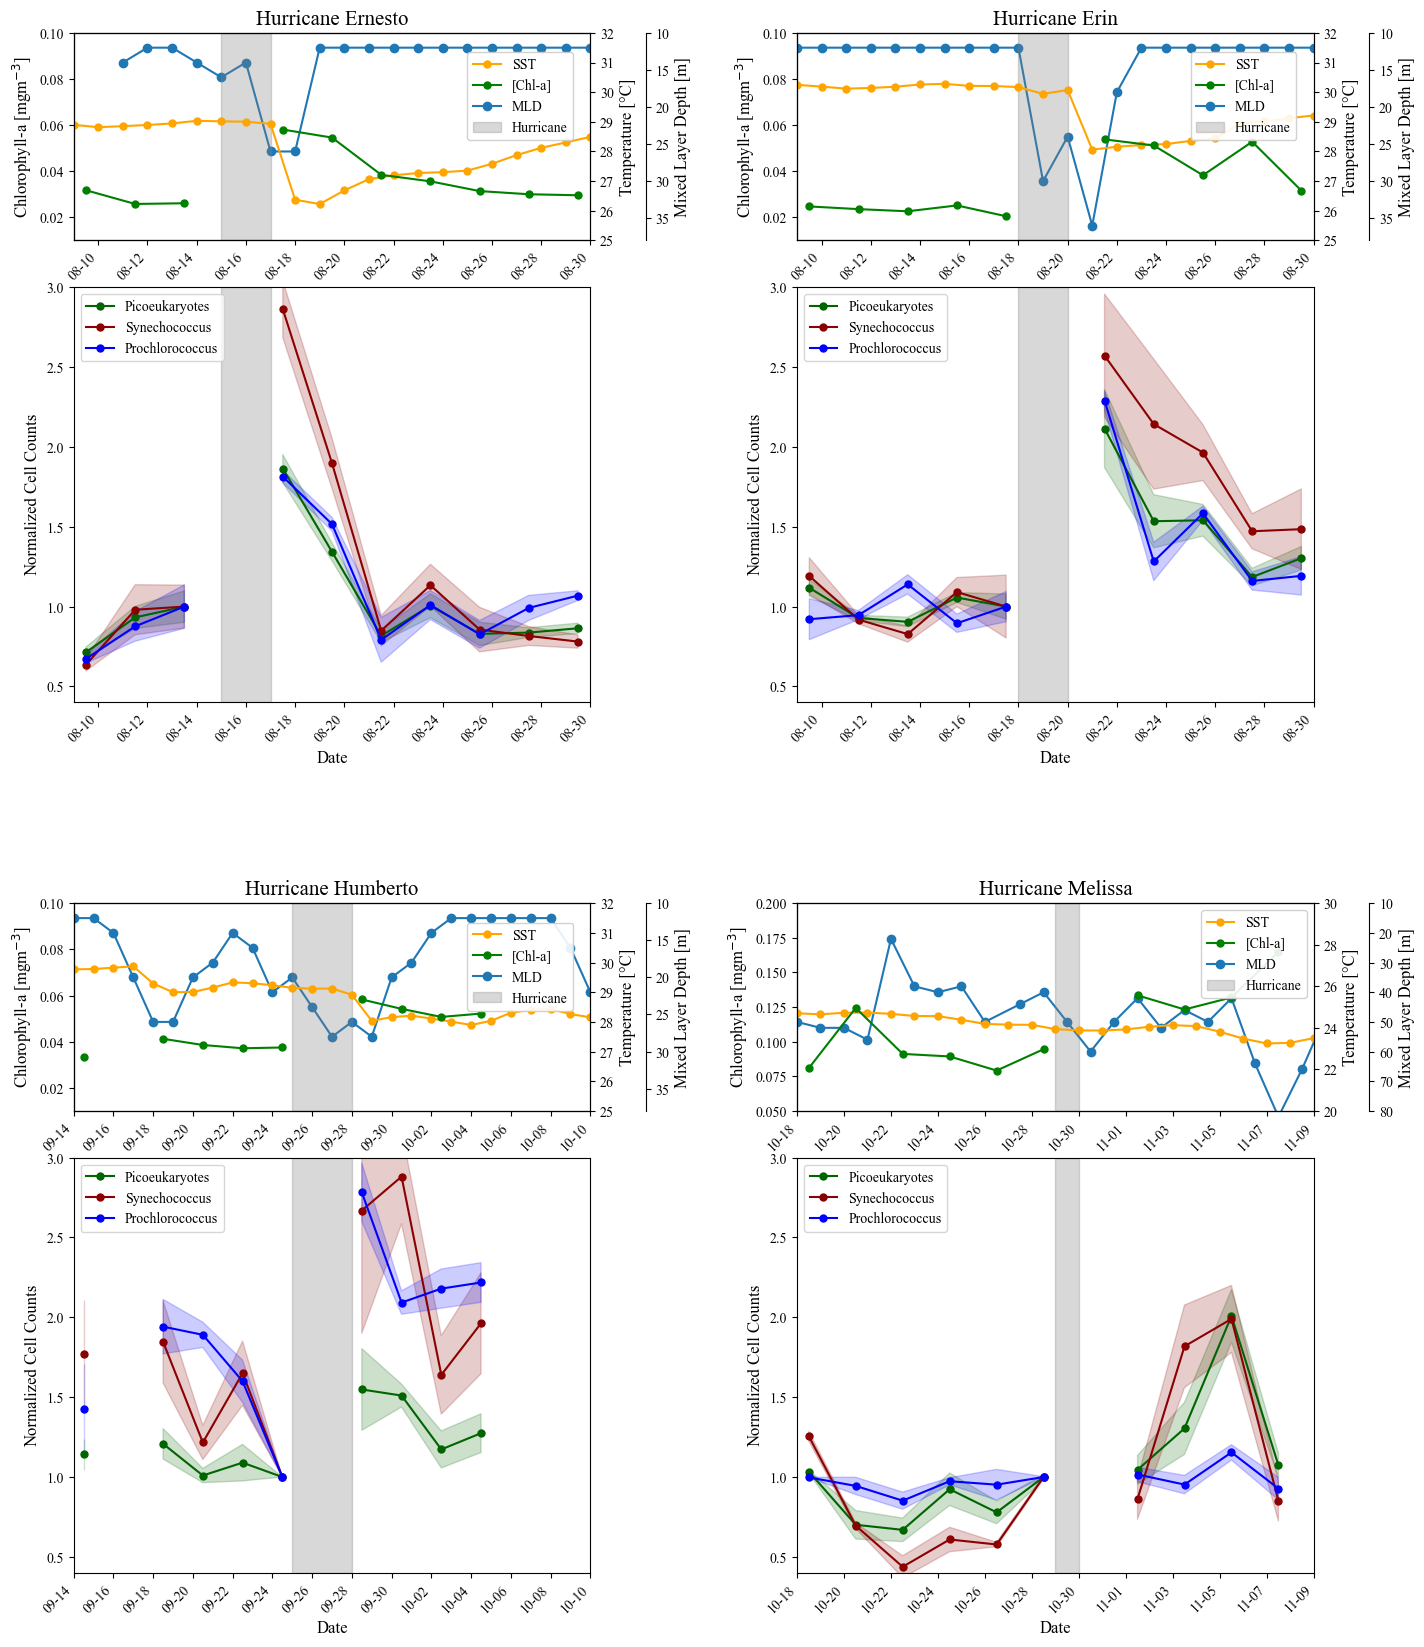

In [73]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Set Times New Roman as the default font for all text
plt.rcParams['font.family'] = 'Times New Roman'

# Create the main 2x2 grid
fig = plt.figure(figsize=(16, 20))
gs_main = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.4)

# List of event names for the 4 hurricanes
event_names = [ "Hurricane_Ernesto", "Hurricane_Erin", "Hurricane_Humberto", "Hurricane_Melissa"]

# Loop through each position in the 2x2 grid
for idx, event_name in enumerate(event_names):
    row = idx // 2  # 0, 0, 1, 1
    col = idx % 2   # 0, 1, 0, 1
    
    # Create a sub-gridspec for this 2x1 plot within the main grid cell
    gs_sub = gs_main[row, col].subgridspec(2, 1, height_ratios=[1, 2], hspace=0.15)
    
    # Create the two subplots for this hurricane
    ax_chl = fig.add_subplot(gs_sub[0])
    ax_bottom = fig.add_subplot(gs_sub[1])
    
    # Extract time values
    sst_time_values = storm_data[event_name]["SST_data"]['time'].values
    moana_time_values = storm_data[event_name]["MOANA_data"]['time'].values
    bgc_time_values = storm_data[event_name]["BGC_data"]['time'].values
    
    # Create left y-axis for chlorophyll-a
    ax_chl.set_zorder(2)
    ax_chl.plot(bgc_time_values, storm_data[event_name]["BGC_data"]['chlor_a'].values, 'o-',
                color=mcolors.CSS4_COLORS['green'], label="[Chl-a]", markersize=5)
    ax_chl.set_ylabel('Chlorophyll-a [mgm$^{-3}$]', fontsize=12, color=mcolors.CSS4_COLORS['black'], fontfamily='Times New Roman')
    ax_chl.tick_params(axis='y', labelcolor=mcolors.CSS4_COLORS['black'])
    ax_chl.set_ylim(0.01, 0.1)
    
    # Plot SST (top panel)
    ax_sst = ax_chl.twinx()
    ax_sst.set_zorder(1)
    ax_sst.plot(sst_time_values,
                storm_data[event_name]["SST_data"]['analysed_sst'].values,
                'o-',
                color=mcolors.CSS4_COLORS['orange'],
                label="SST",
                markersize=5)
    ax_sst.axvspan(np.datetime64(storm_data[event_name]["tp_tspan"][0]), 
                   np.datetime64(storm_data[event_name]["tp_tspan"][1]), 
                   color='gray', alpha=0.3, label='Hurricane')
    ax_sst.set_ylabel('Temperature [°C]', fontsize=12, fontfamily='Times New Roman')
    ax_sst.set_ylim(25, 32)
    
    # Create 3rd y axis for MLD
    target_point = storm_data[event_name]["target_point"]  # Make sure this exists
    mld_data = storm_data[event_name]["hycom_data"].sel(lat=target_point[0], lon=target_point[1], method='nearest').mixed_layer_thickness.values
    mld_time = storm_data[event_name]["hycom_data"].sel(lat=target_point[0], lon=target_point[1], method='nearest').time.values
    
    ax_mld = ax_chl.twinx()
    ax_mld.set_zorder(0)
    ax_mld.invert_yaxis()
    ax_mld.plot(mld_time, mld_data, 'o-', label='MLD')
    ax_mld.spines['right'].set_position(('outward', 40))
    ax_mld.set_ylabel('Mixed Layer Depth [m]', fontsize=12, fontfamily='Times New Roman')
    ax_mld.set_ylim(38, 10)
    
    if event_name == "Hurricane_Melissa":
        ax_chl.set_ylim(0.05, 0.20)
        ax_sst.set_ylim(20, 30)
        ax_mld.set_ylim(80, 10)
    # Set patch visibility
    ax_chl.patch.set_visible(False)
    ax_sst.patch.set_visible(False)
    ax_mld.patch.set_visible(True)
    
    # Combine legends
    handles_sst, labels_sst = ax_sst.get_legend_handles_labels()
    handles_chl, labels_chl = ax_chl.get_legend_handles_labels()
    handles_mld, labels_mld = ax_mld.get_legend_handles_labels()
    
    if event_name == "Hurricane_Melissa":
        ax_chl.legend(handles_sst[0:1] + handles_chl + handles_mld + handles_sst[1:2],
                    labels_sst[0:1] + labels_chl + labels_mld + labels_sst[1:2],
                    loc='upper right', frameon=True, framealpha=0.9, fontsize=10, prop={'family': 'Times New Roman'})
    else:
    # Original position for other hurricanes
        ax_chl.legend(handles_sst[0:1] + handles_chl + handles_mld + handles_sst[1:2],
                    labels_sst[0:1] + labels_chl + labels_mld + labels_sst[1:2],
                    bbox_to_anchor=(0.98, 0.94), frameon=True, framealpha=0.9, fontsize=10, prop={'family': 'Times New Roman'})
    
    # Bottom panel: All normalized phytoplankton
    ax_bottom.plot(moana_time_values, storm_data[event_name]["pico_norm"].values, 'o-',
                   color=mcolors.CSS4_COLORS['darkgreen'], label="Picoeukaryotes", markersize=5)
    ax_bottom.fill_between(moana_time_values,
                           (storm_data[event_name]["pico_norm"] - storm_data[event_name]["pico_std_norm"]).values,
                           (storm_data[event_name]["pico_norm"] + storm_data[event_name]["pico_std_norm"]).values,
                           color=mcolors.CSS4_COLORS['darkgreen'], alpha=0.2)
    
    ax_bottom.plot(moana_time_values, storm_data[event_name]["sync_norm"].values, 'o-',
                   color=mcolors.CSS4_COLORS['darkred'], label="Synechococcus", markersize=5)
    ax_bottom.fill_between(moana_time_values,
                           (storm_data[event_name]["sync_norm"] - storm_data[event_name]["sync_std_norm"]).values,
                           (storm_data[event_name]["sync_norm"] + storm_data[event_name]["sync_std_norm"]).values,
                           color=mcolors.CSS4_COLORS['darkred'], alpha=0.2)
    
    ax_bottom.plot(moana_time_values, storm_data[event_name]["proc_norm"].values, 'o-',
                   color=mcolors.CSS4_COLORS['blue'], label="Prochlorococcus", markersize=5)
    ax_bottom.fill_between(moana_time_values,
                           (storm_data[event_name]["proc_norm"] - storm_data[event_name]["proc_std_norm"]).values,
                           (storm_data[event_name]["proc_norm"] + storm_data[event_name]["proc_std_norm"]).values,
                           color=mcolors.CSS4_COLORS['blue'], alpha=0.2)
    
    ax_bottom.set_ylabel('Normalized Cell Counts', fontsize=12, fontfamily='Times New Roman')
    ax_bottom.set_ylim(0.4, 3)
    
    # Add event shading
    tp_tspan = storm_data[event_name]["tp_tspan"]
    ax_bottom.axvspan(np.datetime64(tp_tspan[0]), np.datetime64(tp_tspan[1]), 
                      color='gray', alpha=0.3)
    
    # Labels and formatting
    ax_bottom.set_xlabel('Date', fontsize=12, fontfamily='Times New Roman')
    
    # Legend
    handles_phyto, labels_phyto = ax_bottom.get_legend_handles_labels()
    ax_bottom.legend(handles_phyto, labels_phyto,
                     loc='upper left', frameon=True, framealpha=0.8, fontsize=10, prop={'family': 'Times New Roman'})
    
    # Format x-axis for both subplots
    tspan = storm_data[event_name]["tspan"]
    for axis in [ax_chl, ax_bottom, ax_sst, ax_mld]:
        # Set Times New Roman for tick labels
        for label in axis.get_xticklabels() + axis.get_yticklabels():
            label.set_fontfamily('Times New Roman')
    
    for axis in [ax_chl, ax_bottom]:
        axis.xaxis.set_major_locator(mdates.DayLocator(interval=2))
        axis.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        axis.xaxis.set_tick_params(labelsize=10)
        axis.yaxis.set_tick_params(labelsize=10)
        axis.set_xlim(np.datetime64(tspan[0]), np.datetime64(tspan[1]))
        plt.setp(axis.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add title for this subplot - remove bold and underscore
    title_text = event_name.replace('_', ' ')
    ax_chl.set_title(title_text, fontsize=15, fontfamily='Times New Roman')



#plt.suptitle('Time Series: SST and Normalized Phytoplankton Concentrations', fontsize=16, y=0.995)
plt.tight_layout()

# Save figure
#plt.savefig(f'{output_path}/MOANA_SST_CHL_TimeSeries_4hurricanes.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{output_path}/Hurricanes_moneyshot.png', dpi=300, bbox_inches='tight')

# summary map

In [74]:
ernesto_path = get_hurricane_path('al052024')
erin_path = get_hurricane_path('al052025')
humberto_path = get_hurricane_path('al082025')
melissa_path = get_hurricane_path('al132025')


# logic to add additional interp poitn along path, allows dashed and solid lines in main figure to hsow properly
new_row = {
    'datetime': pd.to_datetime('2025-10-31 09:00:00'),  # or your datetime
    'Latitude': 36,
    'Longitude': -63.85,
    'Intensity': 75
}
melissa_path.loc[len(melissa_path)] = new_row

# Sort by datetime
melissa_path = melissa_path.sort_values('datetime').reset_index(drop=True)

In [75]:
def plot_hurricane_path(ax, df, color, min_lon, max_lon, min_lat, max_lat, label=None):
    """
    Plot a hurricane path with different line styles inside/outside a box.
    
    Parameters:
    -----------
    ax : cartopy axis
        The axis to plot on
    df : pandas DataFrame
        DataFrame with 'Longitude' and 'Latitude' columns
    color : str
        Color to use for the entire path and markers
    min_lon, max_lon, min_lat, max_lat : float
        Bounding box coordinates
    label : str, optional
        Label for legend
    """
    import numpy as np
    import cartopy.crs as ccrs
    
    # Function to check if a point is inside the box
    def is_inside_box(lon, lat, min_lon, max_lon, min_lat, max_lat):
        return (min_lon <= lon <= max_lon) and (min_lat <= lat <= max_lat)
    
    # Get coordinates
    lons = df['Longitude'].values
    lats = df['Latitude'].values
    
    # Plot segments
    for i in range(len(lons) - 1):
        # Determine line style based on whether both points are inside
        if (is_inside_box(lons[i], lats[i], min_lon, max_lon, min_lat, max_lat) and 
            is_inside_box(lons[i+1], lats[i+1], min_lon, max_lon, min_lat, max_lat)):
            linestyle = '-'
            linewidth = 2.5
            dashes = None
        else:
            linestyle = '--'
            linewidth = 1.2
            dashes = 0
            #dashes = (3, 5)  # (dash length, gap length) in points
        
        # Add label only to first segment for legend
        segment_label = label if (i == 0 and label) else None
        
        line = ax.plot([lons[i], lons[i+1]], [lats[i], lats[i+1]], 
                       linestyle=linestyle, color=color, linewidth=linewidth,
                       label=segment_label, transform=ccrs.PlateCarree())
        
        # Apply custom dashes if specified
        if dashes:
            line[0].set_dashes(dashes)
    
    # Plot all points with hollow circle markers
    ax.scatter(df['Longitude'], df['Latitude'], 
               marker='o', s=50, edgecolors=color, facecolors='none', 
               linewidths=0, zorder=5,
               transform=ccrs.PlateCarree())

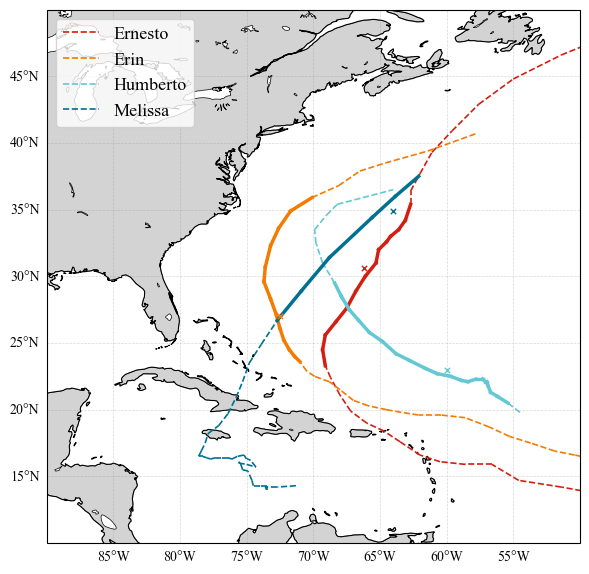

In [78]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Set Times New Roman for all text in the plot
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10

# Create figure and subplot with Cartopy projection
fig, ax = plt.subplots(1, 1, figsize=(6, 15), 
                        subplot_kw={'projection': ccrs.PlateCarree()})

# Set the extent to cover the Atlantic hurricane region
# [lon_min, lon_max, lat_min, lat_max]
# Typical Atlantic hurricane basin: ~100W to 20W, 5N to 45N
ax.set_extent([-90, -50, 10, 50], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='white')#'lightblue'
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
#ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')
ax.add_feature(cfeature.LAKES, facecolor='white', edgecolor='black', linewidth=0.5)# 'lightblue'

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', 
                  alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10, 'family': 'Times New Roman'}
gl.ylabel_style = {'size': 10, 'family': 'Times New Roman'}


# add individual tracks, start with Ernesto
colors = ['#d31f11','#f47a00','#62c8d3','#007191']
plot_hurricane_path(ax, ernesto_path, colors[0] , storm_data["Hurricane_Ernesto"]["min_lon"], storm_data["Hurricane_Ernesto"]["max_lon"], storm_data["Hurricane_Ernesto"]["min_lat"], storm_data["Hurricane_Ernesto"]["max_lat"], label='Ernesto')
target_point = [30.6, -66.2]
ax.scatter(target_point[1], target_point[0], c=colors[0], s=15, marker = 'x', linewidths=1)

plot_hurricane_path(ax, erin_path, colors[1] , storm_data["Hurricane_Erin"]["min_lon"], storm_data["Hurricane_Erin"]["max_lon"], storm_data["Hurricane_Erin"]["min_lat"], storm_data["Hurricane_Erin"]["max_lat"], label='Erin')
target_point = [27, -72.5]
ax.scatter(target_point[1], target_point[0], c=colors[1], s=15, marker = 'x', linewidths=1, zorder=10)

plot_hurricane_path(ax, humberto_path, colors[2] , storm_data["Hurricane_Humberto"]["min_lon"], storm_data["Hurricane_Humberto"]["max_lon"], storm_data["Hurricane_Humberto"]["min_lat"], storm_data["Hurricane_Humberto"]["max_lat"], label='Humberto')
target_point = [23, -60]
ax.scatter(target_point[1], target_point[0], c=colors[2], s=15, marker = 'x', linewidths=1, zorder=10)

plot_hurricane_path(ax, melissa_path, colors[3] , storm_data["Hurricane_Melissa"]["min_lon"], storm_data["Hurricane_Melissa"]["max_lon"], storm_data["Hurricane_Melissa"]["min_lat"], storm_data["Hurricane_Melissa"]["max_lat"], label='Melissa')
target_point = [34.9, -64]
ax.scatter(target_point[1], target_point[0], c=colors[3], s=15, marker = 'x', linewidths=1, zorder=10)

# Legend with Times New Roman
ax.legend(prop={'family': 'Times New Roman', 'size': 13})

# Adjust layout and display
plt.tight_layout()
plt.savefig(f'{output_path}/Hurricanes_summary map.png', dpi=300, bbox_inches='tight')